In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
import igraph as ig
import leidenalg as la
import itertools
import math
import scipy.sparse as sp
import random
import heapq
import copy
import pickle
import joblib
from datetime import datetime, timedelta
from venn import venn
from scipy.stats import pearsonr, spearmanr, kendalltau
from collections import Counter, defaultdict
from itertools import combinations
from sklearn.metrics import normalized_mutual_info_score, adjusted_mutual_info_score, adjusted_rand_score
from math import log2

In [3]:
plt.rcdefaults()

## Data preparation

In [4]:
transfers_df = pd.read_csv('data/1_year/reduced_transfers_1_year.csv')

def filter_votes(data):
    for proposal in data:
        proposal['votes'] = [vote for vote in proposal['votes'] if float(vote['weight']) > 0]
        
    return data

with open('data/proposals/compound/compound_proposals_1_year.json', 'r', encoding='utf8') as file:
    comp_proposals = json.load(file)['data']['proposals']
    
with open('data/proposals/compound/compound_votes_1_year.json', 'r', encoding='utf8') as file:
    comp_votes = filter_votes(json.load(file))
    
with open('data/proposals/compound/compound_delegations.json', 'r', encoding='utf8') as file:
    delegations = json.load(file)['data']['delegateChanges']
    
delegations = [
    entry for entry in delegations
    if 1696118399 < int(entry['blockTimestamp']) < 1727740800
]

In [5]:
COMP_tokens = ['COMP', 'PolCOMP', 'ArbCOMP']
cTokens = ['cWETHv3', 'cArbWETH']
# cTokens = ['cUSDCv3', 'cArbUSDC', 'cUSDTv3', 'cPolUSDT', 'cArbUSDT', 'cWETHv3', 'cArbWETH']

comp_df = transfers_df[
    transfers_df['token'].isin(COMP_tokens) &
    (transfers_df['from'].str.lower() != transfers_df['to'].str.lower()) &
    (transfers_df['value'] != 0)
]
cToken_df = transfers_df[
    transfers_df['token'].isin(cTokens) &
    (transfers_df['from'].str.lower() != transfers_df['to'].str.lower()) &
    (transfers_df['value'] != 0)
]

# addresses = pd.read_csv('data/addresses/comp_addresses.csv')

# EOA = set(addresses.loc[addresses['type'] == False, 'address'])
# CA = set(addresses.loc[addresses['type'] == True, 'address'])

# CEX_addresses = pd.read_csv('data/exchanges/cex.csv')
# CEX = set(CEX_addresses['address'].str.lower())

G_comp_nodes = set(comp_df['from'].str.lower()).union(set(comp_df['to'].str.lower()))
G_cToken_nodes = set(cToken_df['from'].str.lower()).union(set(cToken_df['to'].str.lower()))

## Network construction

### Most important networks

In [6]:
# COMP GRAPH AGGREGATED BY TRANSFER VALUES

G_comp = nx.DiGraph()

for _, row in comp_df.iterrows():
    from_address = row['from'].lower()
    to_address = row['to'].lower()
    value = row['value']
    
    if G_comp.has_edge(from_address, to_address):
        G_comp[from_address][to_address]['weight'] += value
    else:
        G_comp.add_edge(from_address, to_address, weight=value)

largest_wcc_nodes = max(nx.weakly_connected_components(G_comp), key=len)
G_comp = G_comp.subgraph(largest_wcc_nodes).copy()

G_comp_nodes = set(G_comp.nodes())

In [96]:
# COMP TWMDG

G_comp_complete = nx.MultiDiGraph()

for _, row in comp_df.iterrows():
    from_address = row['from'].lower()
    to_address = row['to'].lower()
    value = row['value']
    timestamp = row['timestamp']
    
    G_comp_complete.add_edge(from_address, to_address, weight=value, timestamp=timestamp)

largest_wcc_nodes = max(nx.weakly_connected_components(G_comp_complete), key=len)
G_comp_complete = G_comp_complete.subgraph(largest_wcc_nodes).copy()

In [5]:
# COMP GRAPH AGGREGATED BY NUMBER OF TRANSFERS

G_comp_count = nx.DiGraph()

for _, row in comp_df.iterrows():
    from_address = row['from'].lower()
    to_address = row['to'].lower()
    
    if G_comp_count.has_edge(from_address, to_address):
        G_comp_count[from_address][to_address]['weight'] += 1
    else:
        G_comp_count.add_edge(from_address, to_address, weight=1)

largest_wcc_nodes = max(nx.weakly_connected_components(G_comp_count), key=len)
G_comp_count = G_comp_count.subgraph(largest_wcc_nodes).copy()

In [7]:
# cWETH GRAPH AGGREGATED BY TRANSFER VALUES

G_cWETH = nx.DiGraph()

for _, row in cToken_df.iterrows():
    from_address = row['from'].lower()
    to_address = row['to'].lower()
    value = row['value']
    
    if G_cWETH.has_edge(from_address, to_address):
        G_cWETH[from_address][to_address]['weight'] += value
    else:
        G_cWETH.add_edge(from_address, to_address, weight=value)
        
G_cToken_nodes = set(G_cWETH.nodes())

In [9]:
# cWETH TWMDG

G_cWETH_complete = nx.MultiDiGraph()

for _, row in cToken_df.iterrows():
    from_address = row['from'].lower()
    to_address = row['to'].lower()
    value = row['value']
    timestamp = row['timestamp']
    
    G_cWETH_complete.add_edge(from_address, to_address, weight=value, timestamp=timestamp)

### Governance data

In [8]:
proposal_counts = {}
for proposal in comp_proposals:
    proposer = proposal['proposer']['id']
    if proposer in proposal_counts:
        proposal_counts[proposer] += 1
    else:
        proposal_counts[proposer] = 1

vote_counts = {}
for votes in comp_votes:
    for vote in votes['votes']:
        voter = vote['voter'].get('id')
        if voter in vote_counts:
            vote_counts[voter] += 1
        else:
            vote_counts[voter] = 1

vote_weights = {}
for votes in comp_votes:
    for vote in votes['votes']:
        voter = vote['voter'].get('id')
        weight = vote['weight']
        if voter in vote_weights:
            vote_weights[voter] += float(weight)
        else:
            vote_weights[voter] = float(weight)
            
delegation_counts = {}
from_delegations = {}
to_delegations = {}

for delegation in delegations:
    delegator = delegation['delegator'].lower()
    if delegator in delegation_counts:
        delegation_counts[delegator] += 1
    else:
        delegation_counts[delegator] = 1
        
    if delegator in from_delegations:
        from_delegations[delegator] += 1
    else:
        from_delegations[delegator] = 1
                
    delegate = delegation['delegate'].lower()
    if delegate in delegation_counts:
        delegation_counts[delegate] += 1
    else: 
        delegation_counts[delegate] = 1
        
    if delegate in to_delegations:
        to_delegations[delegate] += 1
    else:
        to_delegations[delegate] = 1

In [9]:
proposers = set()

for proposal in comp_proposals:
    proposers.add(proposal['proposer']['id'])
    
proposers = proposers & G_comp_nodes

In [10]:
for voter in vote_weights:
    vote_weights[voter] = vote_weights[voter] / vote_counts[voter]
    
voters = set()

for votes in comp_votes:
    for vote in votes['votes']:
        voters.add(vote['voter'].get('id'))
        
voters_in_G_comp = voters & G_comp_nodes

In [11]:
delegators = set()
delegates = set()

from_delegations_without_same_to = set()
to_delegations_without_same_from = set()

for delegate in delegations:
    delegator = delegate['delegator']
    delegate = delegate['delegate']
    
    delegators.add(delegator)
    delegates.add(delegate)
    
    if delegator != delegate:
        from_delegations_without_same_to.add(delegator)
        to_delegations_without_same_from.add(delegate)    
    
all_delegations = (delegators | delegates) & G_comp_nodes

In [12]:
all_voters_in_G_comp = voters & G_comp_nodes
all_proposers_voters_delegators_in_G_comp = (proposers | voters | delegators) & G_comp_nodes
all_economic_users_in_G_comp = (set(cToken_df['from'].str.lower()) | set(cToken_df['to'].str.lower())) & G_comp_nodes

only_economic_users_in_G_comp = all_economic_users_in_G_comp - all_voters_in_G_comp
only_voters_in_G_comp = all_voters_in_G_comp - all_economic_users_in_G_comp
both_economic_and_governance_users = all_economic_users_in_G_comp & all_voters_in_G_comp

In [21]:
print(f'Total: {len(G_comp_nodes)}\nProposers: {len(proposers)}\nVoters: {len(voters)}\nDelegations: {len(all_delegations)}\nGovernance: {len(only_governance_users)}\nEconomic: {len(only_economic_users)}')

Total: 74472
Proposers: 5
Voters: 248
Delegations: 457
Governance: 434
Economic: 4791


## Manual feature computations

In [13]:
G_cWETH_igraph = ig.Graph.from_networkx(G_cWETH, vertex_attr_hashable='name')
G_comp_igraph = ig.Graph.from_networkx(G_comp, vertex_attr_hashable='name')

### DC

In [14]:
cWETH_igraph_in_dc = [d for d in G_cWETH_igraph.indegree()]
cWETH_igraph_out_dc = [d for d in G_cWETH_igraph.outdegree()]

cWETH_igraph_in_dc = {G_cWETH_igraph.vs[i]["name"]: score for i, score in enumerate(cWETH_igraph_in_dc)}
cWETH_igraph_out_dc = {G_cWETH_igraph.vs[i]["name"]: score for i, score in enumerate(cWETH_igraph_out_dc)}

comp_igraph_in_dc = [d for d in G_comp_igraph.indegree()]
comp_igraph_out_dc = [d for d in G_comp_igraph.outdegree()]

comp_igraph_in_dc = {G_comp_igraph.vs[i]["name"]: score for i, score in enumerate(comp_igraph_in_dc)}
comp_igraph_out_dc = {G_comp_igraph.vs[i]["name"]: score for i, score in enumerate(comp_igraph_out_dc)}

### Eigenvector centrality

In [15]:
def eigenvector_manual(graph, tol=1e-6, max_iter=100):    
    n = graph.vcount()
    edges = np.array(graph.get_edgelist())
    weights = np.array(graph.es["weight"])

    row, col = edges[:, 1], edges[:, 0]
    W = sp.csr_matrix((weights, (row, col)), shape=(n, n))

    x = np.ones(n)
    for _ in range(max_iter):
        x_new = W @ x
        x_new /= np.linalg.norm(x_new, ord=2)
        
        if np.linalg.norm(x_new - x, ord=2) / np.linalg.norm(x, ord=2) < tol:
            break
        
        x = x_new

    return {graph.vs[i]["name"]: x[i] for i in range(n)}

cWETH_igraph_ec = eigenvector_manual(G_cWETH_igraph)
comp_igraph_ec = eigenvector_manual(G_comp_igraph)

### Local clustering coefficient

In [16]:
def clustering_manual(graph):
    n = graph.vcount()
    
    W_sparse = graph.get_adjacency_sparse(attribute='weight').tocsc()
    W13 = W_sparse.power(1/3)
    W13_T = W13.transpose()
    
    W_sum = W13 + W13_T
    W_sum.data **= 3
    numerator = np.array(W_sum.sum(axis=1)).flatten()
    
    d_out = np.array(graph.outdegree())
    d_in = np.array(graph.indegree())
    d_tot = d_out + d_in
    
    A_sparse = graph.get_adjacency_sparse().tocsc()
    mutual_edges = np.array(A_sparse.multiply(A_sparse.T).sum(axis=1)).flatten()
    
    denominator = 2 * (d_tot * (d_tot - 1) - 2 * mutual_edges)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        C = np.where(denominator > 0, numerator / denominator, 0)
    
    return {graph.vs[i]["name"]: C[i] for i in range(n)}

cWETH_igraph_cc = clustering_manual(G_cWETH_igraph)
comp_igraph_cc = clustering_manual(G_comp_igraph)

### 2-hop neighbors

In [22]:
def two_hop_weight_sum_ig(G):
    weight_sums = [0] * G.vcount()

    for node in range(G.vcount()):
        visited = set()
        total_weight = 0

        neighbors = set(G.neighborhood(node, order=1, mode='ALL'))

        for n in neighbors:
            for e in G.incident(n, mode='ALL'):
                if e not in visited:
                    total_weight += G.es[e]['weight']
                    visited.add(e)

        weight_sums[node] = total_weight

    return {G.vs[i]["name"]: weight_sums[i] for i in range(G.vcount())}

In [ ]:
comp_igraph_2_hop_weights = two_hop_weight_sum_ig(G_comp_igraph)

with open('centrality_scores/COMP_2_hop_weights.json', 'w') as f:
    json.dump(comp_igraph_2_hop_weights, f)

In [17]:
with open('centrality_scores/COMP_2_hop_weights.json', 'r', encoding='utf8') as f:
    comp_igraph_2_hop_weights = json.load(f)

### Burstiness

In [18]:
def compute_burstiness(group):
    if len(group) < 2:
        return None
    
    sigma = group['iet'].std()
    mean = group['iet'].mean()
    
    return sigma / mean if mean > 0 else 0

def construct_burstiness_dictionaries(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'].astype('int64'), unit='s')
    
    # df_sorted_to = df.sort_values(by=['to', 'timestamp'])
    # df_sorted_to['iet'] = df_sorted_to.groupby('to')['timestamp'].diff().dt.total_seconds()
    # burstiness_to_df = df_sorted_to.dropna().groupby('to').apply(compute_burstiness).reset_index(name='burstiness_in')
    # burstiness_to = burstiness_to_df.dropna().set_index('to')['burstiness_in'].to_dict()

    # df_sorted_from = df.sort_values(by=['from', 'timestamp'])
    # df_sorted_from['iet'] = df_sorted_from.groupby('from')['timestamp'].diff().dt.total_seconds()
    # burstiness_from_df = df_sorted_from.dropna().groupby('from').apply(compute_burstiness).reset_index(name='burstiness_out')
    # burstiness_from = burstiness_from_df.dropna().set_index('from')['burstiness_out'].to_dict()

    df_combined = df.melt(id_vars=['timestamp'], value_vars=['from', 'to'], var_name='direction', value_name='address')
    df_combined = df_combined.sort_values(by=['address', 'timestamp'])
    df_combined['iet'] = df_combined.groupby('address')['timestamp'].diff().dt.total_seconds()
    grouped = df_combined.dropna().groupby('address')
    burstiness_total_df = grouped[['iet']].apply(compute_burstiness).reset_index(name='burstiness_total')
    burstiness_total = burstiness_total_df.dropna().set_index('address')['burstiness_total'].to_dict()
    
    return burstiness_total #, burstiness_to, burstiness_from

In [19]:
# comp_burstiness_to, comp_burstiness_from, comp_burstiness_total = construct_burstiness_dictionaries(comp_df)
# cWETH_burstiness_to, cWETH_burstiness_from, cWETH_burstiness_total = construct_burstiness_dictionaries(cToken_df)

comp_burstiness_total = construct_burstiness_dictionaries(comp_df)
cWETH_burstiness_total = construct_burstiness_dictionaries(cToken_df)

## Correlation analysis

### Comparing only the overlapping nodes

In [20]:
all_COMP_transfers = comp_df.melt(value_vars=['from', 'to'], id_vars=['value'], value_name='address')
average_COMP_tokens = all_COMP_transfers.groupby('address')['value'].mean().to_dict()
COMP_transfer_counts = all_COMP_transfers['address'].value_counts().to_dict()

all_cToken_transfers = cToken_df.melt(value_vars=['from', 'to'], id_vars=['value'], value_name='address')
average_cWETH_tokens = all_cToken_transfers.groupby('address')['value'].mean().to_dict()
cWETH_transfer_counts = all_cToken_transfers['address'].value_counts().to_dict()

In [21]:
all_COMP_users = pd.concat([comp_df[['from', 'value']].rename(columns={'from': 'user'}), comp_df[['to', 'value']].rename(columns={'to': 'user'})])

avg_all_COMP_transfers = all_COMP_users.groupby('user')['value'].mean().to_dict()
avg_outgoing_COMP = comp_df.groupby('from')['value'].mean().to_dict()
avg_incoming_COMP = comp_df.groupby('to')['value'].mean().to_dict()


all_cWETH_users = pd.concat([cToken_df[['from', 'value']].rename(columns={'from': 'user'}), cToken_df[['to', 'value']].rename(columns={'to': 'user'})])

avg_all_cWETH_transfers = all_cWETH_users.groupby('user')['value'].mean().to_dict()
avg_outgoing_cWETH = cToken_df.groupby('from')['value'].mean().to_dict()
avg_incoming_cWETH = cToken_df.groupby('to')['value'].mean().to_dict()

In [22]:
average_from_COMP_transferred_mapping = avg_outgoing_COMP
average_to_COMP_transferred_mapping = avg_incoming_COMP
average_from_cWETH_transferred_mapping = avg_outgoing_cWETH
average_to_cWETH_transferred_mapping = avg_incoming_cWETH

In [23]:
total_COMP_transferred_mapping = {}
# from_COMP_transferred_mapping = {}
# to_COMP_transferred_mapping = {}
average_COMP_transferred_mapping = avg_all_COMP_transfers
# average_from_COMP_transferred_mapping = avg_outgoing_COMP
# average_to_COMP_transferred_mapping = avg_incoming_COMP
number_of_COMP_transfers_mapping = COMP_transfer_counts

proposals_mapping = {}
votes_casted_mapping = {}
# delegation_counts_mapping = {}
from_delegations_mapping = {}
to_delegations_mapping = {}
average_vote_weights_mapping = {}

total_cWETH_transferred_mapping = {}
# from_cWETH_transferred_mapping = {}
# to_cWETH_transferred_mapping = {}
average_cWETH_transferred_mapping = avg_all_cWETH_transfers
# average_from_cWETH_transferred_mapping = avg_outgoing_cWETH
# average_to_cWETH_transferred_mapping = avg_incoming_cWETH
number_of_cWETH_transfers_mapping = cWETH_transfer_counts

for _, row in comp_df.iterrows():
    from_address = row['from'].lower()
    to_address = row['to'].lower()
    value = row['value']
    
    if from_address in total_COMP_transferred_mapping:
        total_COMP_transferred_mapping[from_address] += value
    else:
        total_COMP_transferred_mapping[from_address] = value
        
    # if from_address in from_COMP_transferred_mapping:
    #     from_COMP_transferred_mapping[from_address] += value
    # else:
    #     from_COMP_transferred_mapping[from_address] = value
    
    if to_address in total_COMP_transferred_mapping:
        total_COMP_transferred_mapping[to_address] += value
    else:
        total_COMP_transferred_mapping[to_address] = value
        
    # if to_address in to_COMP_transferred_mapping:
    #     to_COMP_transferred_mapping[to_address] += value
    # else:
    #     to_COMP_transferred_mapping[to_address] = value
        
        
for user, average in average_COMP_tokens.items():
    if user in average_COMP_transferred_mapping:
        average_COMP_transferred_mapping[user] = average
        
# for user, count in COMP_transfer_counts.items():
#     if user in number_of_COMP_transfers_mapping:
#         number_of_COMP_transfers_mapping[user] = count

for proposer, count in proposal_counts.items():
    proposals_mapping[proposer] = count

for voter, count in vote_counts.items():
    votes_casted_mapping[voter] = count

for delegator, count in from_delegations.items():
    from_delegations_mapping[delegator] = count

for delegate, count in to_delegations.items():
    to_delegations_mapping[delegate] = count

for voter, weight in vote_weights.items():
    average_vote_weights_mapping[voter] = weight


for _, row in cToken_df.iterrows():
    from_address = row['from'].lower()
    to_address = row['to'].lower()
    value = row['value']
    
    if from_address in total_cWETH_transferred_mapping:
        total_cWETH_transferred_mapping[from_address] += value
    else:
        total_cWETH_transferred_mapping[from_address] = value
        
    # if from_address in from_cWETH_transferred_mapping:
    #     from_cWETH_transferred_mapping[from_address] += value
    # else:
    #     from_cWETH_transferred_mapping[from_address] = value
        
    if to_address in total_cWETH_transferred_mapping:
        total_cWETH_transferred_mapping[to_address] += value
    else:
        total_cWETH_transferred_mapping[to_address] = value
        
    # if to_address in to_cWETH_transferred_mapping:
    #     to_cWETH_transferred_mapping[to_address] += value
    # else:
    #     to_cWETH_transferred_mapping[to_address] = value

for user, average in average_cWETH_tokens.items():
    if user in average_cWETH_transferred_mapping:
        average_cWETH_transferred_mapping[user] = average
        
# for user, count in aWETH_transfer_counts.items():
#     if user in number_of_aWETH_transfers_mapping:
#         number_of_aWETH_transfers_mapping[user] = count

# addresses = sorted(average_COMP_transferred_mapping.keys())

In [24]:
def compute_overlapping_correlations(x_name, x_map, y_name, y_map, results):
    valid_addresses = [address for address in x_map.keys() & y_map.keys()]
    
    scores_x = [x_map[address] for address in valid_addresses]
    scores_y = [y_map[address] for address in valid_addresses]
    
    spearman = spearmanr(scores_x, scores_y)
    kendall = kendalltau(scores_x, scores_y)
    
    results.append({
        'x_name': x_name,
        'y_name': y_name,
        'spearman': spearman,
        'kendall': kendall,
        'valid_addresses': valid_addresses
    })

In [25]:
# USING THE SCORES AND METRICS WITH OWN COMPUTATIONS INSTEAD OF BUILT-IN FUNCTIONS
COMP_mappings = [
    ('COMP In-Degree Centrality', comp_igraph_in_dc),
    ('COMP Out-Degree Centrality', comp_igraph_out_dc),
    ('COMP Eigenvector Centrality', comp_igraph_ec),
    ('COMP Clustering Coefficient', comp_igraph_cc),
    # ('Total COMP transferred', total_COMP_transferred_mapping),
    # ('From COMP', from_COMP_transferred_mapping),
    # ('To COMP', to_COMP_transferred_mapping),
    ('COMP Avg. per Transfer', average_COMP_transferred_mapping),
    # ('Average COMP sent per transfer', average_from_COMP_transferred_mapping),
    # ('Average COMP received per transfer', average_to_COMP_transferred_mapping),
    ('COMP Transfer Count', number_of_COMP_transfers_mapping),
    ('COMP 2-Hop Weight Sum', comp_igraph_2_hop_weights),
    ('COMP Burstiness', comp_burstiness_total)
]

gov_mappings = [
    # ('Proposals Made', proposals_mapping),
    ('Votes Cast', votes_casted_mapping),
    # ('Delegations Given', from_delegations_mapping),
    ('Delegations Reveived', to_delegations_mapping),
    ('Avg. Vote Weight', average_vote_weights_mapping)
]    

cWETH_mappings = [
    ('cWETH In-Degree Centrality', cWETH_igraph_in_dc),
    ('cWETH Out-Degree Centrality', cWETH_igraph_out_dc),
    # ('cWETH Eigenvector Centrality', cWETH_igraph_ec),
    # ('cWETH Clustering Coefficient', cWETH_igraph_cc),
    # ('Total cWETH transferred', total_cWETH_transferred_mapping),
    # ('From cWETH', from_cWETH_transferred_mapping),
    # ('To cWETH', to_cWETH_transferred_mapping),
    ('cWETH Avg. per Transfer', average_cWETH_transferred_mapping),
    # ('Average cWETH sent per transfer', average_from_cWETH_transferred_mapping),
    # ('Average cWETH received per transfer', average_to_cWETH_transferred_mapping),
    ('cWETH Transfer Count', number_of_cWETH_transfers_mapping),
    ('cWETH Burstiness', cWETH_burstiness_total)
]

mapping_dict = dict(COMP_mappings) | dict(gov_mappings) | dict(cWETH_mappings)

# nonzero_results = []

# for (x_name, x_map), (y_name, y_map) in itertools.product(COMP_mappings, gov_mappings):
#     compute_overlapping_correlations(x_name, x_map, y_name, y_map, nonzero_results)

# for (x_name, x_map), (y_name, y_map) in itertools.product(COMP_mappings, cWETH_mappings):
#     compute_overlapping_correlations(x_name, x_map, y_name, y_map, nonzero_results)

# for (x_name, x_map), (y_name, y_map) in itertools.product(cWETH_mappings, gov_mappings):
#     compute_overlapping_correlations(x_name, x_map, y_name, y_map, nonzero_results)

# #######

comp_gov_results = []
comp_cWETH_results = []
cWETH_gov_results = []

for (x_name, x_map), (y_name, y_map) in itertools.product(COMP_mappings, gov_mappings):
    compute_overlapping_correlations(x_name, x_map, y_name, y_map, comp_gov_results)

for (x_name, x_map), (y_name, y_map) in itertools.product(COMP_mappings, cWETH_mappings):
    compute_overlapping_correlations(x_name, x_map, y_name, y_map, comp_cWETH_results)

for (x_name, x_map), (y_name, y_map) in itertools.product(cWETH_mappings, gov_mappings):
    compute_overlapping_correlations(x_name, x_map, y_name, y_map, cWETH_gov_results)
    

# threshold = 0.75

# for res in nonzero_results:
#     kendall = res['kendall']
    
#     if kendall.statistic > threshold:
#         valid_addresses = res['valid_addresses']
#         percentage_of_addresses = (len(valid_addresses)/len(G_comp_nodes)) * 100
        
#         print(f'{res["x_name"]} vs {res["y_name"]} -> Kendall: {kendall.statistic:.3f}, number of addresses: {len(valid_addresses)}, percentage of addresses: {percentage_of_addresses:.2f}%')
#         print()
        
#         x_map = mapping_dict.get(res['x_name'])
#         y_map = mapping_dict.get(res['y_name'])

#         x_vals = [x_map[address] for address in valid_addresses]
#         y_vals = [y_map[address] for address in valid_addresses]
        
#         fig, axes = plt.subplots(1, 2, figsize=(14, 6))

#         axes[0].scatter(x_vals, y_vals, alpha=0.6)
#         axes[0].set_xlabel(res['x_name'])
#         axes[0].set_ylabel(res['y_name'])
#         axes[0].set_title('Original scale')

#         # log_x = np.log(x_vals)
#         # log_y = np.log(y_vals)
#         # sns.regplot(x=log_x, y=log_y, ax=axes[1])
#         # axes[1].set_xlabel(f'Log({res["x_name"]})')
#         # axes[1].set_ylabel(f'Log({res["y_name"]})')
#         # axes[1].set_title('Log-Log Scale')
#         ####
#         axes[1].scatter(x_vals, y_vals, alpha=0.6)
#         axes[1].set_xscale('log')
#         axes[1].set_yscale('log')
#         axes[1].set_xlabel(res['x_name'])
#         axes[1].set_ylabel(res['y_name'])
#         axes[1].set_title('Log-scaled axes')

#         plt.tight_layout()
#         plt.show()

C:\Users\Sam\AppData\Local\Temp\ipykernel_4508\1207881687.py:7: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman = spearmanr(scores_x, scores_y)


In [ ]:
with open('data/SI/comp/SI_5_extracted_seeds_avg_infected.pkl', 'rb') as f:
    SI_5_extracted = pickle.load(f)
    
with open('data/SI/comp/SI_2_extracted_seeds_avg_infected.pkl', 'rb') as f:
    SI_2_extracted = pickle.load(f)

with open('data/SI/comp/SI_1_extracted_seeds_avg_infected.pkl', 'rb') as f:
    SI_1_extracted = pickle.load(f)
    
with open('data/SI/comp/SI_05_extracted_seeds_avg_infected.pkl', 'rb') as f:
    SI_05_extracted = pickle.load(f)
    
with open('data/SI/comp/SI_01_extracted_seeds_avg_infected.pkl', 'rb') as f:
    SI_01_extracted = pickle.load(f)
    
with open('data/SI/comp/SI_001_extracted_seeds_avg_infected.pkl', 'rb') as f:
    SI_001_extracted = pickle.load(f)
    
SI_001_mapping = {i['seed']: i['avg_infected'] for i in SI_001_extracted}
SI_01_mapping = {i['seed']: i['avg_infected'] for i in SI_01_extracted}
SI_05_mapping = {i['seed']: i['avg_infected'] for i in SI_05_extracted}
SI_1_mapping = {i['seed']: i['avg_infected'] for i in SI_1_extracted}
SI_2_mapping = {i['seed']: i['avg_infected'] for i in SI_2_extracted}
SI_5_mapping = {i['seed']: i['avg_infected'] for i in SI_5_extracted}

SI_mappings = [
    ('SI 0.001', SI_001_mapping),
    ('SI 0.01', SI_01_mapping),
    ('SI 0.05', SI_05_mapping),
    ('SI 1', SI_1_mapping),
    ('SI 2', SI_2_mapping),
    ('SI 5', SI_5_mapping)
]

In [104]:
gov_si_results = []

for (x_name, x_map), (y_name, y_map) in itertools.product(gov_mappings, SI_mappings):
    compute_overlapping_correlations(x_name, x_map, y_name, y_map, gov_si_results)

In [63]:
# COMPUTING CORRELATIONS WITHIN THE DATASETS
COMP_mappings = [
    ('COMP In-Degree Centrality', comp_igraph_in_dc),
    ('COMP Out-Degree Centrality', comp_igraph_out_dc),
    ('COMP Eigenvector Centrality', comp_igraph_ec),
    ('COMP Clustering Coefficient', comp_igraph_cc),
    # ('Total COMP transferred', total_COMP_transferred_mapping),
    # ('From COMP', from_COMP_transferred_mapping),
    # ('To COMP', to_COMP_transferred_mapping),
    ('COMP Avg. per Transfer', average_COMP_transferred_mapping),
    # ('Average from COMP transferred', average_from_COMP_transferred_mapping),
    # ('Average to COMP transferred', average_to_COMP_transferred_mapping),
    ('COMP Transfer Count', number_of_COMP_transfers_mapping),
    ('COMP 2-Hop Weight Sum', comp_igraph_2_hop_weights),
    ('COMP Burstiness', comp_burstiness_total)
]

gov_mappings = [
    ('Votes Cast', votes_casted_mapping),
    # ('From delegations', from_delegations_mapping),
    ('Governance Delegations Reveived', to_delegations_mapping),
    ('Avg. Vote Weight', average_vote_weights_mapping)
]    

cWETH_mappings = [
    ('cWETH In-Degree Centrality', cWETH_igraph_in_dc),
    ('cWETH Out-Degree Centrality', cWETH_igraph_out_dc),
    # ('cWETH Eigenvector Centrality', cWETH_igraph_ec),
    # ('cWETH Clustering Coefficient', cWETH_igraph_cc),
    # ('Total cWETH transferred', total_cWETH_transferred_mapping),
    # ('From cWETH', from_cWETH_transferred_mapping),
    # ('To cWETH', to_cWETH_transferred_mapping),
    ('cWETH Avg. per Transfer', average_cWETH_transferred_mapping),
    # ('Average from cWETH transferred', average_from_cWETH_transferred_mapping),
    # ('Average to cWETH transferred', average_to_cWETH_transferred_mapping),
    ('cWETH Transfer Count', number_of_cWETH_transfers_mapping),
    ('cWETH Burstiness', cWETH_burstiness_total)
]

mapping_dict = dict(COMP_mappings) | dict(gov_mappings) | dict(cWETH_mappings)

# nonzero_results = []

# for (x_name, x_map), (y_name, y_map) in list(combinations(COMP_mappings, 2)):
#     compute_overlapping_correlations(x_name, x_map, y_name, y_map, nonzero_results)

# for (x_name, x_map), (y_name, y_map) in list(combinations(cWETH_mappings, 2)):
#     compute_overlapping_correlations(x_name, x_map, y_name, y_map, nonzero_results)

# for (x_name, x_map), (y_name, y_map) in list(combinations(gov_mappings, 2)):
#     compute_overlapping_correlations(x_name, x_map, y_name, y_map, nonzero_results)

#####

comp_results = []
cWETH_results = []
gov_results = []

for (x_name, x_map), (y_name, y_map) in list(combinations(COMP_mappings, 2)):
    compute_overlapping_correlations(x_name, x_map, y_name, y_map, comp_results)
    
# for (x_name, x_map), (y_name, y_map) in list(combinations(cWETH_mappings, 2)):
#     compute_overlapping_correlations(x_name, x_map, y_name, y_map, cWETH_results)
    
# for (x_name, x_map), (y_name, y_map) in list(combinations(gov_mappings, 2)):
#     compute_overlapping_correlations(x_name, x_map, y_name, y_map, gov_results)

# threshold = 0.7

# for res in nonzero_results:
#     spearman = res['spearman']
#     kendall = res['kendall']
    
#     if spearman.statistic > threshold or kendall.statistic > threshold:
#     # if spearman.statistic < threshold or kendall.statistic < threshold:
#         valid_addresses = res['valid_addresses']
        
#         print(f'{res["x_name"]} vs {res["y_name"]} -> Spearman: {spearman.statistic:.3f}, Kendall: {kendall.statistic:.3f}, number of addresses: {len(valid_addresses)}')
#         # print(f'Spearman p-value: {spearman.pvalue:.3f}, Kendall p-value: {kendall.pvalue:.3f}')
#         # print()
        
#         # x_map = mapping_dict.get(res['x_name'])
#         # y_map = mapping_dict.get(res['y_name'])
        
#         # plt.figure(figsize=(10, 6))
#         # plt.scatter([x_map[address] for address in valid_addresses], [y_map[address] for address in valid_addresses], alpha=0.6)
#         # plt.xlabel(res['x_name'])
#         # plt.ylabel(res['y_name'])
#         # plt.show()
        
#         # log_x = np.log1p([x_map[address] for address in valid_addresses])
#         # log_y = np.log1p([y_map[address] for address in valid_addresses])

#         # sns.regplot(x=log_x, y=log_y)
#         # plt.xlabel(f'Log({res["x_name"]})')
#         # plt.ylabel(f'Log({res["y_name"]})')
#         # plt.show()

### Correlation heatmaps

In [26]:
def create_heatmap(results):
    def unique_ordered(items):
        seen = set()
        ordered = []
        for item in items:
            if item not in seen:
                seen.add(item)
                ordered.append(item)
        return ordered

    x_datasets = unique_ordered([entry['x_name'] for entry in results])
    y_datasets = unique_ordered([entry['y_name'] for entry in results])

    # spearman_corr_matrix = np.zeros((len(x_datasets), len(y_datasets)))
    kendall_corr_matrix = np.zeros((len(x_datasets), len(y_datasets)))

    for entry in results:
        x_idx = x_datasets.index(entry['x_name'])
        y_idx = y_datasets.index(entry['y_name'])
        # spearman_corr_matrix[x_idx, y_idx] = entry['spearman'].statistic
        kendall_corr_matrix[x_idx, y_idx] = entry['kendall'].statistic

    # spearman_corr_df = pd.DataFrame(spearman_corr_matrix, index=x_datasets, columns=y_datasets)
    kendall_corr_df = pd.DataFrame(kendall_corr_matrix, index=x_datasets, columns=y_datasets)

    # plt.figure(figsize=(8, 6))
    # sns.heatmap(spearman_corr_df, annot=True, cmap='coolwarm', cbar=True, fmt='.2f', vmin=-1, vmax=1)
    # plt.title("Spearman correlation")
    # plt.show()

    plt.figure(figsize=(8, 6))
    sns.heatmap(kendall_corr_df, annot=True, cmap='coolwarm', cbar=True, fmt='.2f', vmin=-1, vmax=1)
    # plt.title("Kendall correlation")
    plt.show()

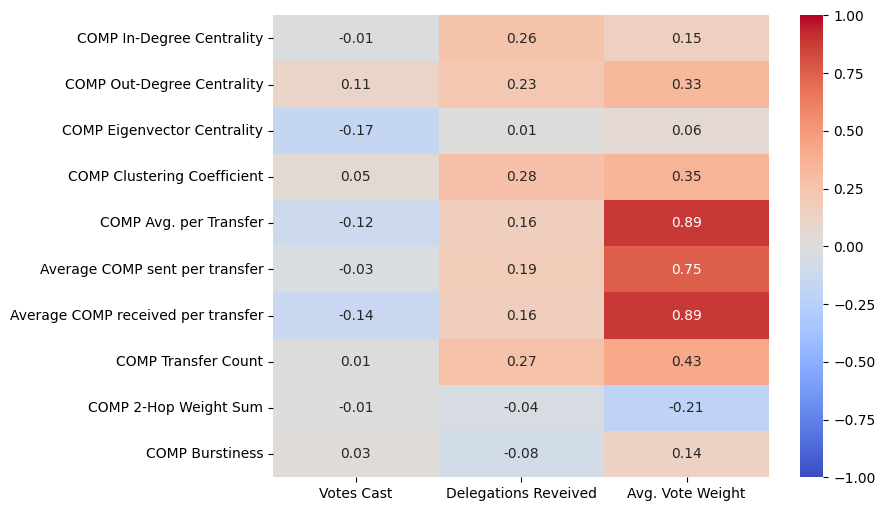

In [168]:
create_heatmap(comp_gov_results)

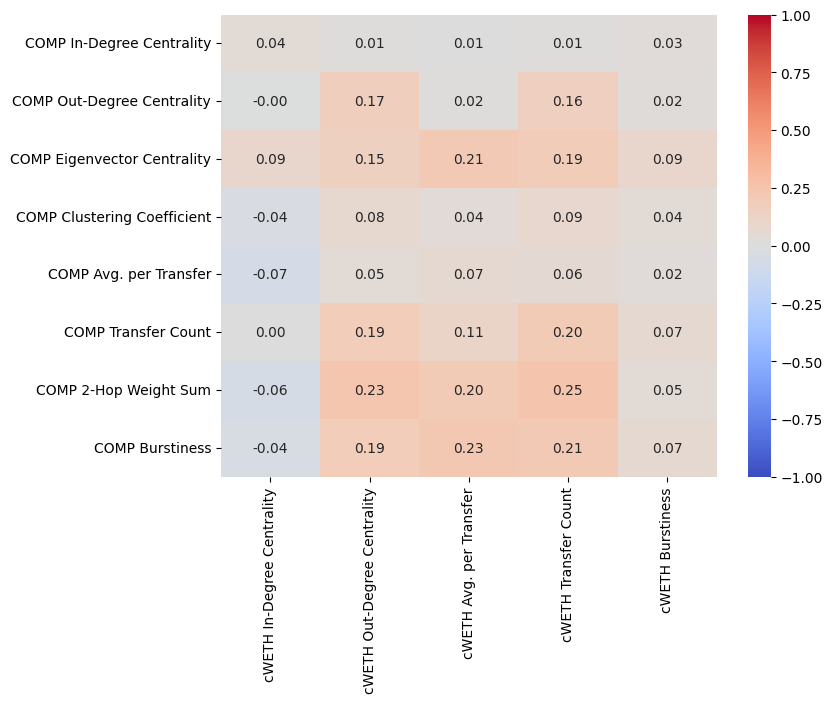

In [27]:
create_heatmap(comp_cWETH_results)

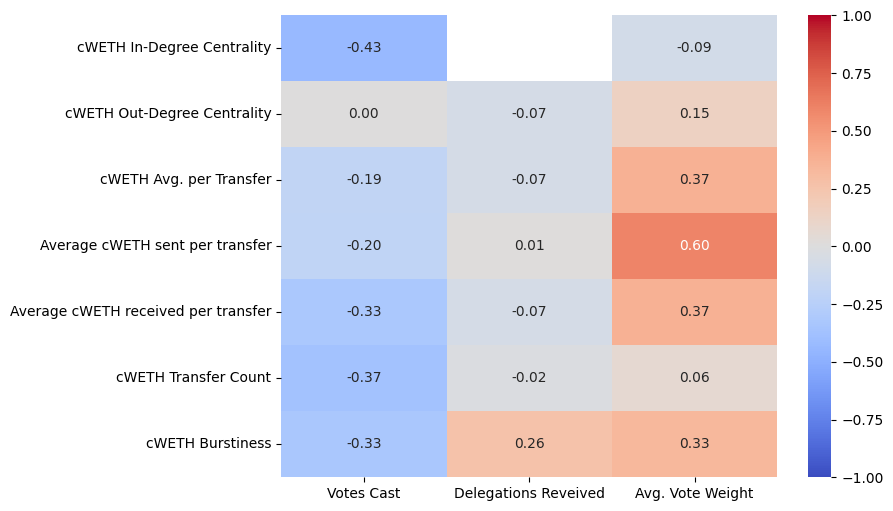

In [170]:
create_heatmap(cWETH_gov_results)

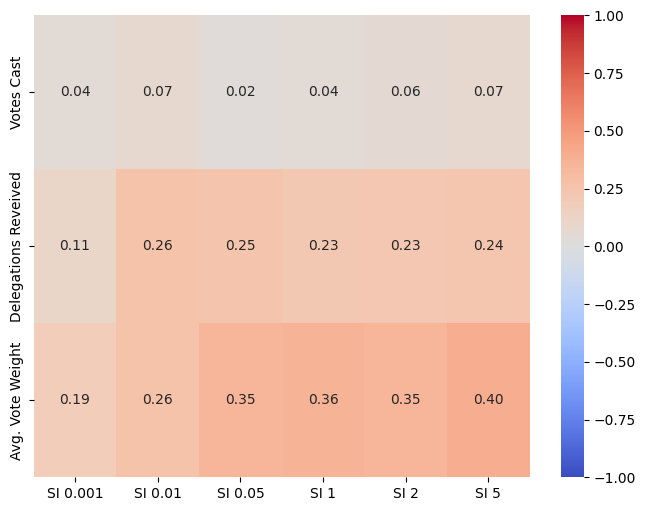

In [109]:
create_heatmap(gov_si_results)

In [70]:
def create_lower_triangle_heatmap(results):
    def unique_ordered(items):
        seen = set()
        ordered = []
        for item in items:
            if item not in seen:
                seen.add(item)
                ordered.append(item)
        return ordered

    feature_names = unique_ordered(
        [entry['x_name'] for entry in results] + [entry['y_name'] for entry in results]
    )

    n = len(feature_names)
    spearman_corr_matrix = np.zeros((n, n))
    kendall_corr_matrix = np.zeros((n, n))

    for entry in results:
        x_idx = feature_names.index(entry['x_name'])
        y_idx = feature_names.index(entry['y_name'])
        spearman = entry['spearman'].statistic
        kendall = entry['kendall'].statistic

        spearman_corr_matrix[x_idx, y_idx] = spearman
        spearman_corr_matrix[y_idx, x_idx] = spearman
        kendall_corr_matrix[x_idx, y_idx] = kendall
        kendall_corr_matrix[y_idx, x_idx] = kendall

    mask = np.triu(np.ones_like(spearman_corr_matrix, dtype=bool), k=0)

    trimmed_feature_names_y = feature_names[1:]
    trimmed_feature_names_x = feature_names[:-1]
    spearman_corr_trimmed = spearman_corr_matrix[1:, :-1]
    kendall_corr_trimmed = kendall_corr_matrix[1:, :-1]
    mask_trimmed = mask[1:, :-1]

    spearman_corr_df = pd.DataFrame(spearman_corr_trimmed, index=trimmed_feature_names_y, columns=trimmed_feature_names_x)
    kendall_corr_df = pd.DataFrame(kendall_corr_trimmed, index=trimmed_feature_names_y, columns=trimmed_feature_names_x)

    plt.figure(figsize=(8, 6))
    # sns.heatmap(spearman_corr_df, annot=True, cmap='coolwarm', cbar=True, fmt='.2f', vmin=-1, vmax=1, square=True)
    sns.heatmap(spearman_corr_df, mask=mask_trimmed, annot=True, cmap='coolwarm', cbar=True, fmt='.2f', vmin=-1, vmax=1)
    plt.title("Spearman correlation")
    plt.show()

    plt.figure(figsize=(8, 6))
    # sns.heatmap(kendall_corr_df, annot=True, cmap='coolwarm', cbar=True, fmt='.2f', vmin=-1, vmax=1, square=True)
    sns.heatmap(kendall_corr_df, mask=mask_trimmed, annot=True, cmap='coolwarm', cbar=True, fmt='.2f', vmin=-1, vmax=1)
    # plt.title("Kendall correlation")
    plt.show()

In [ ]:
create_lower_triangle_heatmap(comp_results)

### Subset comparison per feature

In [ ]:
cWETH_users = (set(cToken_df['from'].unique()) | set(cToken_df['to'].unique()))
COMP_users = (set(comp_df['from'].unique()) | set(comp_df['to'].unique()))

In [ ]:
cWETH_users_in_COMP = cWETH_users & COMP_users
governance_users_in_COMP = (proposers | voters | delegators) & COMP_users

In [ ]:
def plot_subset_vs_rest(feature_mapping, feature_name, use_kde=True):
    subsets = {
        'Financial users': cWETH_users_in_COMP,
        'Governance users': governance_users_in_COMP
    }

    for subset_name, subset in subsets.items():
        in_subset = [feature_mapping[node] for node in subset if node in feature_mapping]
        out_subset = [feature_mapping[node] for node in COMP_users - subset if node in feature_mapping]

        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        if use_kde:
            sns.kdeplot(in_subset, fill=True, alpha=0.6, ax=axes[0])
        else:
            axes[0].hist(in_subset, bins=30, alpha=0.7)
        axes[0].set_title(f'{subset_name}')
        axes[0].set_xlabel(feature_name)
        axes[0].set_ylabel('Density' if use_kde else 'Frequency')

        if use_kde:
            sns.kdeplot(out_subset, fill=True, alpha=0.6, ax=axes[1], color='gray')
        else:
            axes[1].hist(out_subset, bins=30, alpha=0.7, color='gray')
        axes[1].set_title(f'Not {subset_name}')
        axes[1].set_xlabel(feature_name)
        axes[1].set_ylabel('Density' if use_kde else 'Frequency')

        fig.suptitle(f'{feature_name} — {subset_name} vs Rest', fontsize=14)
        plt.tight_layout()
        plt.show()

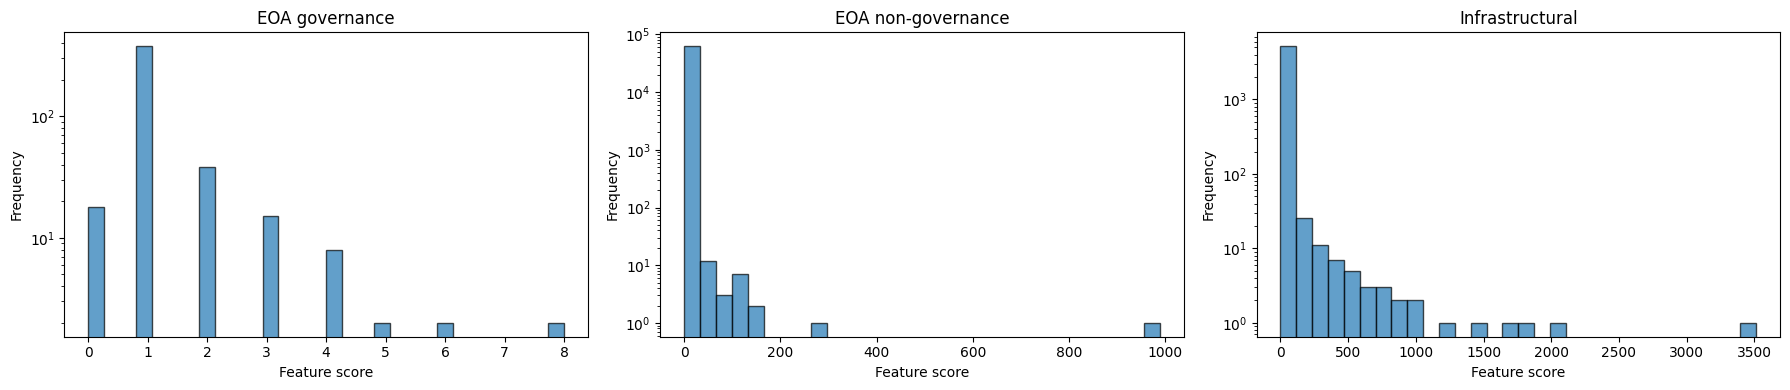

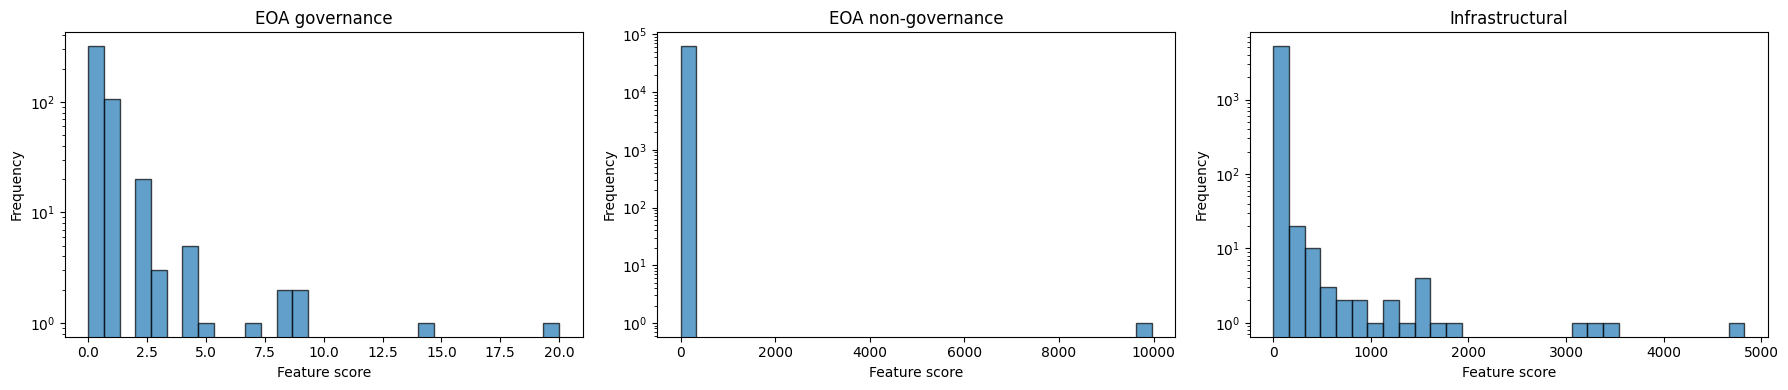

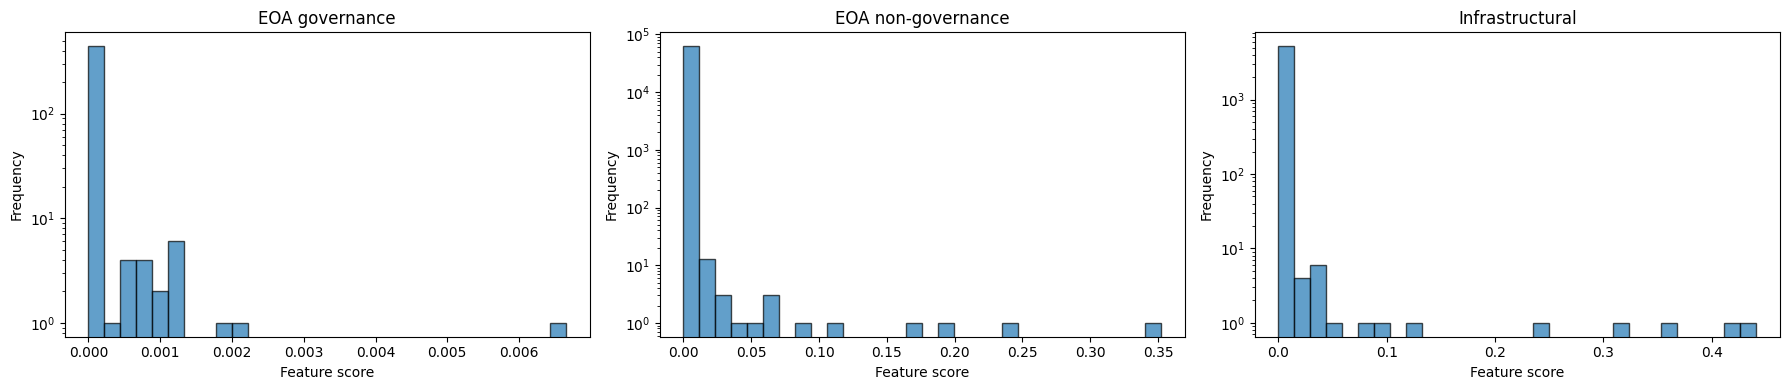

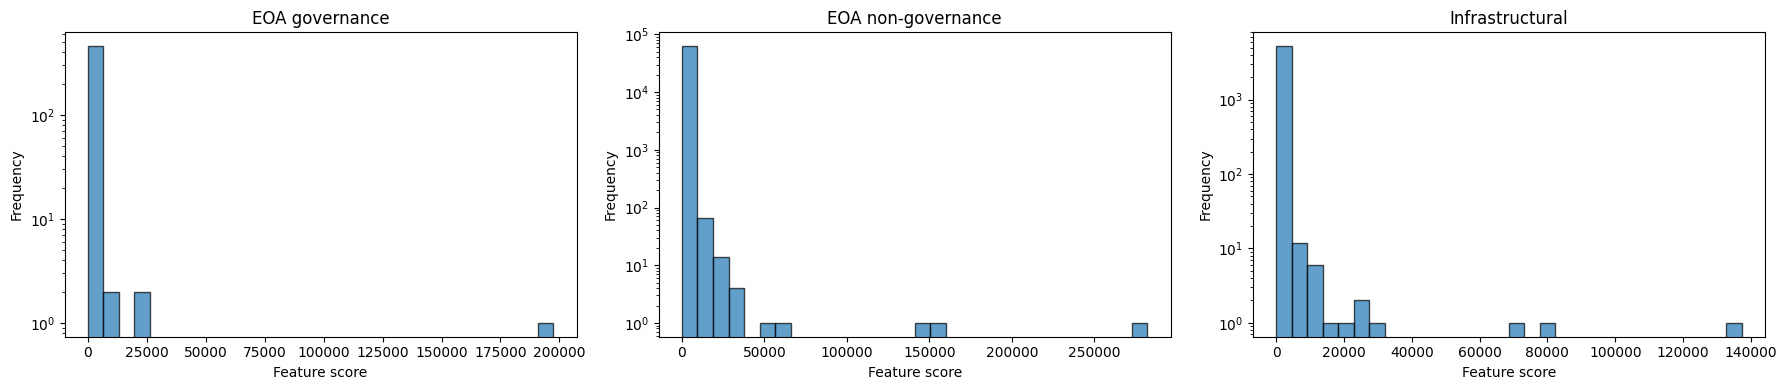

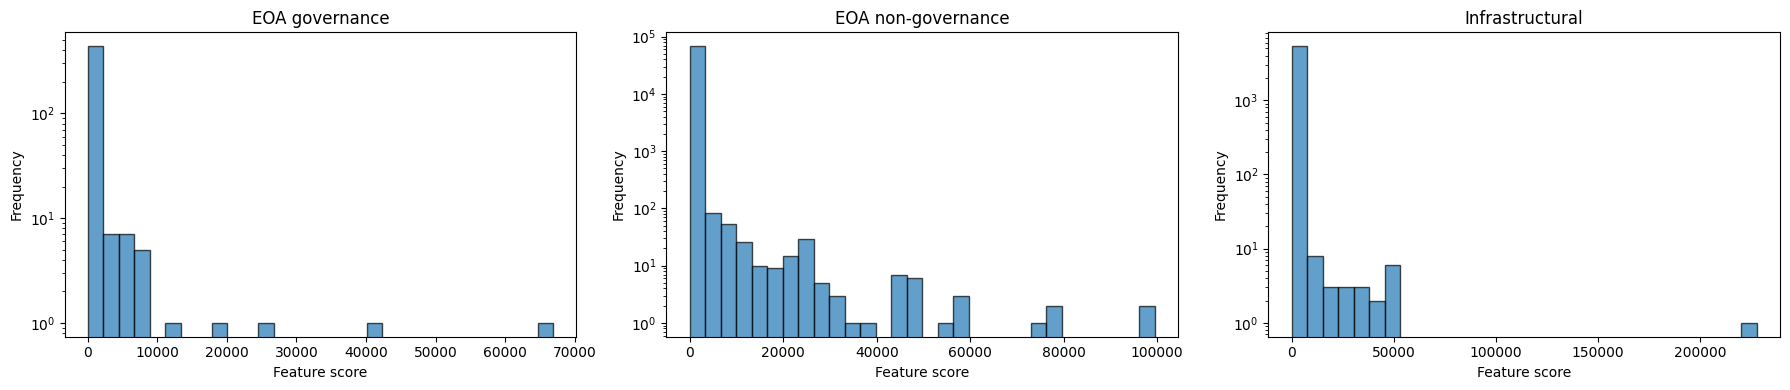

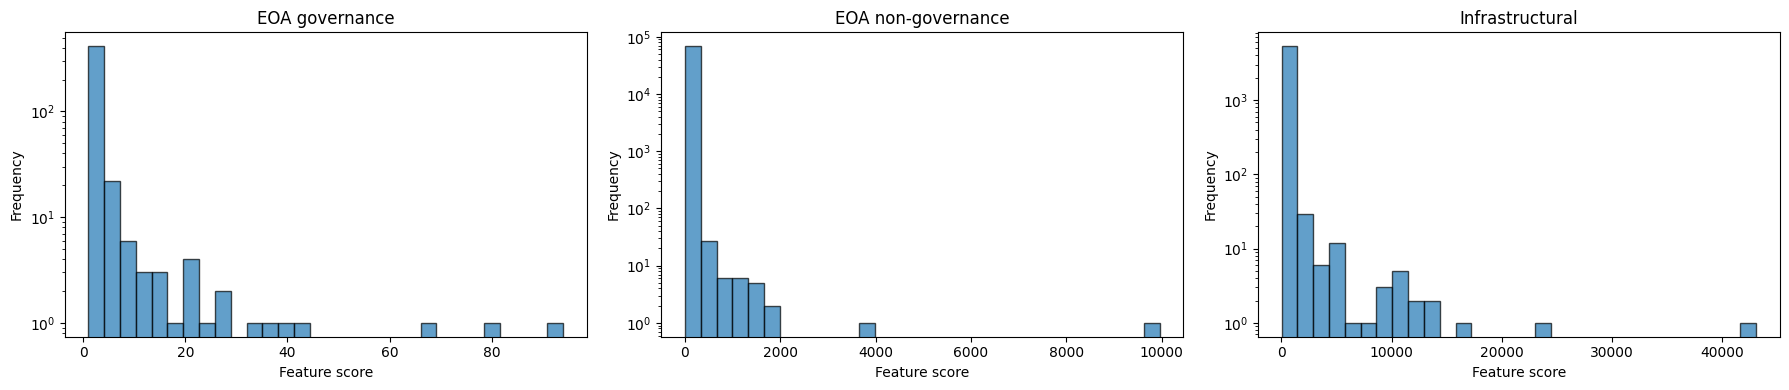

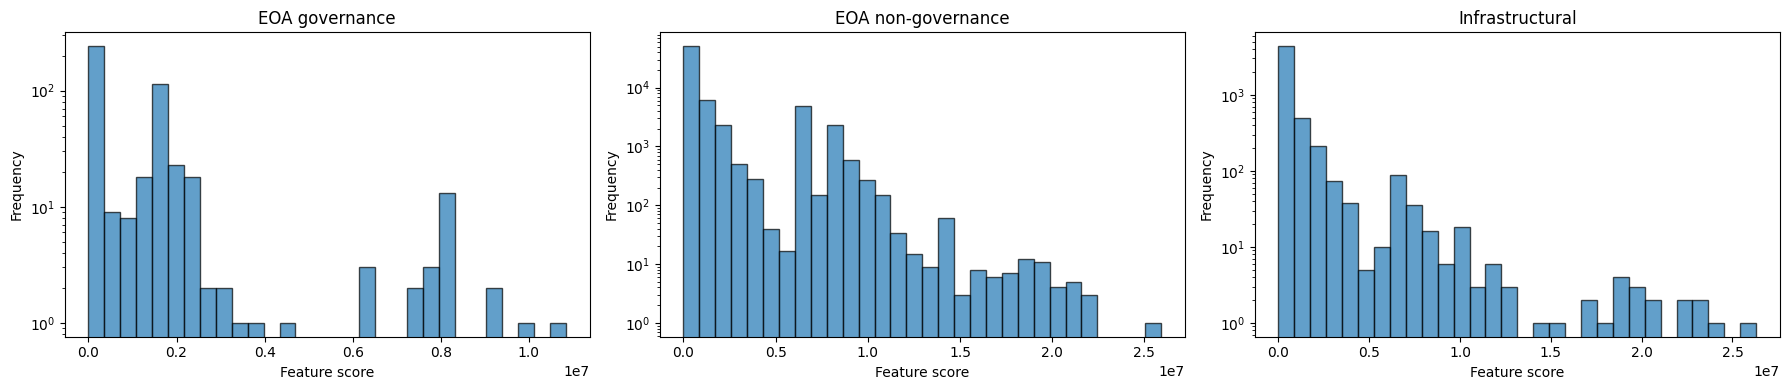

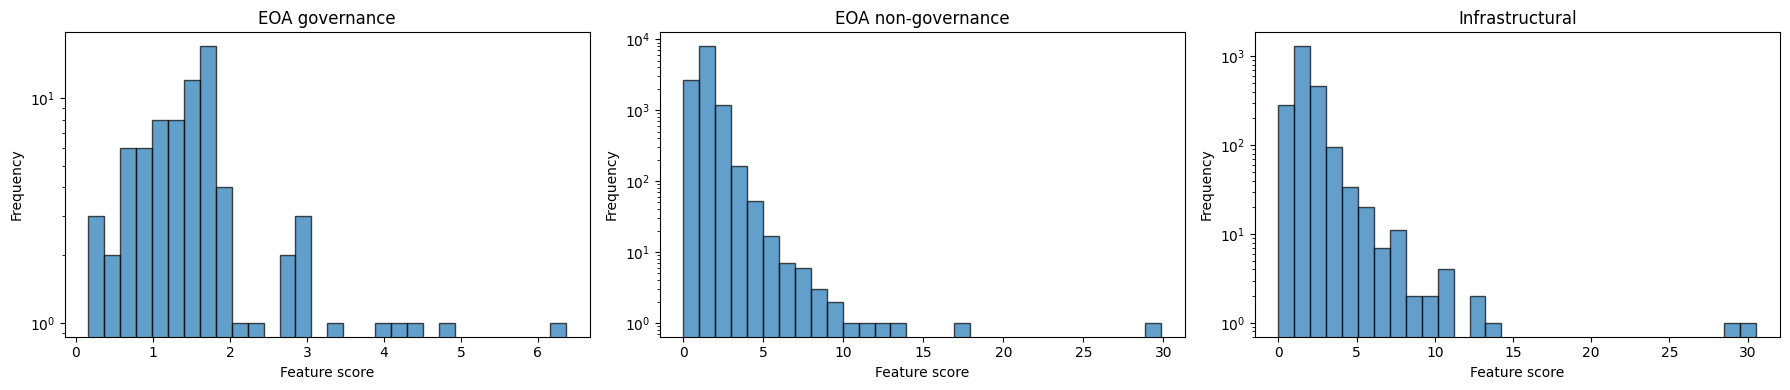

In [34]:
def plot_subset_vs_rest(feature_mapping, feature_name):
    EOA_gov_subset = [feature_mapping[node] for node in feature_mapping if node in EOA and node in governance_users_in_COMP and node not in CEX]
    EOA_non_gov_subset = [feature_mapping[node] for node in feature_mapping if node in EOA and node not in governance_users_in_COMP and node not in CEX]
    # CA_subset = [feature_mapping[node] for node in feature_mapping if node in CA]
    # CEX_subset = [feature_mapping[node] for node in feature_mapping if node in CEX]
    CA_CEX_subset = [feature_mapping[node] for node in feature_mapping if node in CEX or node in CA]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    # fig, axes = plt.subplots(1, 4, figsize=(24, 4))

    axes[0].hist(EOA_gov_subset, bins=30, alpha=0.7, edgecolor='black', log=True)
    axes[0].set_title('EOA governance')
    axes[0].set_xlabel('Feature score')
    axes[0].set_ylabel('Frequency')

    axes[1].hist(EOA_non_gov_subset, bins=30, alpha=0.7, edgecolor='black', log=True)
    axes[1].set_title('EOA non-governance')
    axes[1].set_xlabel('Feature score')
    axes[1].set_ylabel('Frequency')
    
    axes[2].hist(CA_CEX_subset, bins=30, alpha=0.7, edgecolor='black', log=True)
    axes[2].set_title('Infrastructural')
    axes[2].set_xlabel('Feature score')
    axes[2].set_ylabel('Frequency')
    
    # axes[2].hist(CEX_subset, bins=30, alpha=0.7, color='green', log=True)
    # axes[2].set_title(f'CEX')
    # axes[2].set_xlabel(feature_name)
    # axes[2].set_ylabel('Frequency')
    
    # axes[3].hist(CA_subset, bins=30, alpha=0.7, color='orange', log=True)
    # axes[3].set_title(f'CA')
    # axes[3].set_xlabel(feature_name)
    # axes[3].set_ylabel('Frequency')

    # fig.suptitle(f'{feature_name}', fontsize=14)
    plt.tight_layout()
    plt.show()

temp_mapping = [
    ('COMP In-Degree Centrality', comp_igraph_in_dc),
    ('COMP Out-Degree Centrality', comp_igraph_out_dc),
    ('COMP Eigenvector Centrality', comp_igraph_ec),
    ('COMP Clustering Coefficient', comp_igraph_cc),
    ('COMP Avg. per Transfer', average_COMP_transferred_mapping),
    # ('Total transferred', total_AAVE_transferred_mapping),
    ('COMP Transfer Count', number_of_COMP_transfers_mapping),
    ('COMP 2-Hop Weight Sum', comp_igraph_2_hop_weights),
    ('COMP Burstiness', comp_burstiness_total)
]

for feature_name, feature_mapping in temp_mapping:
    plot_subset_vs_rest(feature_mapping, feature_name)

### SI comparison

In [ ]:
with open('data/SI/comp/SI_5_extracted_seeds_avg_infected.pkl', 'rb') as f:
    SI_5_extracted = pickle.load(f)
    
with open('data/SI/comp/SI_2_extracted_seeds_avg_infected.pkl', 'rb') as f:
    SI_2_extracted = pickle.load(f)

with open('data/SI/comp/SI_1_extracted_seeds_avg_infected.pkl', 'rb') as f:
    SI_1_extracted = pickle.load(f)
    
with open('data/SI/comp/SI_05_extracted_seeds_avg_infected.pkl', 'rb') as f:
    SI_05_extracted = pickle.load(f)
    
with open('data/SI/comp/SI_01_extracted_seeds_avg_infected.pkl', 'rb') as f:
    SI_01_extracted = pickle.load(f)
    
with open('data/SI/comp/SI_001_extracted_seeds_avg_infected.pkl', 'rb') as f:
    SI_001_extracted = pickle.load(f)

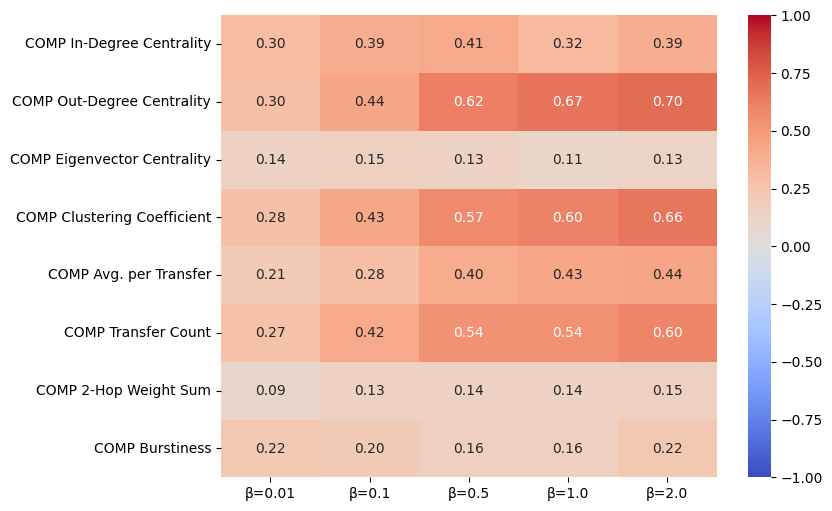

In [117]:
def compute_si_correlations(comp_mappings, si_data_list, si_labels):
    spearman_results = []
    kendall_results = []
    pearson_results = []

    for si_data, si_label in zip(si_data_list, si_labels):
        si_scores = {entry['seed']: entry['avg_infected'] for entry in si_data if entry['seed'] in all_proposers_voters_delegators_in_G_comp}
    
        for feature_name, feature_mapping in comp_mappings:
            valid_addresses = feature_mapping.keys() & si_scores.keys()

            if valid_addresses:
                feature_values = [feature_mapping[address] for address in valid_addresses]
                si_values = [si_scores[address] for address in valid_addresses]

                # spearman_corr = spearmanr(feature_values, si_values).statistic
                kendall_corr = kendalltau(feature_values, si_values).statistic
                # pearson_corr = pearsonr(feature_values, si_values).statistic

                # spearman_results.append((feature_name, si_label, spearman_corr))
                kendall_results.append((feature_name, si_label, kendall_corr))
                # pearson_results.append((feature_name, si_label, pearson_corr))

    return spearman_results, kendall_results, pearson_results

def create_correlation_heatmap(correlation_results, comp_mappings, si_labels, title):
    feature_names = [feature_name for feature_name, _ in comp_mappings]
    correlation_matrix = np.zeros((len(feature_names), len(si_labels)))

    for feature_name, si_label, correlation in correlation_results:
        feature_idx = feature_names.index(feature_name)
        si_idx = si_labels.index(si_label)
        correlation_matrix[feature_idx, si_idx] = correlation

    correlation_df = pd.DataFrame(correlation_matrix, index=feature_names, columns=si_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_df, annot=True, cmap='coolwarm', cbar=True, fmt='.2f', vmin=-1, vmax=1)
    # plt.title(title)
    # plt.xlabel('SI configurations')
    # plt.ylabel('COMP features')
    plt.show()


si_data_list = [SI_001_extracted, SI_01_extracted, SI_05_extracted, SI_1_extracted, SI_2_extracted]#, SI_5_extracted]
si_labels = ['β=0.01', 'β=0.1', 'β=0.5', 'β=1.0', 'β=2.0']#, 'β=5.0']

spearman_results, kendall_results, pearson_results = compute_si_correlations(COMP_mappings, si_data_list, si_labels)

# create_correlation_heatmap(spearman_results, COMP_mappings, si_labels, "Spearman correlation")
create_correlation_heatmap(kendall_results, COMP_mappings, si_labels, "Kendall correlation")
# create_correlation_heatmap(pearson_results, COMP_mappings, si_labels, "Pearson correlation")

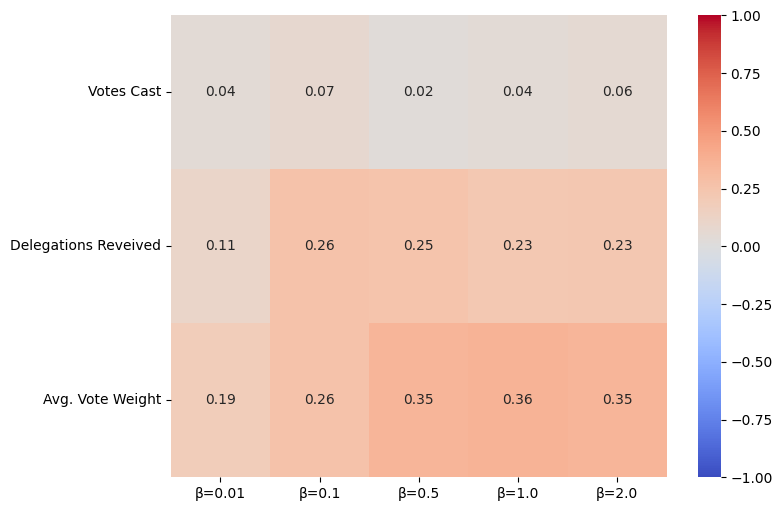

In [191]:
si_data_list = [SI_001_extracted, SI_01_extracted, SI_05_extracted, SI_1_extracted, SI_2_extracted]#, SI_5_extracted]
si_labels = ['β=0.01', 'β=0.1', 'β=0.5', 'β=1.0', 'β=2.0']#, 'β=5.0']

def compute_gov_si_correlations(gov_mappings, si_data_list, si_labels):
    kendall_results = []
    for si_data, si_label in zip(si_data_list, si_labels):
        si_scores = {entry['seed']: entry['avg_infected'] for entry in si_data}
        for feature_name, feature_mapping in gov_mappings:
            valid_addresses = feature_mapping.keys() & si_scores.keys()
            if valid_addresses:
                feature_values = [feature_mapping[address] for address in valid_addresses]
                si_values = [si_scores[address] for address in valid_addresses]
                kendall_corr = kendalltau(feature_values, si_values).statistic
                kendall_results.append((feature_name, si_label, kendall_corr))
    return kendall_results

def create_gov_si_heatmap(correlation_results, gov_mappings, si_labels, title):
    feature_names = [feature_name for feature_name, _ in gov_mappings]
    correlation_matrix = np.zeros((len(feature_names), len(si_labels)))
    for feature_name, si_label, correlation in correlation_results:
        feature_idx = feature_names.index(feature_name)
        si_idx = si_labels.index(si_label)
        correlation_matrix[feature_idx, si_idx] = correlation
    correlation_df = pd.DataFrame(correlation_matrix, index=feature_names, columns=si_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_df, annot=True, cmap='coolwarm', cbar=True, fmt='.2f', vmin=-1, vmax=1)
    plt.yticks(rotation=0)
    # plt.title(title)
    plt.show()

gov_si_kendall_results = compute_gov_si_correlations(gov_mappings, si_data_list, si_labels)
create_gov_si_heatmap(gov_si_kendall_results, gov_mappings, si_labels, "Kendall correlation (Governance vs SI)")

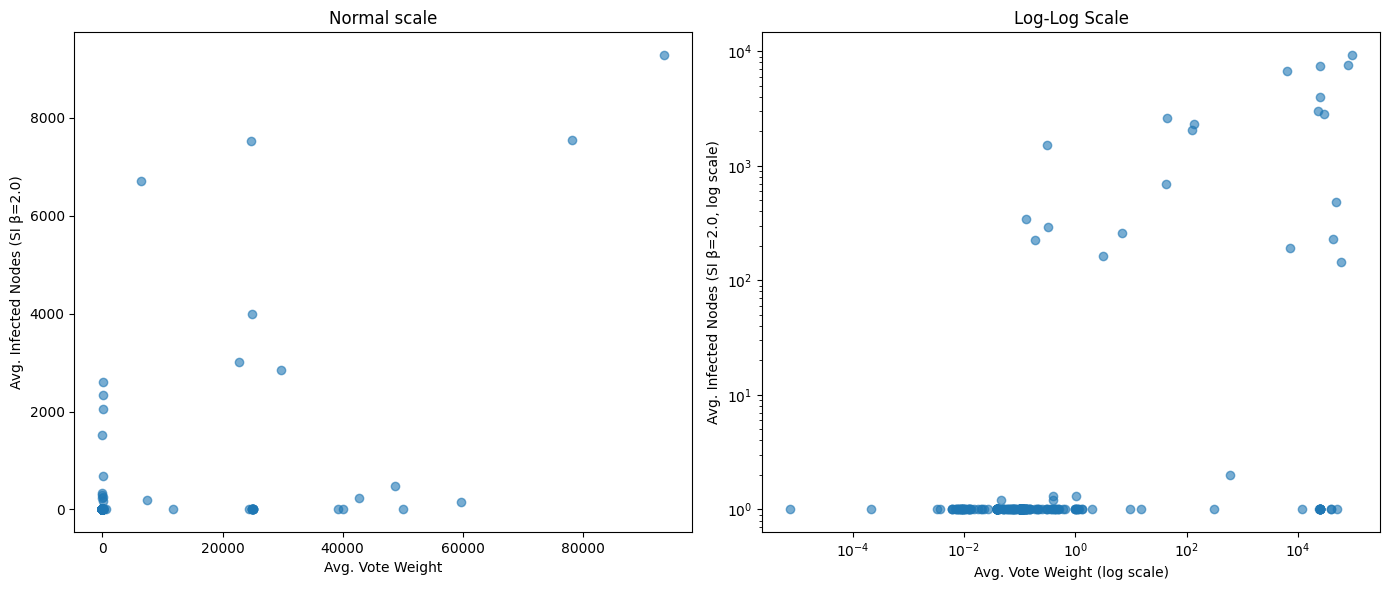

In [134]:
SI_2_mapping = {entry['seed']: entry['avg_infected'] for entry in SI_2_extracted}

valid_addresses = set(SI_2_mapping.keys()) & set(average_vote_weights_mapping.keys())

si2_vals = [SI_2_mapping[address] for address in valid_addresses]
votes_vals = [average_vote_weights_mapping[address] for address in valid_addresses]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(votes_vals, si2_vals, alpha=0.6)
axes[0].set_xlabel('Avg. Vote Weight')
axes[0].set_ylabel('Avg. Infected Nodes (SI β=2.0)')
axes[0].set_title('Normal scale')

axes[1].scatter(votes_vals, si2_vals, alpha=0.6)
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('Avg. Vote Weight (log scale)')
axes[1].set_ylabel('Avg. Infected Nodes (SI β=2.0, log scale)')
axes[1].set_title('Log-Log Scale')

plt.tight_layout()
plt.show()

In [199]:
from sklearn.metrics import ndcg_score
from scipy.stats import rankdata

def compute_ndcg(si_scores, si_label, other_feature_scores, other_feature_label, k=None):
    si_mapping = {entry['seed']: entry['avg_infected'] for entry in si_scores}
    common_addresses = set(si_mapping.keys()) & set(other_feature_scores.keys())

    si_scores = [si_mapping[addr] for addr in common_addresses]
    vote_weight_scores = [other_feature_scores[addr] for addr in common_addresses]

    si_ranks = rankdata(si_scores, method="average")
    vote_ranks = rankdata(vote_weight_scores, method="average")
    print(si_label)
    # ndcg = ndcg_score([vote_ranks], [si_ranks])
    # print(f'Ranked: {ndcg}')
    # ndcg = ndcg_score([si_ranks], [vote_ranks])
    # print(ndcg)

    ndcg = ndcg_score([vote_weight_scores], [si_scores])
    print(f'Raw: {ndcg}')
    # ndcg = ndcg_score([si_scores], [vote_weight_scores])
    # print(ndcg)

    # print(f"nDCG between {si_label} and {other_feature_label}: {ndcg:.4f}")

In [201]:
si_data_list = [SI_001_extracted, SI_01_extracted, SI_05_extracted, SI_1_extracted, SI_2_extracted]#, SI_5_extracted]
si_labels = ['β=0.01', 'β=0.1', 'β=0.5', 'β=1.0', 'β=2.0']#, 'β=5.0']

for si_data, si_label in zip(si_data_list, si_labels):
    compute_ndcg(si_data, si_label, average_vote_weights_mapping, 'Avg. Vote Weight')

β=0.01
Raw: 0.4994842350289368
β=0.1
Raw: 0.5628509605234575
β=0.5
Raw: 0.6543460105325756
β=1.0
Raw: 0.65162450395311
β=2.0
Raw: 0.8050197016935742


In [179]:
def dcg(relevance_scores, k):
    relevance_scores = np.asfarray(relevance_scores)[:k]
    return np.sum(relevance_scores / np.log2(np.arange(2, k + 2)))

def ndcg(si_outcome: list, vote_weights: dict, k: int = None):
    seeds_with_vote = [entry for entry in si_outcome if entry['seed'] in vote_weights]
    
    if not seeds_with_vote:
        return 0
    
    sorted_seeds = sorted(seeds_with_vote, key=lambda x: x['avg_infected'], reverse=True)
    
    rel_pred = [vote_weights[entry['seed']] for entry in sorted_seeds]
    
    ideal_sorted = sorted(seeds_with_vote, key=lambda x: vote_weights[x['seed']], reverse=True)
    rel_ideal = [vote_weights[entry['seed']] for entry in ideal_sorted]

    k = k or len(rel_pred)

    dcg_val = dcg(rel_pred, k)
    idcg_val = dcg(rel_ideal, k)

    return dcg_val / idcg_val if idcg_val > 0 else 0

for si_data in si_data_list:
    print(ndcg(si_data, average_vote_weights_mapping))

0.5004115910158172
0.5307080577780532
0.633300319452519
0.632241776765318
0.809110622964268
0.8017883849825919


## cToken analysis

In [121]:
combined_tokens = {
    'USDC': ['cUSDCv3', 'cArbUSDC'],
    'USDT': ['cUSDTv3', 'cPolUSDT', 'cArbUSDT'],
    'WETH': ['cWETHv3', 'cArbWETH']
}

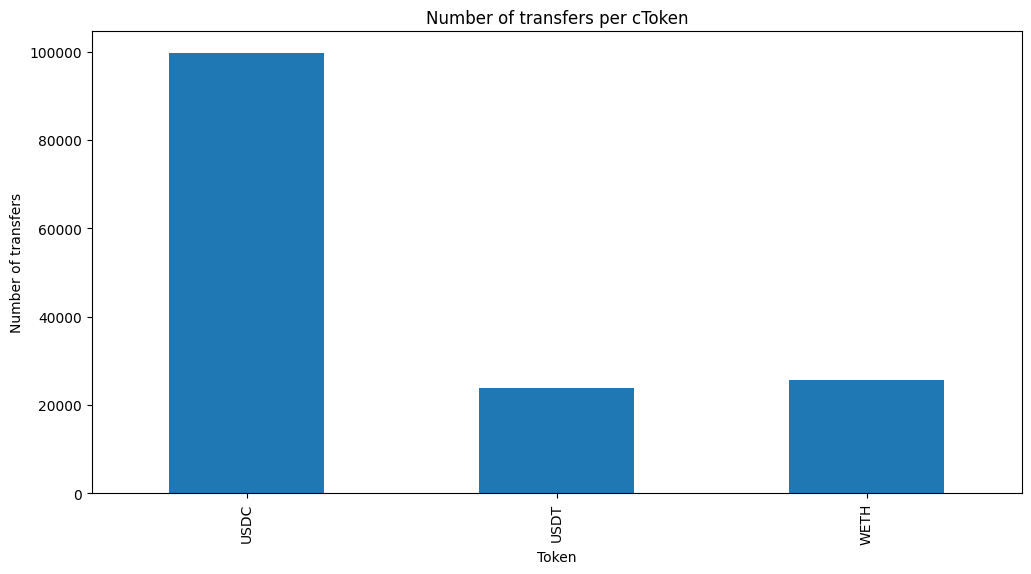

In [130]:
transfers_per_token = cToken_df.groupby('token').size()

transfers_per_token = pd.Series({token: transfers_per_token.loc[names].sum() for token, names in combined_tokens.items()})

plt.figure(figsize=(12, 6))
transfers_per_token.plot(kind='bar')
plt.xlabel('Token')
plt.ylabel('Number of transfers')
plt.title('Number of transfers per cToken')
plt.show()

C:\Users\Sam\AppData\Local\Temp\ipykernel_4328\3939281894.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cToken_df['date'] = pd.to_datetime(cToken_df['timestamp'], unit='s')
C:\Users\Sam\AppData\Local\Temp\ipykernel_4328\3939281894.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cToken_df['date'] = cToken_df['date'].dt.date


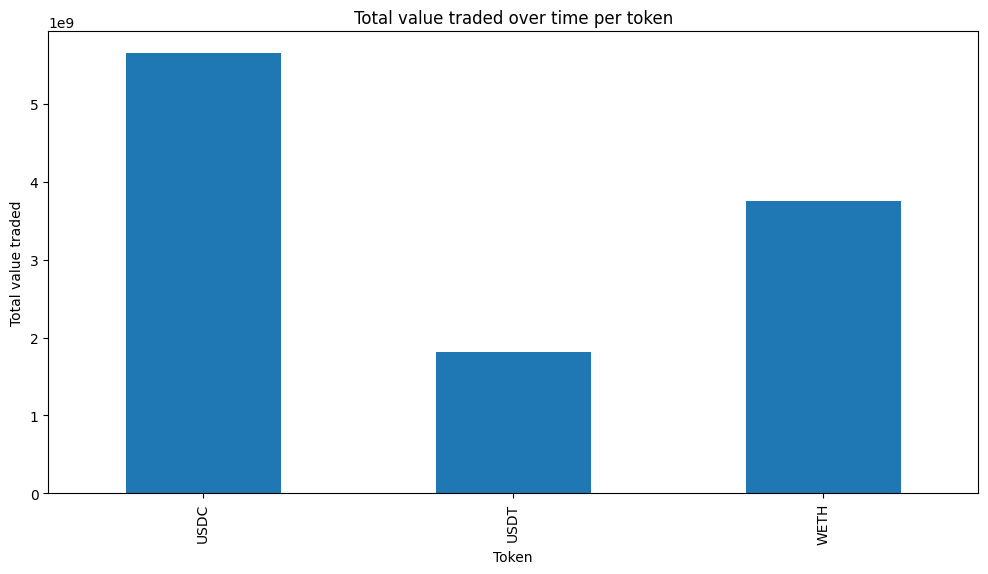

In [127]:
price_data = pd.read_csv('data/WETH_daily_USD.csv', parse_dates=['snapped_at'])

price_data['date'] = pd.to_datetime(price_data['snapped_at']).dt.date
cToken_df['date'] = pd.to_datetime(cToken_df['timestamp'], unit='s')
cToken_df['date'] = cToken_df['date'].dt.date

cToken_df2 = cToken_df.merge(price_data[['date', 'price']], on='date', how='left')

tokens_to_multiply = ['cWETHv3', 'cArbWETH']

cToken_df2['value_traded'] = cToken_df2.apply(
    lambda row: row['value'] * row['price'] if row['token'] in tokens_to_multiply else row['value'], axis=1
)

transfers_over_time_per_token = cToken_df2.groupby('token')['value_traded'].sum()

transfers_over_time_per_token = pd.Series({token: transfers_over_time_per_token.loc[names].sum() for token, names in combined_tokens.items()})

plt.figure(figsize=(12, 6))
transfers_over_time_per_token.plot(kind='bar')
plt.xlabel('Token')
plt.ylabel('Total value traded')
plt.title('Total value traded over time per token')
plt.show()

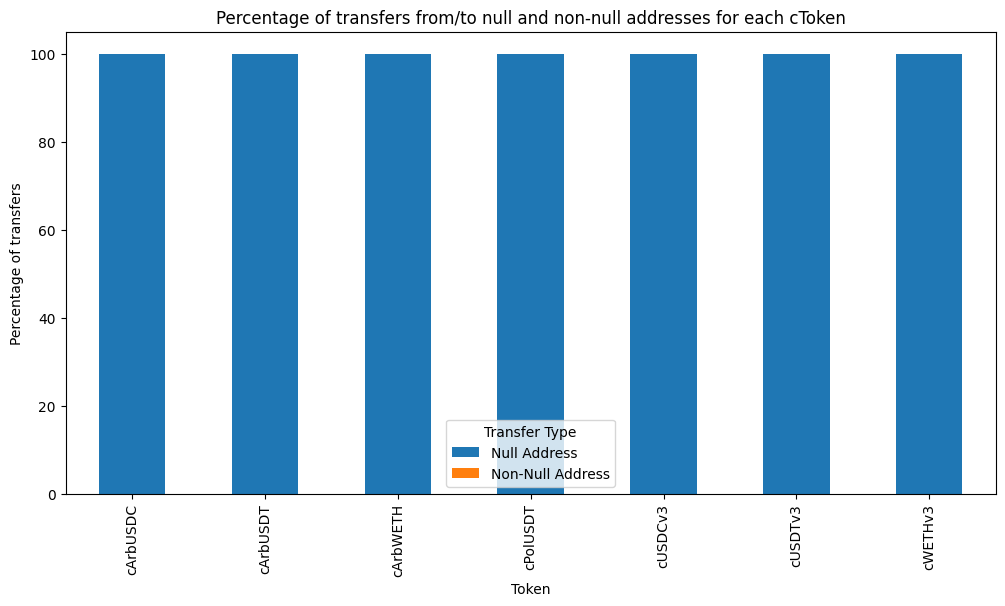

In [131]:
null_address = '0x0000000000000000000000000000000000000000'

total_transfers_per_token = cToken_df['token'].value_counts()

null_address_transfers_per_token = cToken_df[(cToken_df['from'].str.lower() == null_address) | (cToken_df['to'].str.lower() == null_address)].groupby('token').size()

percentage_null_address_transfers = (null_address_transfers_per_token / total_transfers_per_token) * 100

percentage_non_null_address_transfers = 100 - percentage_null_address_transfers

percentage_transfers_df = pd.DataFrame({
    'Null Address': percentage_null_address_transfers,
    'Non-Null Address': percentage_non_null_address_transfers
}).fillna(0)

percentage_transfers_df.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.xlabel('Token')
plt.ylabel('Percentage of transfers')
plt.title('Percentage of transfers from/to null and non-null addresses for each cToken')
plt.legend(title='Transfer Type')
plt.show()

## Venn diagrams

<Axes: >

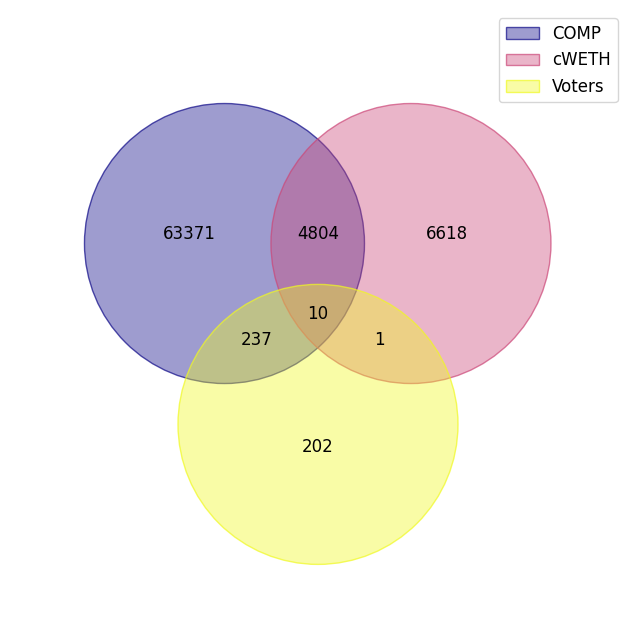

In [ ]:
subsets = {
    "COMP": set(G_comp_nodes),
    "cWETH": set(G_cToken_nodes)
}

venn(subsets, fmt="{size}", cmap='plasma', fontsize=12)

<Axes: >

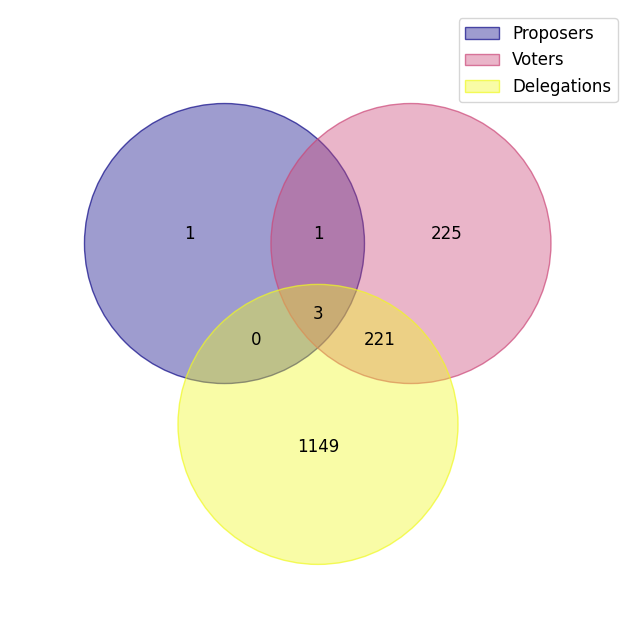

In [29]:
subsets = {
    "Proposers": proposers,
    "Voters": voters,
    "Delegations": delegators
}

venn(subsets, fmt="{size}", cmap='plasma', fontsize=12)

<Axes: >

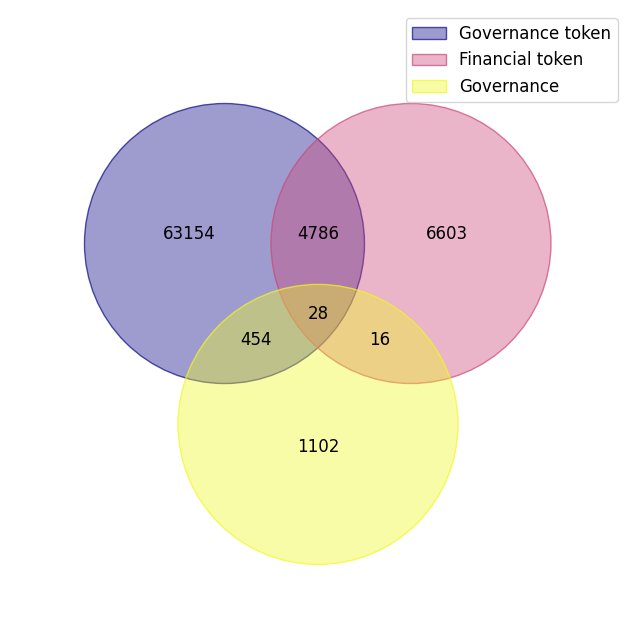

In [30]:
subsets = {
    "Governance token": G_comp_nodes,
    "Financial token": G_cToken_nodes,
    "Governance": (proposers | voters | delegators)
}

venn(subsets, fmt="{size}", cmap='plasma', fontsize=12)

## Community detection

### VI, NMI, AMI & ARI

In [ ]:
def entropy(labels):
    total = len(labels)
    counts = Counter(labels)
    
    return -sum((count/total) * log2(count/total) for count in counts.values())

def mutual_information(x, y):
    total = len(x)
    counter_x = Counter(x)
    counter_y = Counter(y)
    joint_counter = Counter(zip(x, y))
    mi = 0.0
    
    for (x_val, y_val), joint_count in joint_counter.items():
        px = counter_x[x_val] / total
        py = counter_y[y_val] / total
        pxy = joint_count / total
        mi += pxy * log2(pxy / (px * py))
    
    return mi

def variation_of_information(x, y):
    return entropy(x) + entropy(y) - 2 * mutual_information(x, y)

def run_leiden_iterations(graph, n_iterations=10, resolution=1.0):
    memberships = []
    
    for i in range(n_iterations):
        partition = la.find_partition(
            graph,
            la.ModularityVertexPartition,
            weights='weight'
        )
        print(i, partition.modularity)
        
        memberships.append(partition.membership)
    
    return memberships

def compute_vi_nmi_ami_ari(memberships):
    n = len(memberships)
    vi_scores = np.zeros((n, n))
    nmi_scores = np.zeros((n, n))
    ami_scores = np.zeros((n, n))
    ari_scores = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i, n):
            vi = variation_of_information(memberships[i], memberships[j])
            nmi = normalized_mutual_info_score(memberships[i], memberships[j])
            ami = adjusted_mutual_info_score(memberships[i], memberships[j])
            ari = adjusted_rand_score(memberships[i], memberships[j])
            
            vi_scores[i, j] = vi_scores[j, i] = vi
            nmi_scores[i, j] = nmi_scores[j, i] = nmi
            ami_scores[i, j] = ami_scores[j, i] = ami
            ari_scores[i, j] = ari_scores[j, i] = ari
    return vi_scores, nmi_scores, ami_scores, ari_scores

In [ ]:
G_comp_igraph = ig.Graph.from_networkx(G_comp, vertex_attr_hashable='name')
G_comp_count_igraph = ig.Graph.from_networkx(G_comp_count, vertex_attr_hashable='name')

In [ ]:
n_iterations = 100
resolution = 1.0
memberships = run_leiden_iterations(G_comp_igraph, n_iterations, resolution)

vi_scores, nmi_scores, ami_scores, ari_scores = compute_vi_nmi_ami_ari(memberships)

avg_vi = np.mean(vi_scores[np.triu_indices(n_iterations, k=1)])
avg_nmi = np.mean(nmi_scores[np.triu_indices(n_iterations, k=1)])
avg_ami = np.mean(ami_scores[np.triu_indices(n_iterations, k=1)])
avg_ari = np.mean(ari_scores[np.triu_indices(n_iterations, k=1)])

print(f"Average VI: {avg_vi:.4f}")
print(f"Average NMI: {avg_nmi:.4f}")
print(f"Average AMI: {avg_ami:.4f}")
print(f"Average ARI: {avg_ari:.4f}")

In [ ]:
n_iterations = 100
resolution = 1.0
memberships = run_leiden_iterations(G_comp_count_igraph, n_iterations, resolution)

vi_scores, nmi_scores, ami_scores, ari_scores = compute_vi_nmi_ami_ari(memberships)

avg_vi = np.mean(vi_scores[np.triu_indices(n_iterations, k=1)])
avg_nmi = np.mean(nmi_scores[np.triu_indices(n_iterations, k=1)])
avg_ami = np.mean(ami_scores[np.triu_indices(n_iterations, k=1)])
avg_ari = np.mean(ari_scores[np.triu_indices(n_iterations, k=1)])

print(f"Average VI: {avg_vi:.4f}")
print(f"Average NMI: {avg_nmi:.4f}")
print(f"Average AMI: {avg_ami:.4f}")
print(f"Average ARI: {avg_ari:.4f}")

### Regular Leiden

#### Basic analysis

In [42]:
G_comp_count_igraph = ig.Graph.from_networkx(G_comp_count, vertex_attr_hashable='name')

G_comp_count_igraph_components = G_comp_count_igraph.connected_components(mode="weak")
G_comp_count_igraph_largest_wcc = G_comp_count_igraph_components.giant()

partition = la.find_partition(G_comp_count_igraph_largest_wcc, la.ModularityVertexPartition, weights='weight')

print(len(partition), partition.modularity)

119 0.7250755564056693


In [ ]:
print(len(G_comp_igraph.vs), len(G_comp_count_igraph_largest_wcc.vs))

74334 68422


In [ ]:
non_WCC_nodes = set(G_comp_igraph.vs['name']) - set(G_comp_count_igraph_largest_wcc.vs['name'])

In [23]:
print(len(non_WCC_nodes))
print(len(non_WCC_nodes & CEX))
print(len(non_WCC_nodes & CA))
print(len(non_WCC_nodes & EOA & all_proposers_voters_delegators_in_G_comp))
print(len(non_WCC_nodes & (EOA - all_proposers_voters_delegators_in_G_comp - CEX)))

5912
6
120
1
5785


In [ ]:
G_W_communities = 0
G_C_communities = 0

G_W_modularity = 0
G_C_modularity = 0

for i in range(100):
    print(i)
    
    p1 = la.find_partition(G_comp_igraph, la.ModularityVertexPartition, weights='weight')
    p2 = la.find_partition(G_comp_count_igraph, la.ModularityVertexPartition, weights='weight')
    
    G_W_communities += len(p1)
    G_C_communities += len(p2)
    
    G_W_modularity += p1.modularity
    G_C_modularity += p2.modularity
    
average_G_W_size = G_W_communities / 100
average_G_C_size = G_C_communities / 100

average_G_W_mod = G_W_modularity / 100
average_G_C_mod = G_C_modularity / 100

print(f'Communities: G_W: {average_G_W_size}, G_C: {average_G_C_size}')
print(f'Modularity: G_W: {average_G_W_mod}, G_C: {average_G_C_mod}')

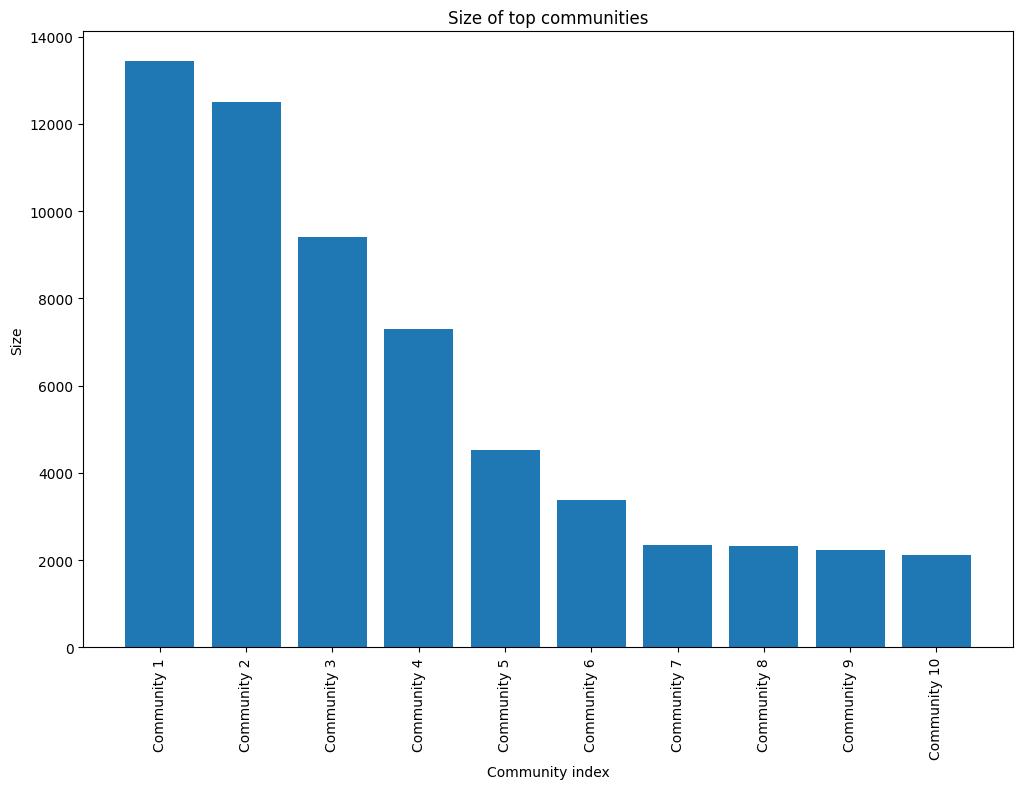

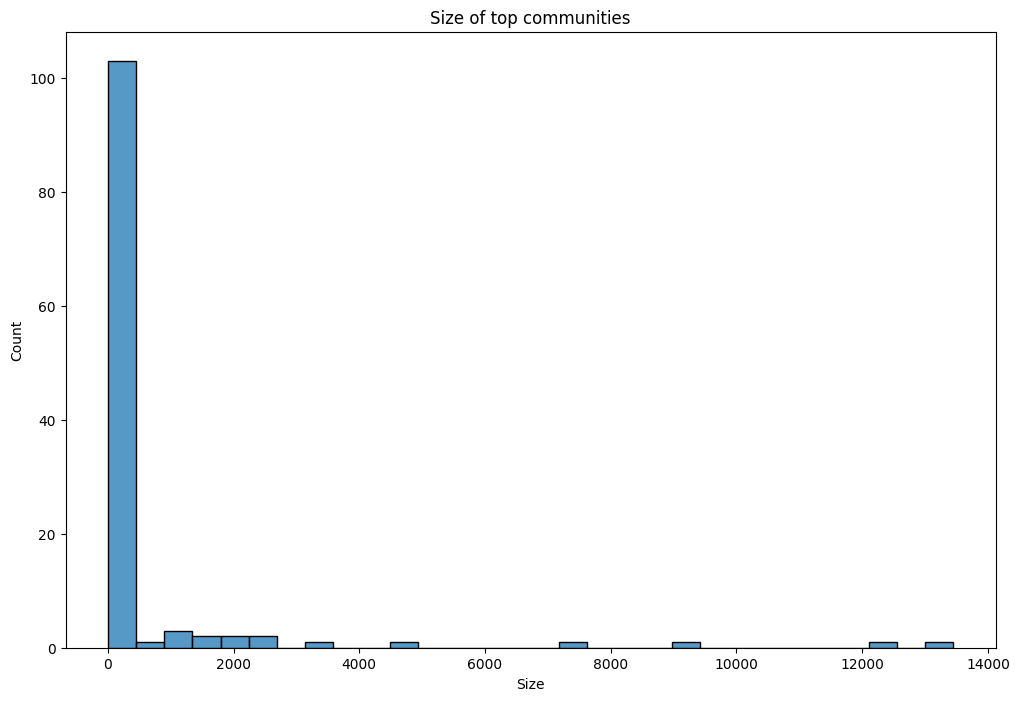

In [43]:
community_sizes = [len(c) for c in partition]

sorted_indices = sorted(range(len(community_sizes)), key=lambda i: community_sizes[i], reverse=True)

sorted_communities = [partition[i] for i in sorted_indices]

top_communities = sorted_communities[:10]

top_communities_sizes = [len(community) for community in top_communities]

plt.figure(figsize=(12, 8))
plt.bar(range(len(top_communities)), top_communities_sizes)
plt.xlabel('Community index')
plt.ylabel('Size')
plt.title('Size of top communities')
plt.xticks(range(len(top_communities)), [f'Community {i+1}' for i in range(len(top_communities))], rotation=90)
plt.show()

all_communities_sizes = [len(community) for community in sorted_communities]
log_bins = np.logspace(np.log10(min(all_communities_sizes)), np.log10(max(all_communities_sizes)), 30)

plt.figure(figsize=(12, 8))
sns.histplot(all_communities_sizes, bins=30)
# plt.yscale('log')
# sns.histplot(all_communities_sizes, bins=log_bins)
# plt.xscale('log')
plt.xlabel('Size')
plt.ylabel('Count')
plt.title('Size of top communities')
plt.show()

communities_with_ids = [
    {G_comp_count_igraph_largest_wcc.vs[idx]["name"] for idx in community} for community in top_communities
]

In [15]:
community_distribution = {
    'Economic': [],
    'Governance': [],
    'Both': [],
    'None': []
}

only_economic_users_in_G_wcc = only_economic_users_in_G_comp & set(G_comp_count_igraph_largest_wcc.vs["name"])
only_voters_in_G_wcc = only_voters_in_G_comp & set(G_comp_count_igraph_largest_wcc.vs["name"])
both_economic_and_governance_users_in_G_wcc = both_economic_and_governance_users & set(G_comp_count_igraph_largest_wcc.vs["name"])
all_economic_users_in_G_wcc = all_economic_users_in_G_comp & set(G_comp_count_igraph_largest_wcc.vs["name"])
all_voters_in_G_wcc = all_voters_in_G_comp & set(G_comp_count_igraph_largest_wcc.vs["name"])

for community in communities_with_ids:
    economic_count = len(only_economic_users_in_G_wcc & community)
    governance_count = len(only_voters_in_G_wcc & community)
    both_count = len(both_economic_and_governance_users_in_G_wcc & community)
    none_count = len(community) - economic_count - governance_count - both_count
    
    community_distribution['Economic'].append(economic_count)
    community_distribution['Governance'].append(governance_count)
    community_distribution['Both'].append(both_count)
    community_distribution['None'].append(none_count)

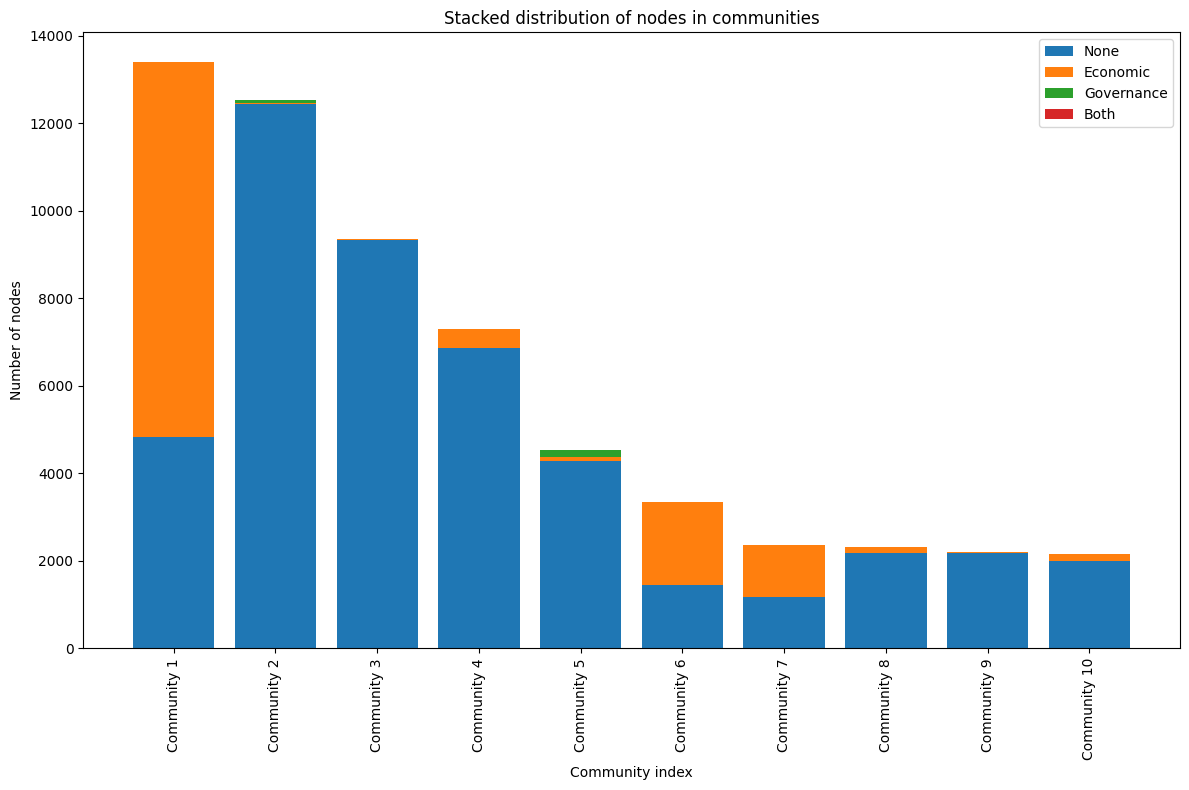

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

bar_width = 0.8
index = np.arange(len(communities_with_ids))

economic_array = np.array(community_distribution['Economic'])
governance_array = np.array(community_distribution['Governance'])
both_array = np.array(community_distribution['Both'])
none_array = np.array(community_distribution['None'])

bar1 = ax.bar(index, none_array, bar_width, label='None')
bar2 = ax.bar(index, economic_array, bar_width, bottom=none_array, label='Economic')
bar3 = ax.bar(index, governance_array, bar_width, bottom=none_array + economic_array, label='Governance')
bar4 = ax.bar(index, both_array, bar_width, bottom=none_array + economic_array + governance_array, label='Both')

ax.set_xlabel('Community index')
ax.set_ylabel('Number of nodes')
ax.set_title('Stacked distribution of nodes in communities')
ax.set_xticks(index)
ax.set_xticklabels([f'Community {i+1}' for i in range(len(communities_with_ids))], rotation=90)
ax.legend()

plt.tight_layout()
plt.show()

In [17]:
community_distribution_2 = {
    'EOA gov': [],
    'EOA non gov': [],
    'CEX': [],
    'CA': []
}

total_EOA_gov_percentage = 0
total_EOA_non_gov_percentage = 0
total_CEX_percentage = 0
total_CA_percentage = 0

EOA_gov_percentages = []
EOA_non_gov_percentages = []
CEX_percentages = []
CA_percentages = []

# 'Voters': [i['avg_infected'] for i in dataset if i['seed'] in EOA and i['seed'] in all_proposers_voters_delegators_in_G_aave and i['seed'] not in CEX],
# 'Non-voters': [i['avg_infected'] for i in dataset if i['seed'] in EOA and i['seed'] not in all_proposers_voters_delegators_in_G_aave and i['seed'] not in CEX],
# 'CA': [i['avg_infected'] for i in dataset if i['seed'] in CA],
# 'CEX': [i['avg_infected'] for i in dataset if i['seed'] in CEX],

id = 1
for community in communities_with_ids:
    EOA_gov_count = len(community & (EOA & all_proposers_voters_delegators_in_G_comp))
    EOA_non_gov_count = len(community & (EOA - all_proposers_voters_delegators_in_G_comp - CEX))
    CEX_count = len(community & CEX)
    CA_count = len(community & CA)
    
    community_distribution_2['EOA gov'].append(EOA_gov_count)
    community_distribution_2['EOA non gov'].append(EOA_non_gov_count)
    community_distribution_2['CEX'].append(CEX_count)
    community_distribution_2['CA'].append(CA_count)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

bar_width = 0.8
index = np.arange(len(communities_with_ids))

EOA_gov_array = np.array(community_distribution_2['EOA gov'])
EOA_non_gov_array = np.array(community_distribution_2['EOA non gov'])
CEX_array = np.array(community_distribution_2['CEX'])
CA_array = np.array(community_distribution_2['CA'])

bar1 = ax.bar(index, EOA_non_gov_array, bar_width, label='EOA non-governance')
bar2 = ax.bar(index, EOA_gov_array, bar_width, bottom=EOA_non_gov_array, label='EOA governance')
bar3 = ax.bar(index, CA_array + CEX_array, bar_width, bottom=EOA_non_gov_array + EOA_gov_array, label='Infrastructure')
# bar3 = ax.bar(index, CEX_array, bar_width, bottom=EOA_non_gov_array + EOA_gov_array, label='CEX')
# bar4 = ax.bar(index, CA_array, bar_width, bottom=EOA_non_gov_array + EOA_gov_array + CEX_array, label='CA')

ax.set_xlabel('Community index')
ax.set_ylabel('Number of nodes')
# ax.set_title('Stacked distribution of nodes in communities')
ax.set_xticks(index)
ax.set_xticklabels([f'{i+1}' for i in range(len(communities_with_ids))])
ax.legend()

plt.tight_layout()
plt.show()

NameError: name 'EOA' is not defined

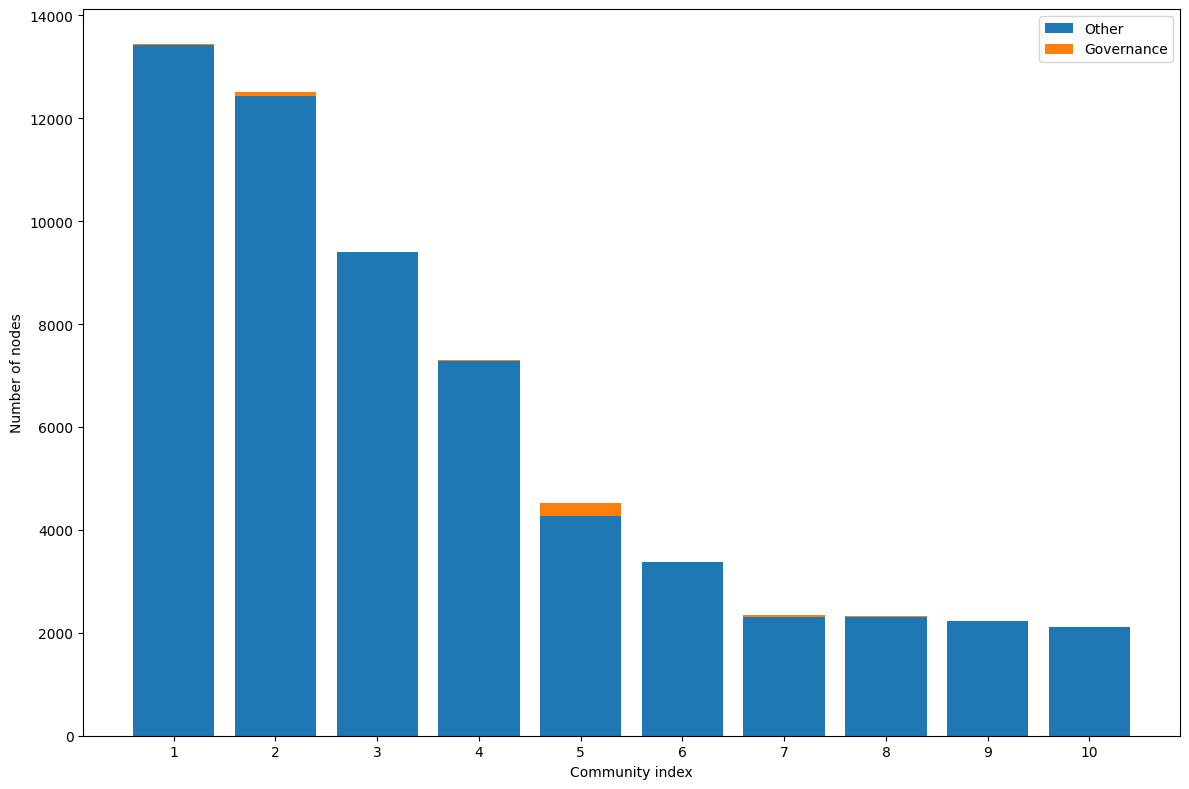

In [44]:
community_distribution_3 = {
    'gov': [],
    'other': []
}

total_gov_percentage = 0
total_other_percentage = 0

gov_percentages = []
other_percentages = []

id = 1
for community in communities_with_ids:
    gov_count = len(community & all_proposers_voters_delegators_in_G_comp)
    other_count = len(community) - gov_count
    
    community_distribution_3['gov'].append(gov_count)
    community_distribution_3['other'].append(other_count)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

bar_width = 0.8
index = np.arange(len(communities_with_ids))

gov_array = np.array(community_distribution_3['gov'])
other_array = np.array(community_distribution_3['other'])

bar1 = ax.bar(index, other_array, bar_width, label='Other')
bar2 = ax.bar(index, gov_array, bar_width, bottom=other_array, label='Governance')

ax.set_xlabel('Community index')
ax.set_ylabel('Number of nodes')
# ax.set_title('Distribution of nodes per community')
ax.set_xticks(index)
ax.set_xticklabels([f'{i+1}' for i in range(len(communities_with_ids))])
# ax.set_xticklabels([f'Community {i+1}' for i in range(len(communities_with_ids))], rotation=90)
ax.legend()

plt.tight_layout()
plt.show()

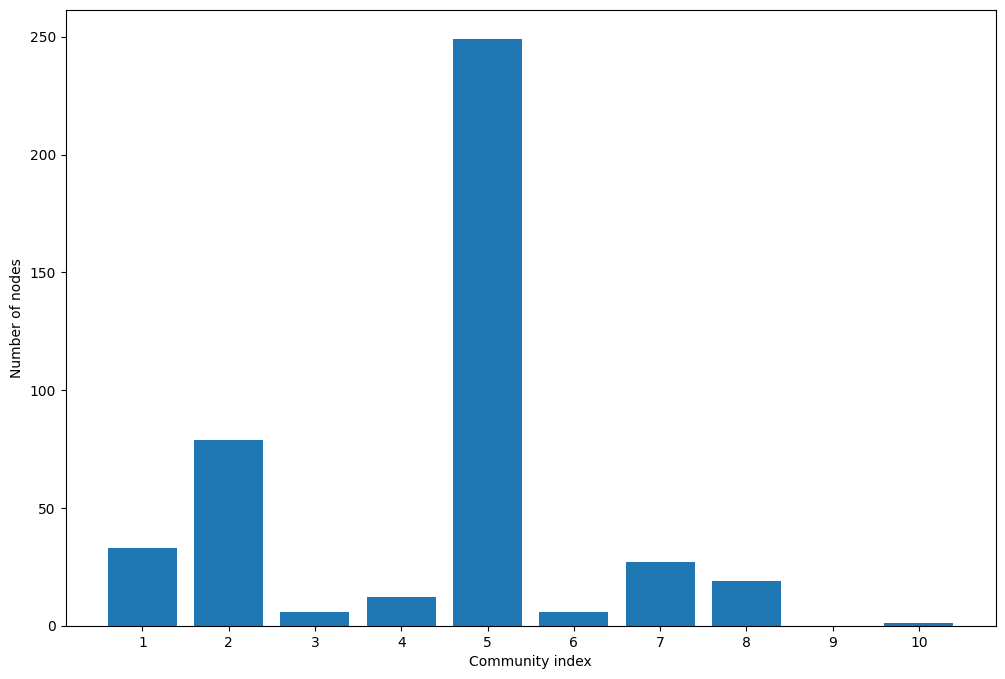

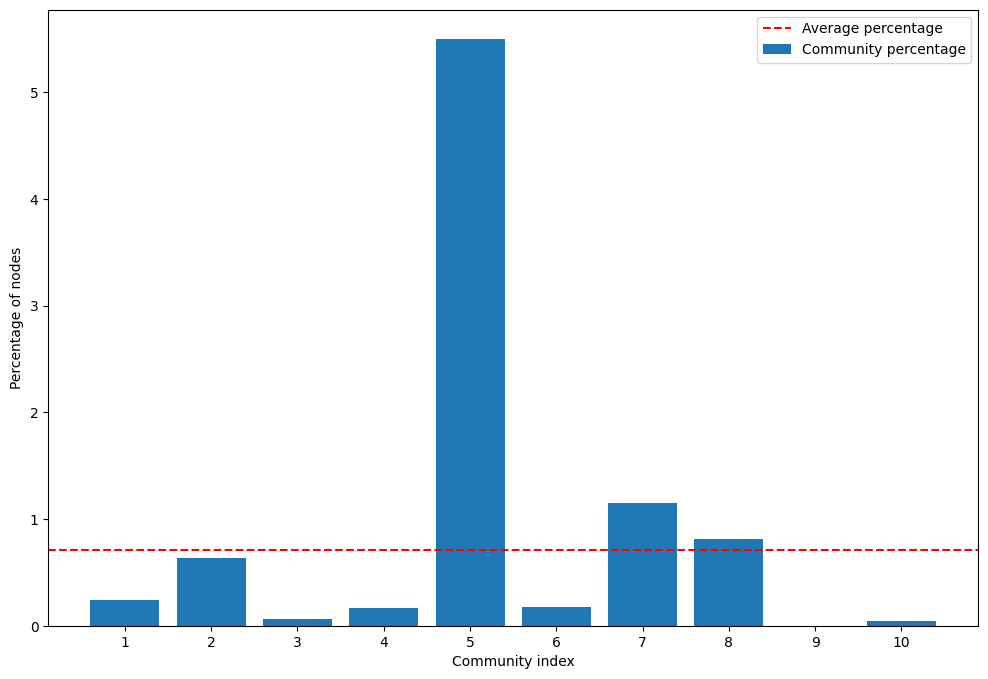

In [46]:
# gov_array = np.array(community_distribution_2['EOA gov'])
# CEX_array = np.array(community_distribution_2['CEX'])
# CA_array = np.array(community_distribution_2['CA'])

total_gov_percentage = (len(all_proposers_voters_delegators_in_G_comp) / len(G_comp_nodes)) * 100

community_gov_percentages = []

for i in range(len(gov_array)):
    gov_percentage = (gov_array[i] / len(communities_with_ids[i])) * 100
    community_gov_percentages.append(gov_percentage)

plt.figure(figsize=(12, 8))
plt.bar(range(len(gov_array)), gov_array)#, color='orange')
plt.xlabel('Community index')
plt.ylabel('Number of nodes')
# plt.title('Percentage of governance nodes per community vs total governance percentage')
# plt.legend()
plt.xticks(range(len(top_communities)), [f'{i+1}' for i in range(len(top_communities))])
plt.show()

plt.figure(figsize=(12, 8))
plt.bar(range(len(top_communities)), community_gov_percentages, label='Community percentage')
plt.axhline(y=total_gov_percentage, color='r', linestyle='--', label='Average percentage')
plt.xlabel('Community index')
plt.ylabel('Percentage of nodes')
# plt.title('Percentage of governance nodes per community vs total governance percentage')
plt.legend()
plt.xticks(range(len(top_communities)), [f'{i+1}' for i in range(len(top_communities))])
plt.show()

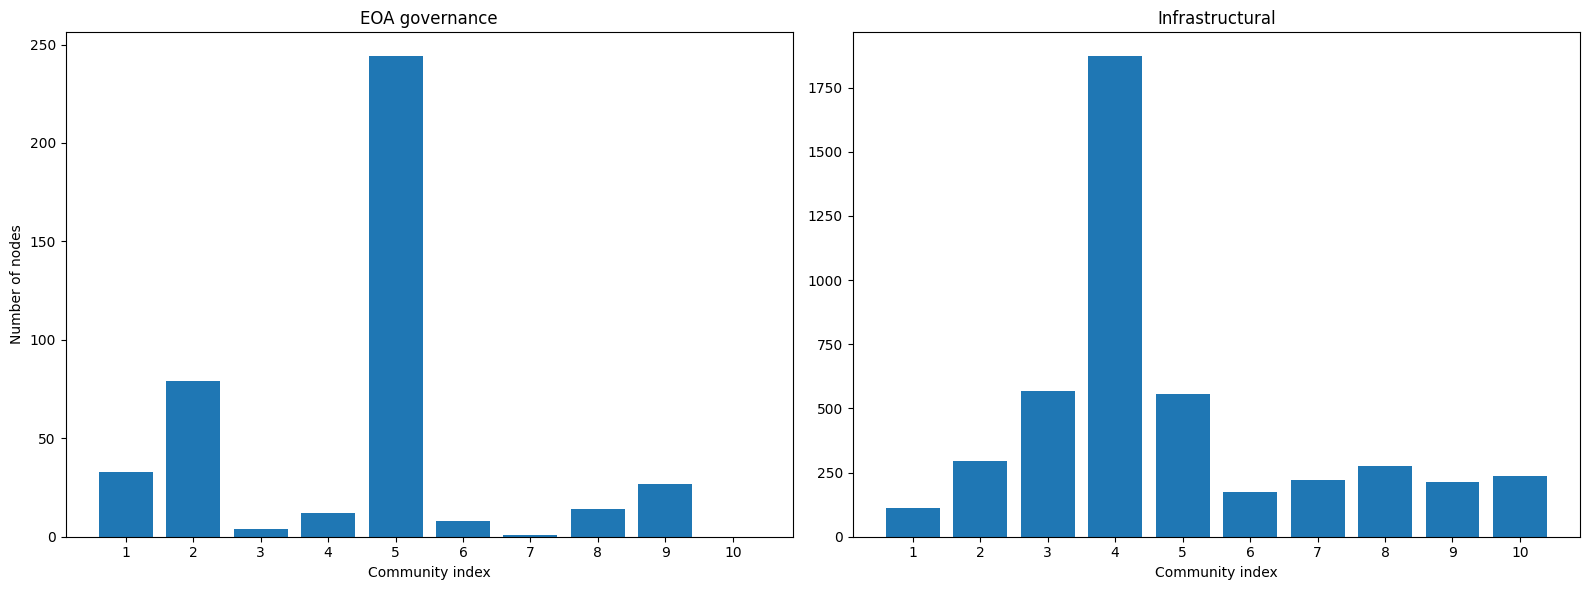

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

axs[0].bar(range(len(EOA_gov_array)), EOA_gov_array)
# axs[0].axhline(y=total_EOA_gov_percentage, color='r', linestyle='--', label='Total EOA percentage')
axs[0].set_xlabel('Community index')
axs[0].set_ylabel('Number of nodes')
axs[0].set_title('EOA governance')
# axs[0].legend()
axs[0].set_xticks(range(len(top_communities)))
axs[0].set_xticklabels([f'{i+1}' for i in range(len(top_communities))])

infra_array = CA_array + CEX_array
axs[1].bar(range(len(infra_array)), infra_array)
# axs[1].axhline(y=total_CEX_percentage + total_CA_percentage, color='r', linestyle='--', label='Total percentage')
axs[1].set_xlabel('Community index')
axs[1].set_title('Infrastructural')
# axs[1].legend()
axs[1].set_xticks(range(len(top_communities)))
axs[1].set_xticklabels([f'{i+1}' for i in range(len(top_communities))])

plt.tight_layout()
plt.show()

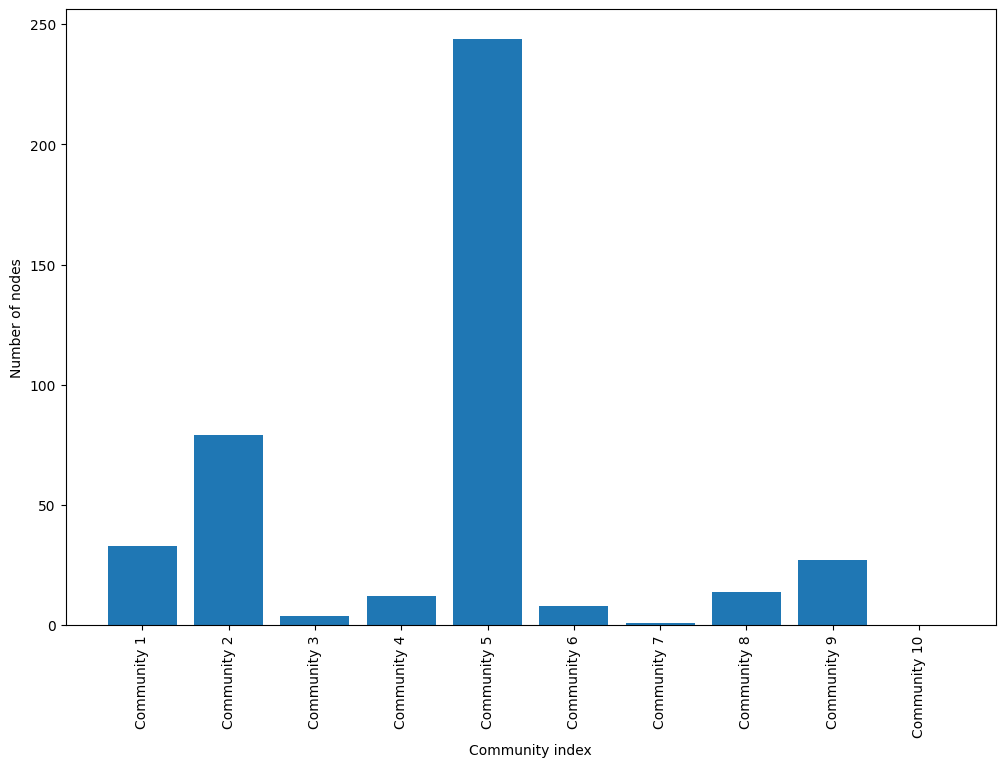

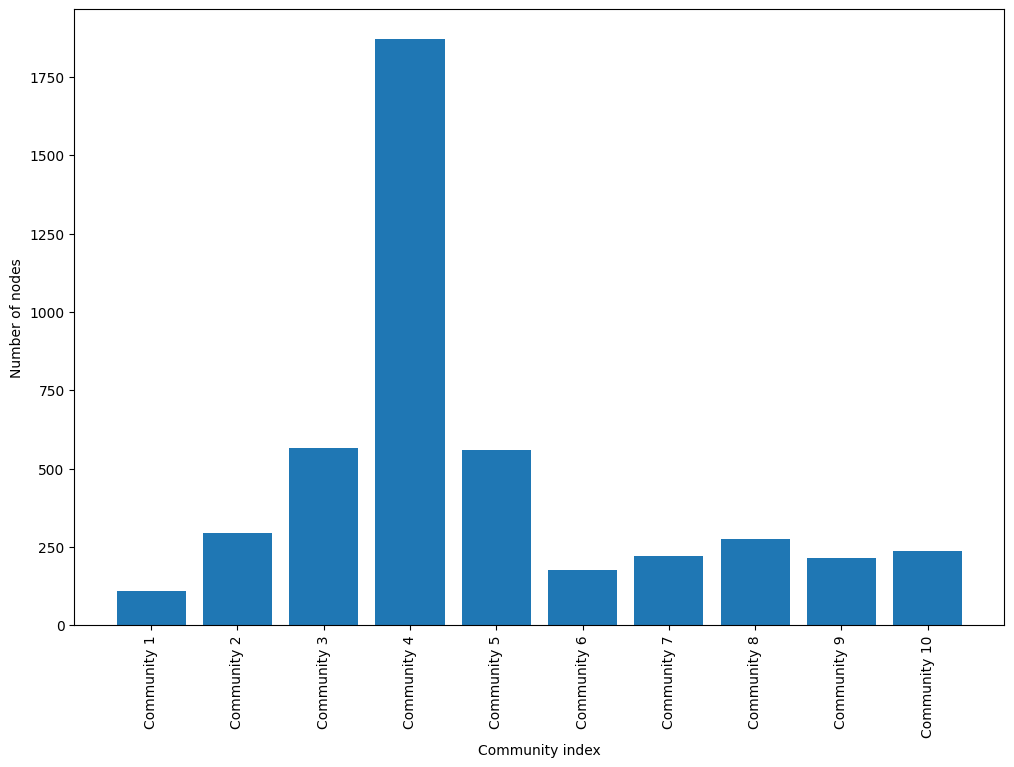

In [47]:
plt.figure(figsize=(12, 8))
plt.bar(range(len(EOA_gov_array)), EOA_gov_array)#, color='orange')
plt.xlabel('Community index')
plt.ylabel('Number of nodes')
# plt.title('Percentage of governance nodes per community vs total governance percentage')
# plt.legend()
plt.xticks(range(len(top_communities)), [f'Community {i+1}' for i in range(len(top_communities))], rotation=90)
plt.show()

plt.figure(figsize=(12, 8))
plt.bar(range(len(infra_array)), infra_array)#, color='green')
plt.xlabel('Community index')
plt.ylabel('Number of nodes')
# plt.title('Percentage of economic nodes per community vs total economic percentage')
# plt.legend()
plt.xticks(range(len(top_communities)), [f'Community {i+1}' for i in range(len(top_communities))], rotation=90)
plt.show()

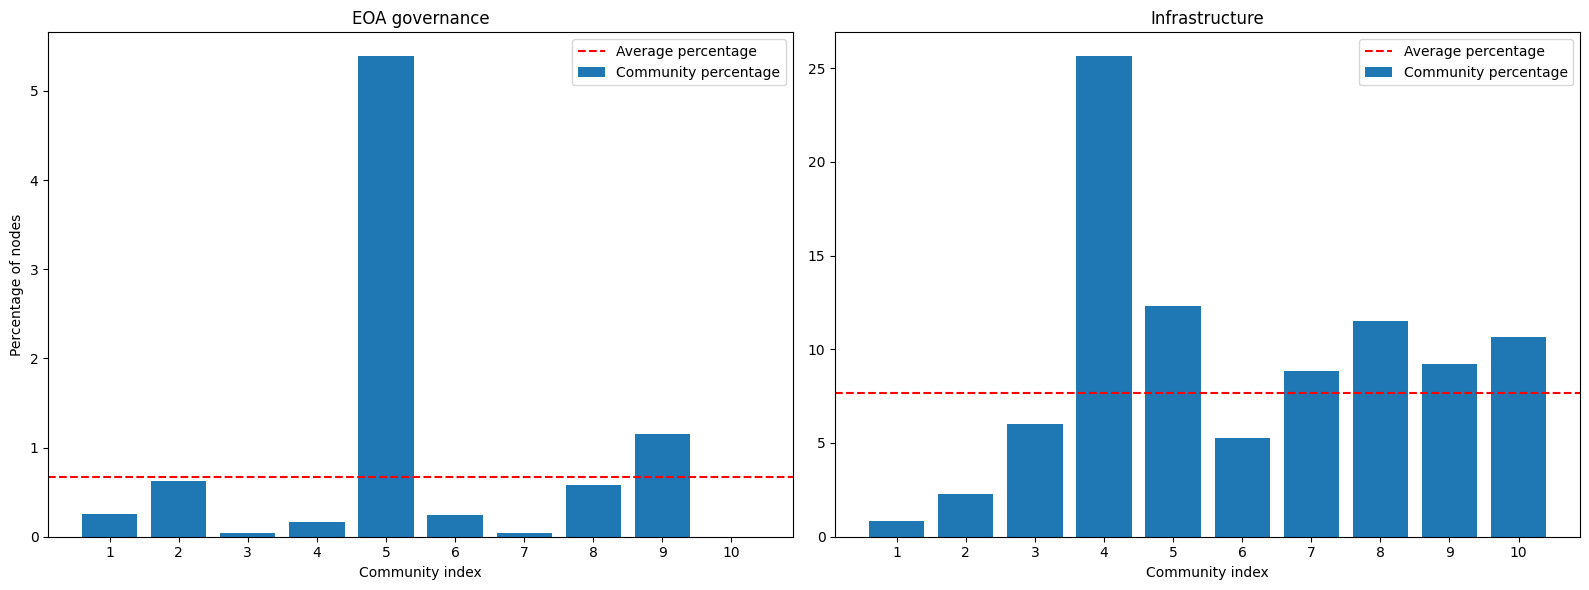

In [48]:
EOA_gov_array = np.array(community_distribution_2['EOA gov'])
CEX_array = np.array(community_distribution_2['CEX'])
CA_array = np.array(community_distribution_2['CA'])

total_EOA_gov_percentage = (len(EOA & all_proposers_voters_delegators_in_G_comp) / len(G_comp_nodes)) * 100
total_CEX_percentage = (len(CEX & G_comp_nodes) / len(G_comp_nodes)) * 100
total_CA_percentage = (len(CA & G_comp_nodes) / len(G_comp_nodes)) * 100

community_EOA_gov_percentages = []
community_CEX_percentages = []
community_CA_percentages = []

for i in range(len(EOA_gov_array)):
    EOA_gov_percentage = (EOA_gov_array[i] / len(communities_with_ids[i])) * 100
    community_EOA_gov_percentages.append(EOA_gov_percentage)
    
    CEX_percentage = (CEX_array[i] / len(communities_with_ids[i])) * 100
    community_CEX_percentages.append(CEX_percentage)
    
    CA_percentage = (CA_array[i] / len(communities_with_ids[i])) * 100
    community_CA_percentages.append(CA_percentage)

fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharex=True)
# fig, axs = plt.subplots(1, 3, figsize=(20, 6), sharex=True)

axs[0].bar(range(len(top_communities)), community_EOA_gov_percentages, label='Community percentage')
axs[0].axhline(y=total_EOA_gov_percentage, color='r', linestyle='--', label='Average percentage')
axs[0].set_xlabel('Community index')
axs[0].set_ylabel('Percentage of nodes')
axs[0].set_title('EOA governance')
axs[0].legend()
axs[0].set_xticks(range(len(top_communities)))
axs[0].set_xticklabels([f'{i+1}' for i in range(len(top_communities))])

CEX_CA_percentages = [community_CA_percentages[i] + community_CEX_percentages[i] for i in range(len(community_CEX_percentages))]
axs[1].bar(range(len(top_communities)), CEX_CA_percentages, label='Community percentage')
axs[1].axhline(y=total_CEX_percentage + total_CA_percentage, color='r', linestyle='--', label='Average percentage')
axs[1].set_xlabel('Community index')
axs[1].set_title('Infrastructure')
axs[1].legend()
axs[1].set_xticks(range(len(top_communities)))
axs[1].set_xticklabels([f'{i+1}' for i in range(len(top_communities))])

# axs[1].bar(range(len(top_communities)), community_CEX_percentages, label='Community CEX percentage')
# axs[1].axhline(y=total_CEX_percentage, color='r', linestyle='--', label='Total CEX percentage')
# axs[1].set_xlabel('Community index')
# axs[1].set_title('CEX')
# axs[1].legend()
# axs[1].set_xticks(range(len(top_communities)))
# axs[1].set_xticklabels([f'Community {i+1}' for i in range(len(top_communities))], rotation=90)

# axs[2].bar(range(len(top_communities)), community_CA_percentages, label='Community CA percentage')
# axs[2].axhline(y=total_CA_percentage, color='r', linestyle='--', label='Total CA percentage')
# axs[2].set_xlabel('Community index')
# axs[2].set_title('CA')
# axs[2].legend()
# axs[2].set_xticklabels([f'Community {i+1}' for i in range(len(top_communities))], rotation=90)

plt.tight_layout()
plt.show()

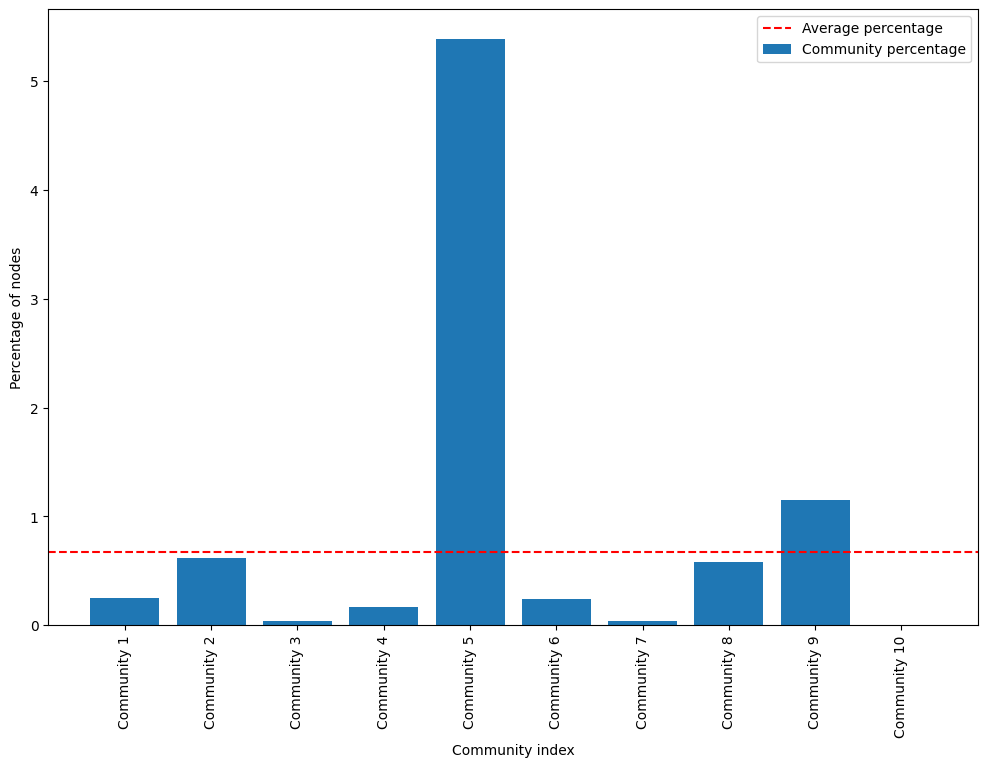

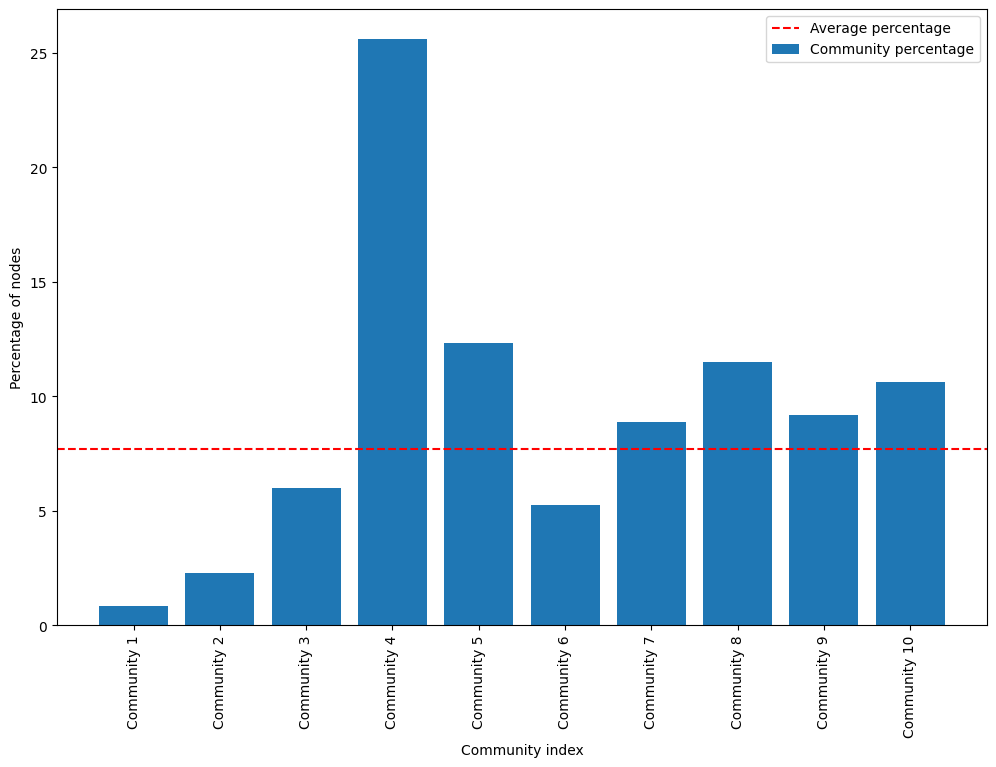

In [49]:
plt.figure(figsize=(12, 8))
plt.bar(range(len(top_communities)), community_EOA_gov_percentages, label='Community percentage')
plt.axhline(y=total_EOA_gov_percentage, color='r', linestyle='--', label='Average percentage')
plt.xlabel('Community index')
plt.ylabel('Percentage of nodes')
# plt.title('Percentage of governance nodes per community vs total governance percentage')
plt.legend()
plt.xticks(range(len(top_communities)), [f'Community {i+1}' for i in range(len(top_communities))], rotation=90)
plt.show()

plt.figure(figsize=(12, 8))
plt.bar(range(len(top_communities)), CEX_CA_percentages, label='Community percentage')
plt.axhline(y=total_CEX_percentage + total_CA_percentage, color='r', linestyle='--', label='Average percentage')
plt.xlabel('Community index')
plt.ylabel('Percentage of nodes')
# plt.title('Percentage of economic nodes per community vs total economic percentage')
plt.legend()
plt.xticks(range(len(top_communities)), [f'Community {i+1}' for i in range(len(top_communities))], rotation=90)
plt.show()

#### Feature averages per community

In [47]:
def plot_per_community(mapping):
    community_averages = {feature_name: [] for feature_name, _ in mapping}
    community_distributions = {feature_name: [] for feature_name, _ in mapping}

    for community in top_communities:
        community_node_ids = {G_comp_count_igraph_largest_wcc.vs[idx]["name"] for idx in community}

        for feature_name, feature_mapping in mapping:
            feature_values = [feature_mapping[node_id] for node_id in community_node_ids if node_id in feature_mapping]
            average_value = sum(feature_values) / len(feature_values) if feature_values else 0
            
            community_averages[feature_name].append(average_value)
            community_distributions[feature_name].append(feature_values)
    
    num_features = len(mapping)
    cols = 3
    rows = (num_features + cols - 1) // cols
    
    fig, axs = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axs = axs.flatten()
    
    for i, (feature_name, averages) in enumerate(community_averages.items()):
        axs[i].plot(range(len(top_communities)), averages, marker='o')
        axs[i].set_title(feature_name)
        axs[i].set_xlabel("Community index")
        axs[i].set_ylabel("Average feature score")
        axs[i].set_xticks(range(len(top_communities)))
        axs[i].set_xticklabels([f"{i+1}" for i in range(len(top_communities))])
    
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')
    
    plt.tight_layout()
    plt.show()

In [50]:
def plot_per_community_2(mapping):
    feature_stats = {}
    for feature_name, feature_mapping in mapping:
        values = list(feature_mapping.values())
        mean = np.mean(values)
        std = np.std(values)
        feature_stats[feature_name] = (mean, std)

    community_averages = {feature_name: [] for feature_name, _ in mapping}
    community_distributions = {feature_name: [] for feature_name, _ in mapping}

    for community in top_communities:
        community_node_ids = {G_comp_count_igraph_largest_wcc.vs[idx]["name"] for idx in community}

        for feature_name, feature_mapping in mapping:
            feature_values = [feature_mapping[node_id] for node_id in community_node_ids if node_id in feature_mapping]

            if feature_values:
                avg_val = sum(feature_values) / len(feature_values)
                mean, std = feature_stats[feature_name]
                z_score = (avg_val - mean) / std if std > 0 else 0
            else:
                z_score = 0

            community_averages[feature_name].append(z_score)
            community_distributions[feature_name].append(feature_values)

    num_features = len(mapping)
    cols = 3
    rows = (num_features + cols - 1) // cols

    fig, axs = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axs = axs.flatten()

    for i, (feature_name, averages) in enumerate(community_averages.items()):
        axs[i].plot(range(len(top_communities)), averages, marker='o')
        axs[i].set_title(f'{feature_name} (z-score)')
        axs[i].set_xlabel('Community index')
        axs[i].set_ylabel('Z-score')
        axs[i].set_xticks(range(len(top_communities)))
        axs[i].set_xticklabels([f"{i+1}" for i in range(len(top_communities))])

    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

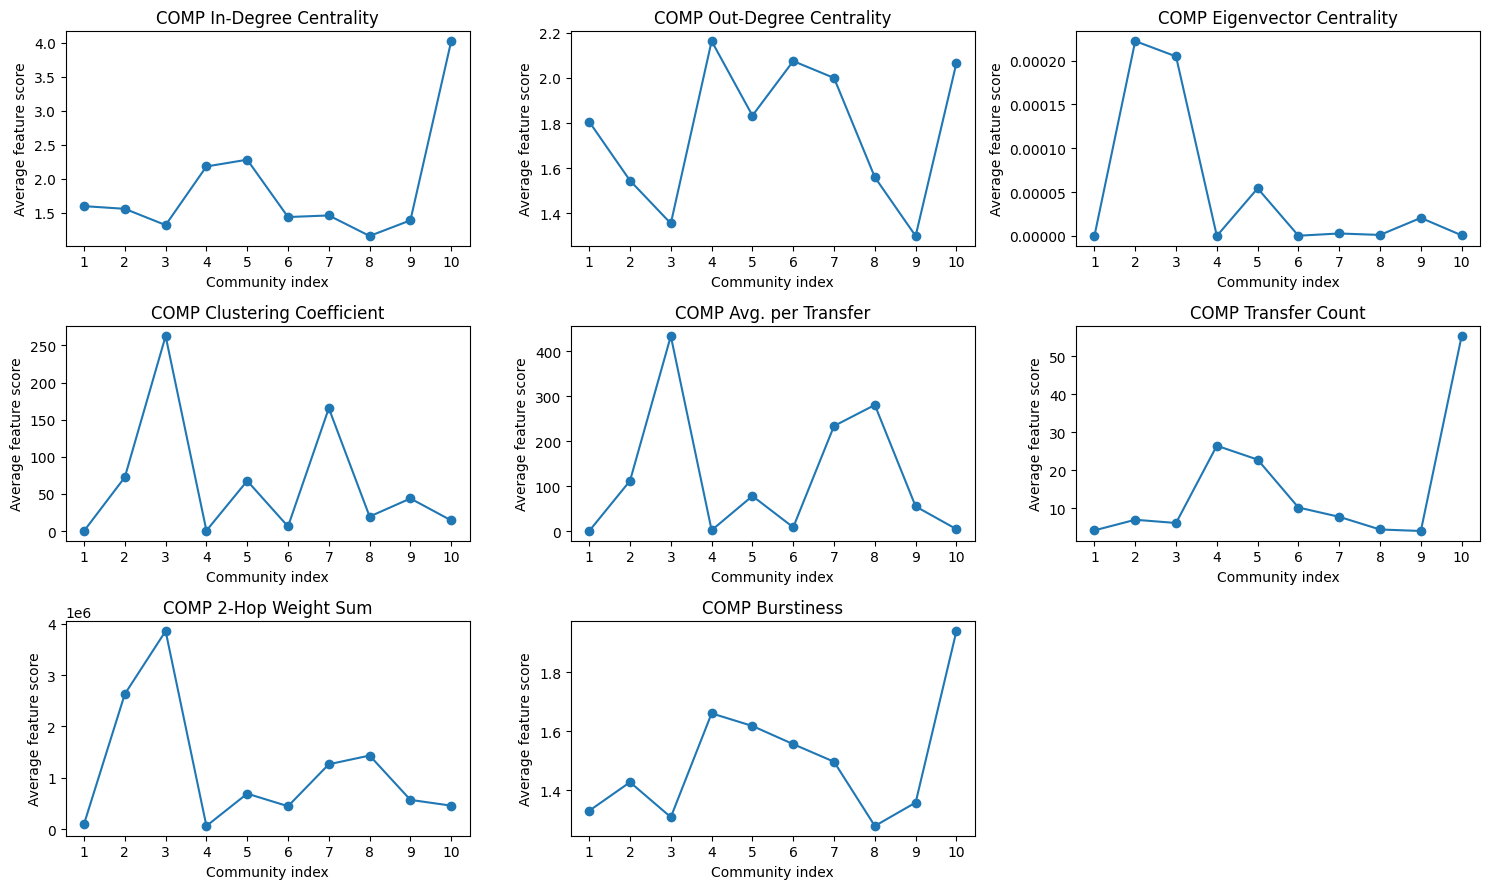

In [48]:
plot_per_community(COMP_mappings)

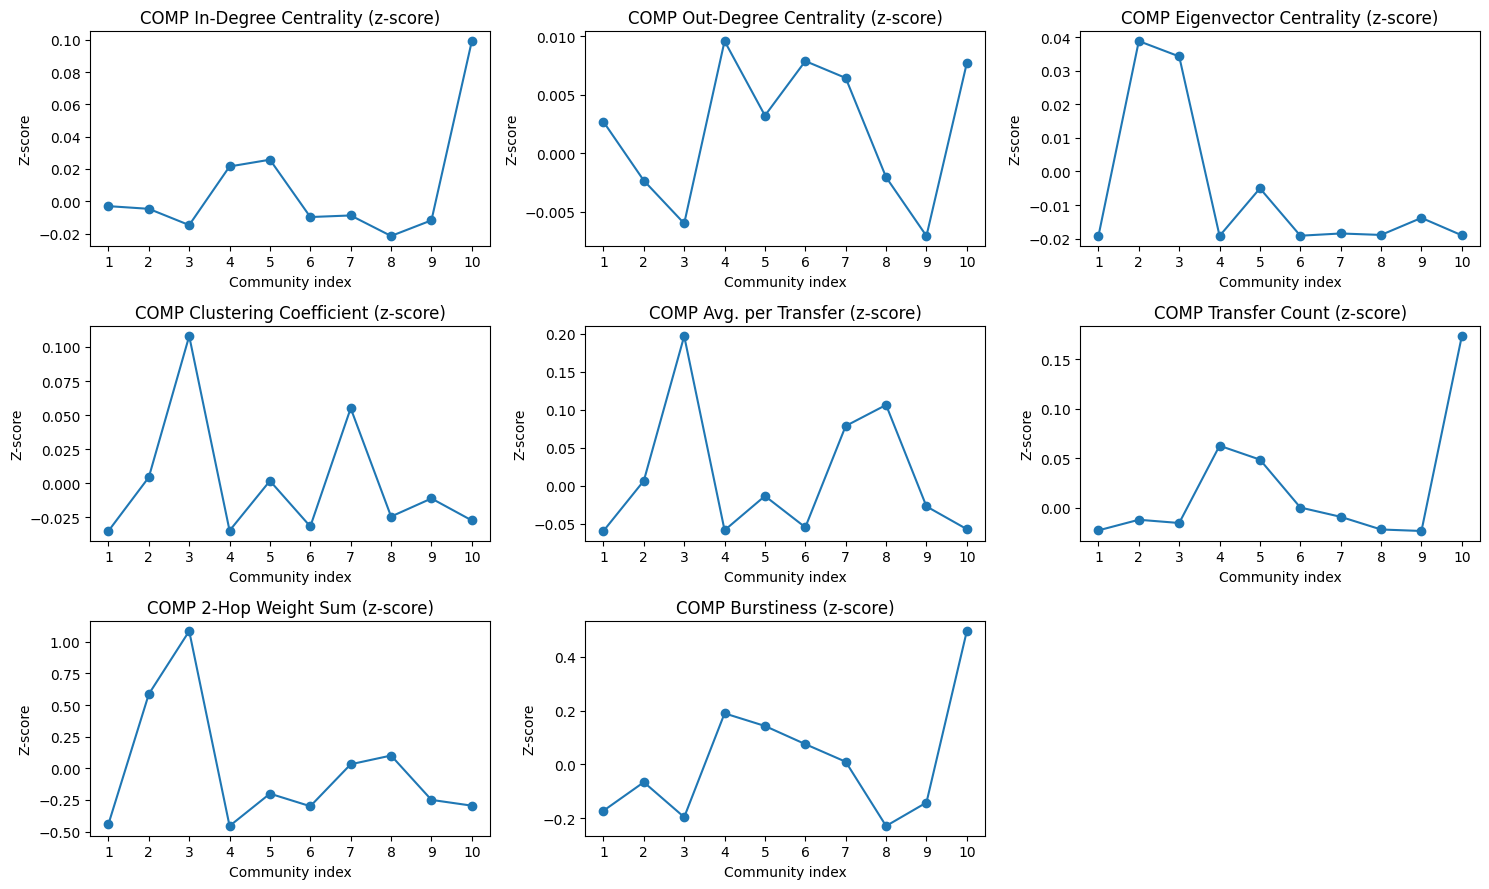

In [51]:
plot_per_community_2(COMP_mappings)

In [ ]:
plot_per_community(cWETH_mappings)

In [ ]:
plot_per_community_2(cWETH_mappings)

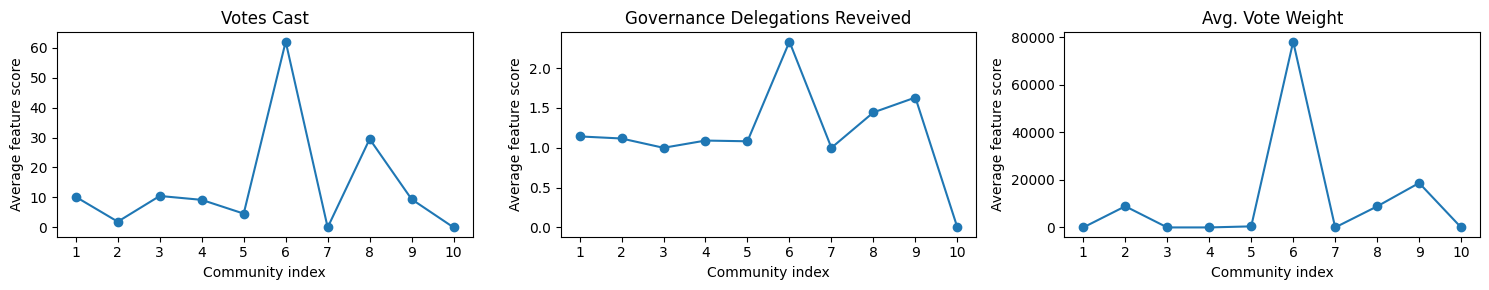

<Figure size 640x480 with 0 Axes>

In [59]:
plot_per_community(gov_mappings)

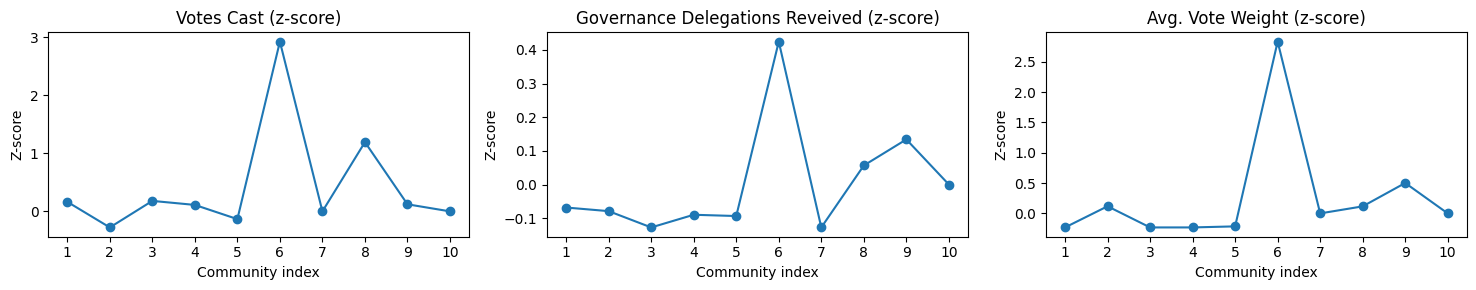

In [60]:
plot_per_community_2(gov_mappings)

#### SI influence comparison

In [ ]:
with open('data/SI/comp/SI_5_extracted_seeds_avg_infected.pkl', 'rb') as f:
    SI_5_extracted = pickle.load(f)
    
with open('data/SI/comp/SI_2_extracted_seeds_avg_infected.pkl', 'rb') as f:
    SI_2_extracted = pickle.load(f)
    
with open('data/SI/comp/SI_1_extracted_seeds_avg_infected.pkl', 'rb') as f:
    SI_1_extracted = pickle.load(f)
    
with open('data/SI/comp/SI_05_extracted_seeds_avg_infected.pkl', 'rb') as f:
    SI_05_extracted = pickle.load(f)
    
with open('data/SI/comp/SI_01_extracted_seeds_avg_infected.pkl', 'rb') as f:
    SI_01_extracted = pickle.load(f)
    
with open('data/SI/comp/SI_001_extracted_seeds_avg_infected.pkl', 'rb') as f:
    SI_001_extracted = pickle.load(f)

In [21]:
def plot_influence_multiple_runs(influence_data_list, beta_labels):
    num_runs = len(influence_data_list)
    num_communities = len(top_communities)

    community_scores = [defaultdict(list) for _ in range(num_runs)]

    for run_idx, influence_data in enumerate(influence_data_list):
        influence_scores = {entry['seed']: entry['avg_infected'] for entry in influence_data if entry['seed'] in all_proposers_voters_delegators_in_G_comp}
        for comm_id, community in enumerate(top_communities):
            for node_idx in community:
                node_id = G_comp_count_igraph_largest_wcc.vs[node_idx]['name']
                if node_id in influence_scores:
                    community_scores[run_idx][comm_id].append(influence_scores[node_id])

    fig, axs = plt.subplots(1, num_runs, figsize=(5 * num_runs, 3))
    if num_runs == 1:
        axs = [axs]
    for i in range(num_runs):
        avg_infs = [
            np.mean(community_scores[i][cid]) if community_scores[i][cid] else 0
            for cid in range(num_communities)
        ]
        axs[i].plot(range(num_communities), avg_infs, marker='o', label=f"β={beta_labels[i]}")
        axs[i].set_title(f"β={beta_labels[i]}")
        axs[i].set_xlabel("Community index")
        axs[i].set_ylabel("Average infected nodes")
        axs[i].set_xticks(range(num_communities))
        axs[i].set_xticklabels([f"{i+1}" for i in range(num_communities)])
        # axs[i].grid(True)
        # axs[i].legend()
    plt.tight_layout()
    plt.show()

    fig, axs = plt.subplots(1, num_runs, figsize=(5 * num_runs, 3))
    if num_runs == 1:
        axs = [axs]

    for i in range(num_runs):
        data = [community_scores[i][cid] for cid in range(num_communities)]
        axs[i].boxplot(data, positions=range(num_communities))
        axs[i].set_title(f"β={beta_labels[i]}")
        axs[i].set_xlabel("Community index")
        axs[i].set_ylabel("Average infected nodes")
        axs[i].set_xticks(range(num_communities))
        axs[i].set_xticklabels([f"{i+1}" for i in range(num_communities)])

    plt.tight_layout()
    plt.show()

    # fig, axs = plt.subplots(1, num_runs, figsize=(6 * num_runs, 5))
    # if num_runs == 1:
    #     axs = [axs]

    # for i in range(num_runs):
    #     data = [community_scores[i][cid] for cid in range(num_communities)]
    #     axs[i].violinplot(data, positions=range(num_communities), showmedians=True)
    #     axs[i].set_title(f"Violin plot (β={beta_labels[i]})")
    #     axs[i].set_xlabel("Community")
    #     axs[i].set_xticks(range(num_communities))
    #     axs[i].set_xticklabels([f"{cid}" for cid in range(num_communities)])
    #     axs[i].set_ylabel("Average infected nodes")

    # plt.tight_layout()
    # plt.show()

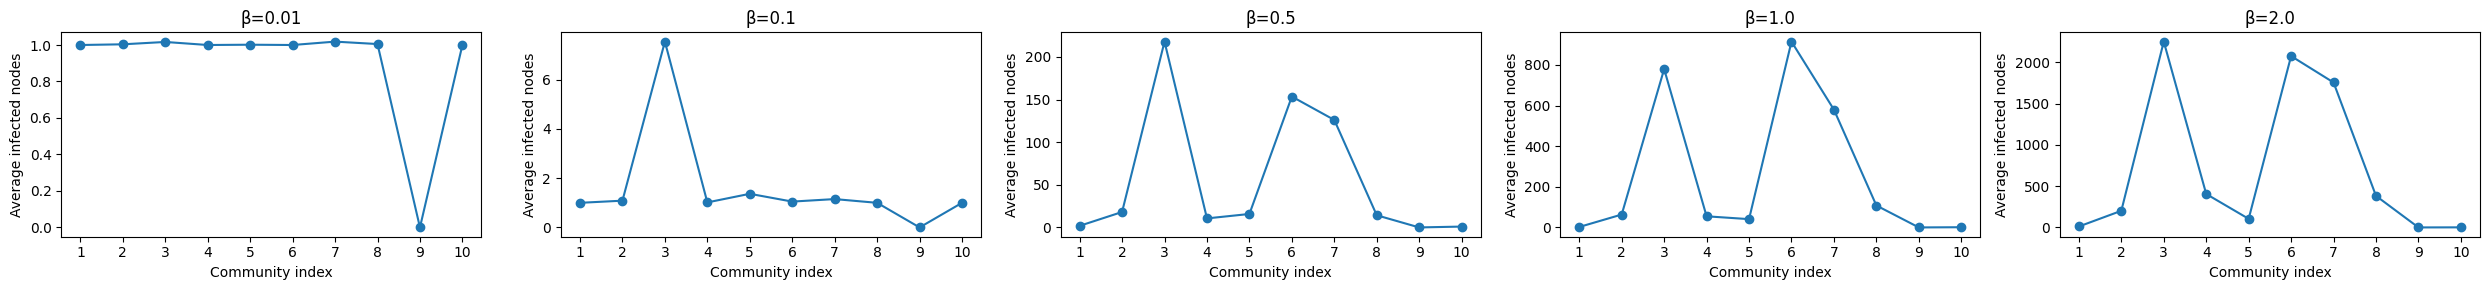

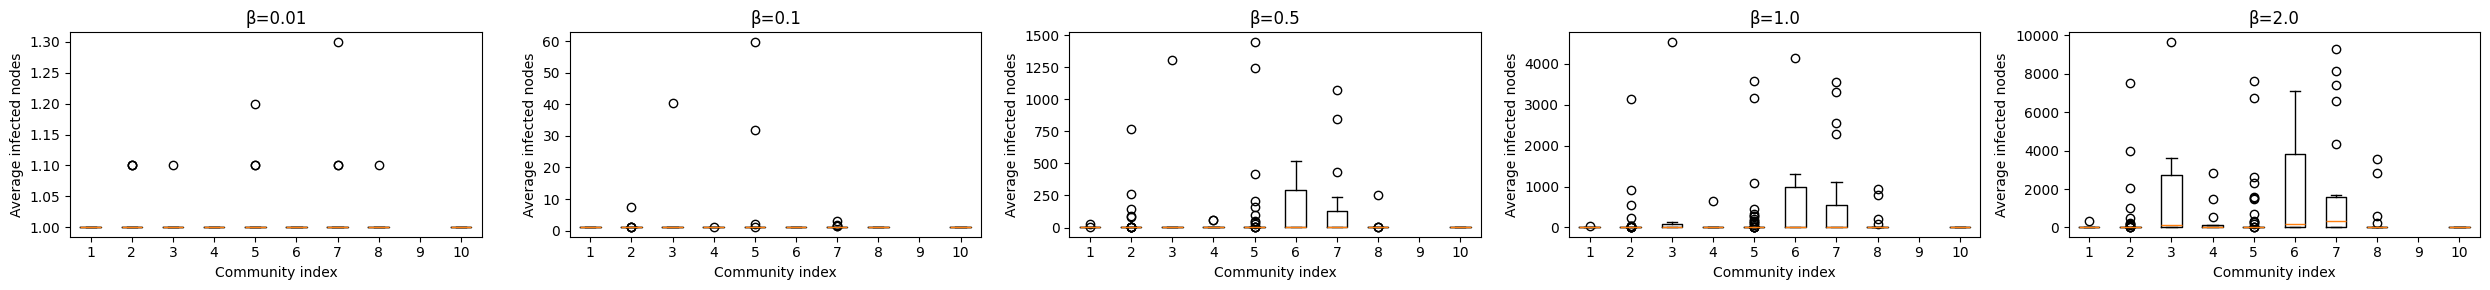

In [52]:
influence_dicts = [SI_001_extracted, SI_01_extracted, SI_05_extracted, SI_1_extracted, SI_2_extracted]#, SI_5_extracted]
labels = ['0.01', '0.1', '0.5', '1.0', '2.0']#, '5.0']

plot_influence_multiple_runs(influence_dicts, labels)

## SI

In [48]:
def normalize_weights(G):
    max_weight = max(data['weight'] for _, _, _, data in G.edges(keys=True, data=True))
    
    for _, _, _, data in G.edges(keys=True, data=True):
        data['norm_weight'] = data['weight'] / max_weight
    
    return G

def log_normalize_weights(G):
    max_weight = np.log1p(max(data['weight'] for _, _, _, data in G.edges(keys=True, data=True)))
    
    for _, _, _, data in G.edges(keys=True, data=True):
        data['norm_weight'] = np.log1p(data['weight']) / max_weight
    
    return G

### Simple SI model

In [58]:
G = copy.deepcopy(G_comp_complete)
# G_T = copy.deepcopy(G_comp_complete)

G = log_normalize_weights(G)
# G_T = normalize_weights(G_T)

In [59]:
def preprocess_out_edges(G, beta=1.0):
    out_edges = defaultdict(list)
    
    for u, v, k, d in G.edges(keys=True, data=True):
        out_edges[u].append((v, d['timestamp'], beta * d['norm_weight']))
    
    return out_edges

def simulate_SI(G, seed_node, beta=1.0, cached_edges=None):
    infected = {}
    infection_queue = []

    infected[seed_node] = 1696118400
    heapq.heappush(infection_queue, (1696118400, seed_node))

    while infection_queue:
        curr_time, node = heapq.heappop(infection_queue)
        
        if node not in cached_edges:
            continue
        
        for neighbor, ts, prob in cached_edges[node]:
        # for _, neighbor, _, data in G.out_edges(node, keys=True, data=True):
            if neighbor in infected:
                continue
            
            # ts = data['timestamp']
            # prob = beta * data['norm_weight']

            if ts >= curr_time:
                if np.random.rand() < prob:
                    infected[neighbor] = ts
                    heapq.heappush(infection_queue, (ts, neighbor))

    return infected

def run_multiple_iterations(G, num_iterations=100, beta=1.0):
    # all_nodes = list(G.nodes)
    all_nodes = list(all_proposers_voters_delegators_in_G_comp)
    infection_counts = defaultdict(list)
    infections_per_iteration = defaultdict(list)
    
    cached_edges = preprocess_out_edges(G, beta)

    for i in range(num_iterations):
        print(f"Iteration {i+1}/{num_iterations}")
        # for seed in tqdm(all_nodes, desc=f"SI iteration {i+1}"):
        for seed in all_nodes:
            infected = simulate_SI(G, seed, beta, cached_edges)
            infection_counts[seed].append(len(infected))
            infections_per_iteration[seed].append(infected)

    avg_results = [{
        'seed': node,
        'avg_infected': sum(counts) / len(counts),
        'infections_per_iteration': infections_per_iteration[node]
        # 'all_infected_counts': counts
    } for node, counts in infection_counts.items()]

    top_avg_influencers = sorted(avg_results, key=lambda x: x['avg_infected'], reverse=True)

    return top_avg_influencers

### Simulations

In [ ]:
SI_5 = run_multiple_iterations(G, num_iterations=10, beta=5.0)

with open('data/SI/comp/SI_5.pkl', 'wb') as file:
    pickle.dump(SI_5, file)

In [ ]:
SI_5_extracted = [{'seed': entry['seed'], 'avg_infected': entry['avg_infected']} for entry in SI_5]

with open('data/SI/comp/SI_5_extracted_seeds_avg_infected.pkl', 'wb') as file:
    pickle.dump(SI_5_extracted, file)

### Analysis

In [ ]:
SI_001_1_outcome = joblib.load('data/SI/comp/SI_001.pkl')
SI_01_1_outcome = joblib.load('data/SI/comp/SI_01.pkl')
SI_05_1_outcome = joblib.load('data/SI/comp/SI_05.pkl')
SI_1_1_outcome = joblib.load('data/SI/comp/SI_1.pkl')
SI_2_1_outcome = joblib.load('data/SI/comp/SI_2.pkl')
SI_5_1_outcome = joblib.load('data/SI/comp/SI_5.pkl')

In [ ]:
with open('data/SI/comp/SI_001_top_10.pkl', 'wb') as file:
    pickle.dump(SI_001_1_outcome[:10], file)
with open('data/SI/comp/SI_01_top_10.pkl', 'wb') as file:
    pickle.dump(SI_01_1_outcome[:10], file)
with open('data/SI/comp/SI_05_top_10.pkl', 'wb') as file:
    pickle.dump(SI_05_1_outcome[:10], file)
with open('data/SI/comp/SI_1_top_10.pkl', 'wb') as file:
    pickle.dump(SI_1_1_outcome[:10], file)

In [ ]:
# SI_001_1_extracted = [{'seed': entry['seed'], 'avg_infected': entry['avg_infected']} for entry in SI_001_1_outcome]
# SI_01_1_extracted = [{'seed': entry['seed'], 'avg_infected': entry['avg_infected']} for entry in SI_01_1_outcome]
# SI_05_1_extracted = [{'seed': entry['seed'], 'avg_infected': entry['avg_infected']} for entry in SI_05_1_outcome]
# SI_1_1_extracted = [{'seed': entry['seed'], 'avg_infected': entry['avg_infected']} for entry in SI_1_1_outcome]
SI_2_1_extracted = [{'seed': entry['seed'], 'avg_infected': entry['avg_infected']} for entry in SI_2_1_outcome]
SI_5_1_extracted = [{'seed': entry['seed'], 'avg_infected': entry['avg_infected']} for entry in SI_5_1_outcome]

In [72]:
BIN_SIZE = timedelta(days=1)

def plot_infections_average(infections_list):
    all_binned_counts = []

    for infections in infections_list:
        for iteration in infections['infections_per_iteration']:
            bin_counts = defaultdict(int)
            for ts in iteration.values():
                t = datetime.fromtimestamp(ts)
                bin_time = datetime(t.year, t.month, t.day)
                bin_counts[bin_time] += 1
            all_binned_counts.append(bin_counts)

    all_bins = sorted(set().union(*[d.keys() for d in all_binned_counts]))

    counts_matrix = []
    for bin_counts in all_binned_counts:
        counts = [bin_counts.get(t, 0) for t in all_bins]
        counts_matrix.append(counts)

    counts_matrix = np.array(counts_matrix)
    mean_counts = counts_matrix.mean(axis=0)
    std_counts = counts_matrix.std(axis=0)
    cumulative_mean = np.cumsum(mean_counts)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(all_bins, mean_counts, label='Mean infection rate')
    plt.fill_between(all_bins, mean_counts - std_counts, mean_counts + std_counts, alpha=0.2, label='Standard deviation')
    # plt.title('Average infection rate over time')
    plt.xlabel('Date')
    plt.ylabel('Infections')
    # plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(all_bins, cumulative_mean, label='Mean cumulative')
    # plt.title('Average cumulative infections over time')
    plt.xlabel('Date')
    plt.ylabel('Cumulative infections')
    # plt.legend()

    plt.tight_layout()
    plt.show()

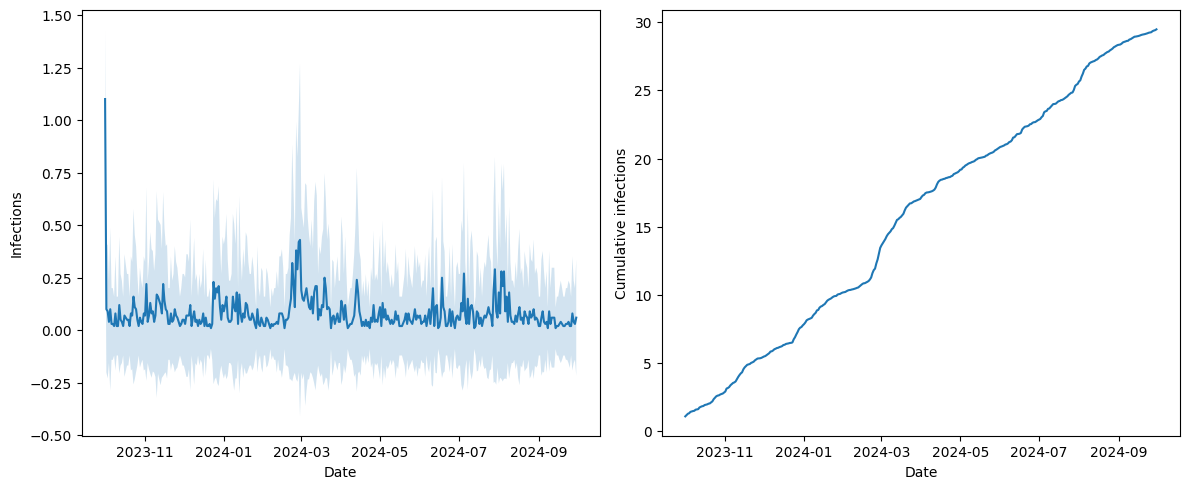

In [73]:
plot_infections_average(SI_001_1_outcome[:10])

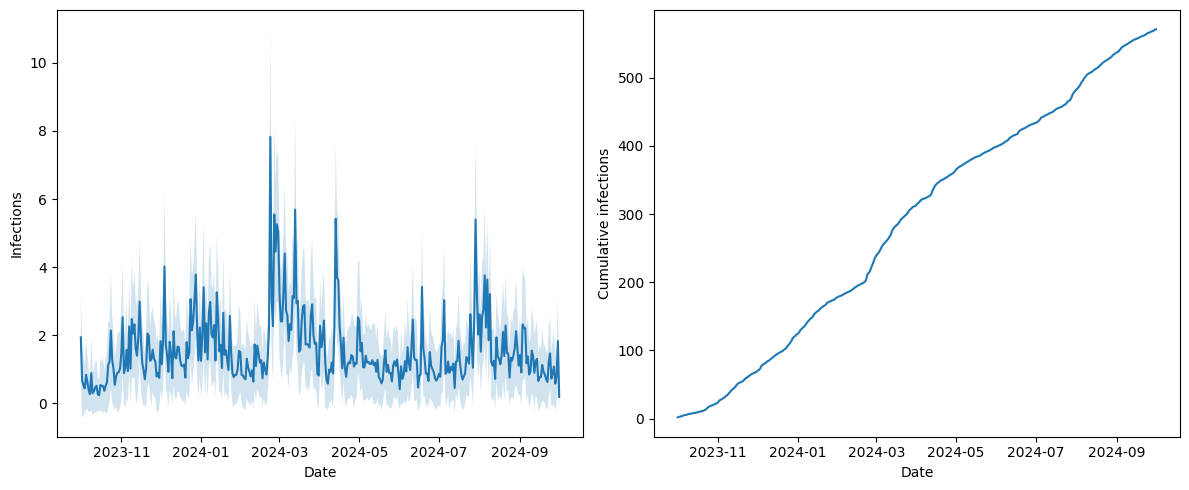

In [74]:
plot_infections_average(SI_01_1_outcome[:10])

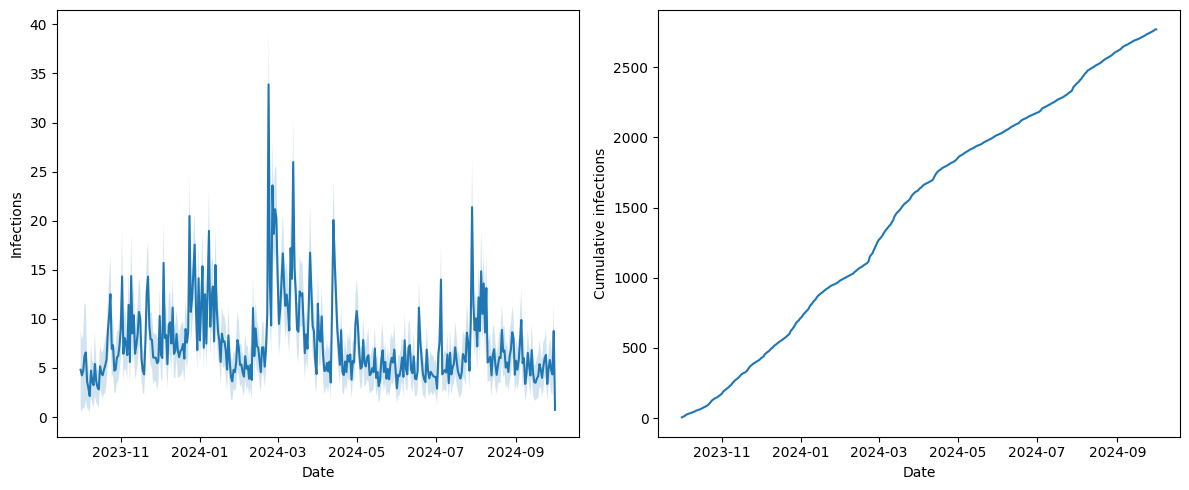

In [75]:
plot_infections_average(SI_05_1_outcome[:10])

In [ ]:
SI_001_outcome = joblib.load('data/SI/comp/SI_001_extracted_seeds_avg_infected.pkl')
SI_01_outcome = joblib.load('data/SI/comp/SI_01_extracted_seeds_avg_infected.pkl')
SI_05_outcome = joblib.load('data/SI/comp/SI_05_extracted_seeds_avg_infected.pkl')
SI_1_outcome = joblib.load('data/SI/comp/SI_1_extracted_seeds_avg_infected.pkl')
SI_2_outcome = joblib.load('data/SI/comp/SI_2_extracted_seeds_avg_infected.pkl')
SI_5_outcome = joblib.load('data/SI/comp/SI_5_extracted_seeds_avg_infected.pkl')

In [77]:
avg_infected_001 = [entry['avg_infected'] for entry in SI_001_outcome]
avg_infected_01 = [entry['avg_infected'] for entry in SI_01_outcome]
avg_infected_05 = [entry['avg_infected'] for entry in SI_05_outcome]
avg_infected_1 = [entry['avg_infected'] for entry in SI_1_outcome]

# avg_infected_001_T = [entry['avg_infected'] for entry in SI_T_001_outcome]
# avg_infected_01_T = [entry['avg_infected'] for entry in SI_T_01_outcome]
# avg_infected_05_T = [entry['avg_infected'] for entry in SI_T_05_outcome]
# avg_infected_1_T = [entry['avg_infected'] for entry in SI_T_1_outcome]

In [118]:
influence_scores = {
    'β=0.01': {seed['seed']: seed['avg_infected'] for seed in SI_001_outcome if seed['seed'] in all_proposers_voters_delegators_in_G_comp},
    'β=0.1': {seed['seed']: seed['avg_infected'] for seed in SI_01_outcome if seed['seed'] in all_proposers_voters_delegators_in_G_comp},
    'β=0.5': {seed['seed']: seed['avg_infected'] for seed in SI_05_outcome if seed['seed'] in all_proposers_voters_delegators_in_G_comp},
    'β=1.0': {seed['seed']: seed['avg_infected'] for seed in SI_1_outcome if seed['seed'] in all_proposers_voters_delegators_in_G_comp},
    'β=2.0': {seed['seed']: seed['avg_infected'] for seed in SI_2_outcome if seed['seed'] in all_proposers_voters_delegators_in_G_comp},
    # '5.0': {seed['seed']: seed['avg_infected'] for seed in SI_5_outcome if seed['seed'] in all_proposers_voters_delegators_in_G_comp}
}

influence_df = pd.DataFrame(influence_scores)

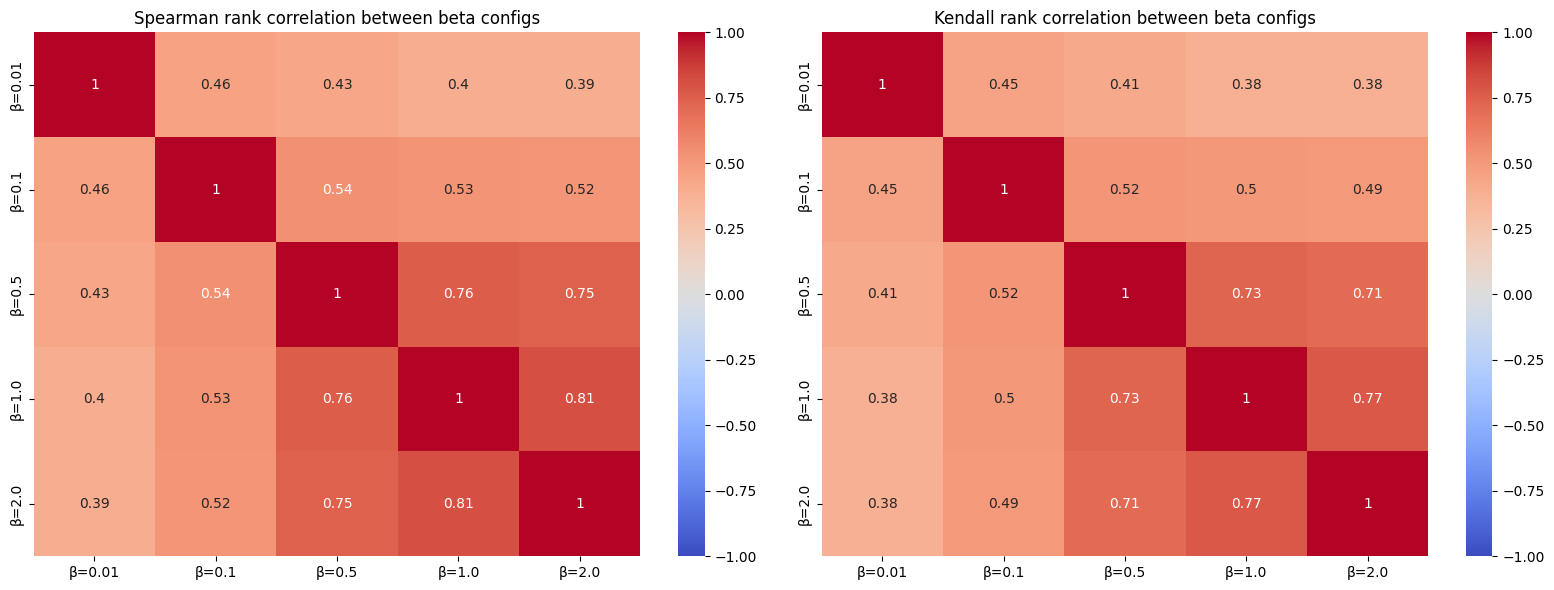

In [119]:
spearman_corr = influence_df.corr(method='spearman')
kendall_corr = influence_df.corr(method='kendall')
# pearson_corr = influence_df.corr(method='pearson')

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(spearman_corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, ax=axs[0])
axs[0].set_title("Spearman rank correlation between beta configs")

sns.heatmap(kendall_corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, ax=axs[1])
axs[1].set_title("Kendall rank correlation between beta configs")

plt.tight_layout()
plt.show()

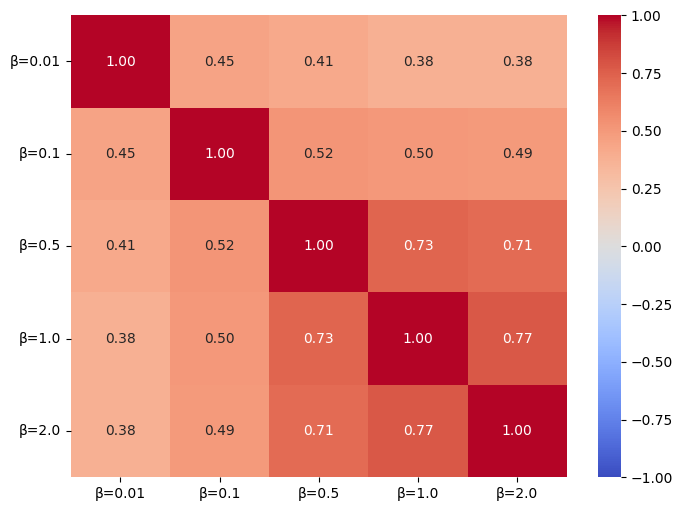

In [120]:
# spearman_corr = influence_df.corr(method='spearman')
kendall_corr = influence_df.corr(method='kendall')
# pearson_corr = influence_df.corr(method='pearson')

# plt.figure(figsize=(8, 6))
# sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', cbar=True, fmt='.2f', vmin=-1, vmax=1)
# plt.title("Spearman correlation")
# plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(kendall_corr, annot=True, cmap="coolwarm", cbar=True, fmt='.2f', vmin=-1, vmax=1)
plt.yticks(rotation=0)
# plt.title("Kendall correlation")
plt.show()

In [92]:
datasets = {
    '0.01': SI_001_outcome,
    '0.1': SI_01_outcome,
    '0.5': SI_05_outcome,
    '1.0': SI_1_outcome,
    '2.0': SI_2_outcome,
    '5.0': SI_5_outcome
}

In [99]:
def hist_comparison_per_beta(datasets):
    hist_data = {}
    
    for beta, dataset in datasets.items():
        temp = [i['avg_infected'] for i in dataset if i['seed'] in all_proposers_voters_delegators_in_G_comp]
        hist_data[beta] = temp
        
    fig, axs = plt.subplots(1, 6, figsize=(48, 6))
    axs = axs.flatten()

    for ax, (title, data) in zip(axs, hist_data.items()):
        ax.hist(data, bins=30, alpha=0.7, edgecolor='black', log=True)
        ax.set_title(title)
        ax.set_xlabel('Avg. infected nodes')
        ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

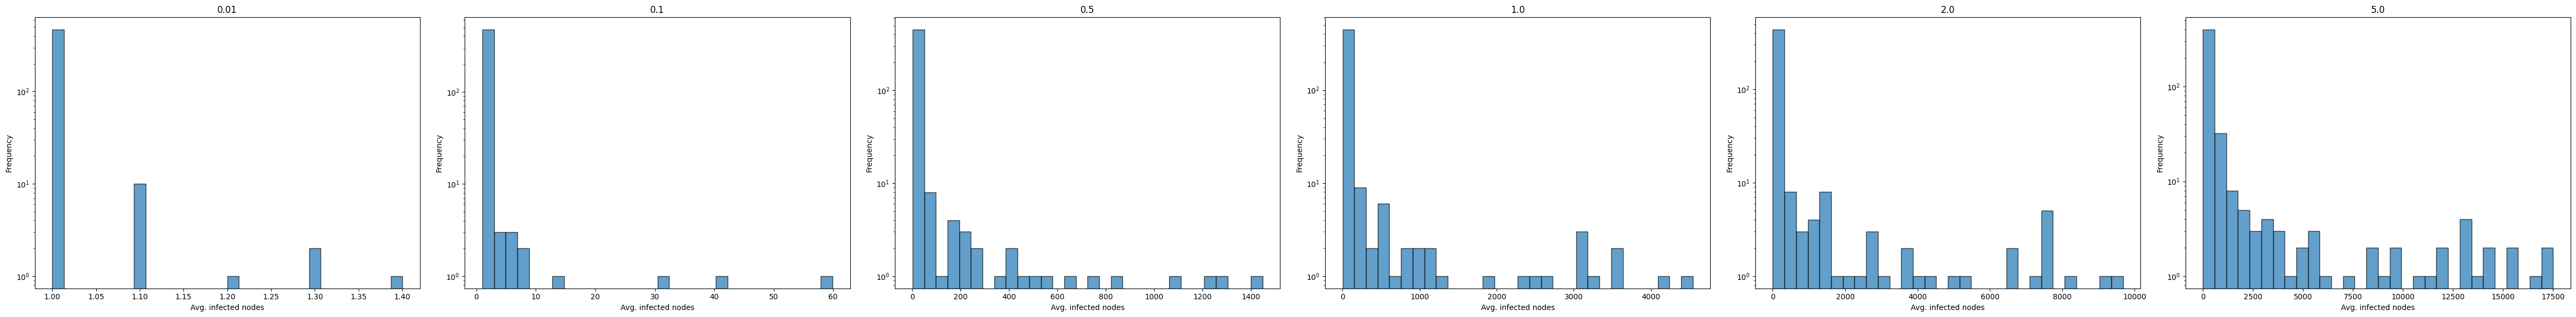

In [100]:
hist_comparison_per_beta(datasets)

In [48]:
def hist_comparison_per_config(datasets):
    for beta, dataset in datasets.items():
        fig, axs = plt.subplots(1, 3, figsize=(24, 6))
        axs = axs.flatten()

        groups = {
            'EOA governance': [i['avg_infected'] for i in dataset if i['seed'] in EOA and i['seed'] in all_proposers_voters_delegators_in_G_comp and i['seed'] not in CEX],
            'EOA non-governance': [i['avg_infected'] for i in dataset if i['seed'] in EOA and i['seed'] not in all_proposers_voters_delegators_in_G_comp and i['seed'] not in CEX],
            # 'CA': [i['avg_infected'] for i in dataset if i['seed'] in CA],
            # 'CEX': [i['avg_infected'] for i in dataset if i['seed'] in CEX],
            'Infrastructural': [i['avg_infected'] for i in dataset if i['seed'] in CEX or i['seed'] in CA]
        }

        for ax, (title, data) in zip(axs, groups.items()):
            ax.hist(data, bins=30, alpha=0.7, edgecolor='black', log=True)
            ax.set_title(title)
            ax.set_xlabel('Avg. infected nodes')
            ax.set_ylabel('Frequency')

        # fig.suptitle(f'β={beta}')#, fontsize=14)
        plt.tight_layout()
        plt.show()

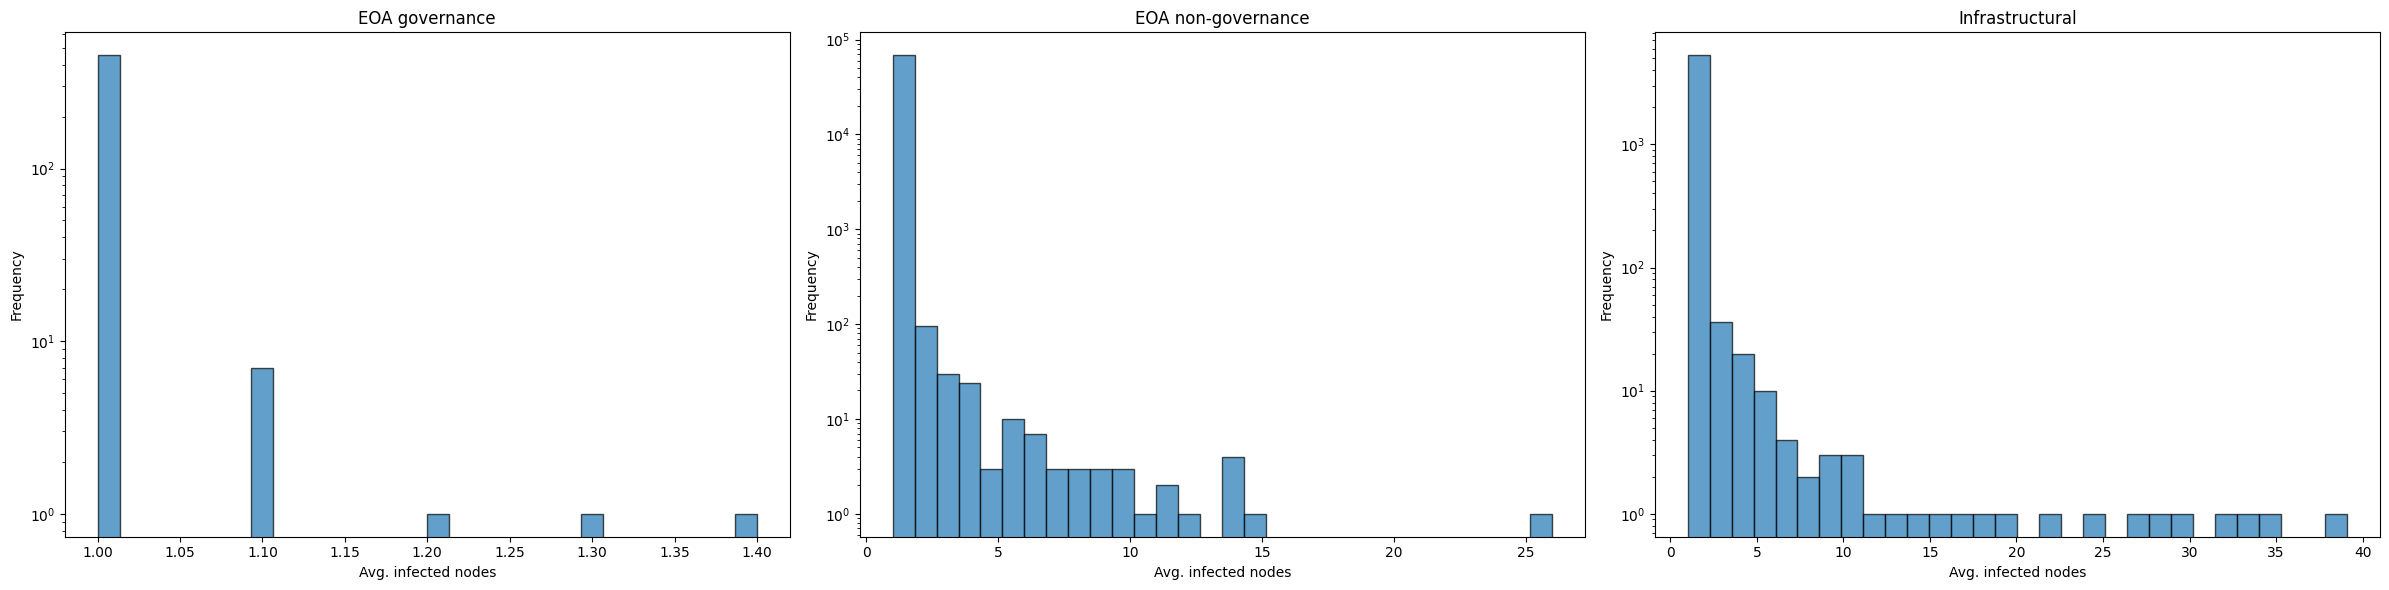

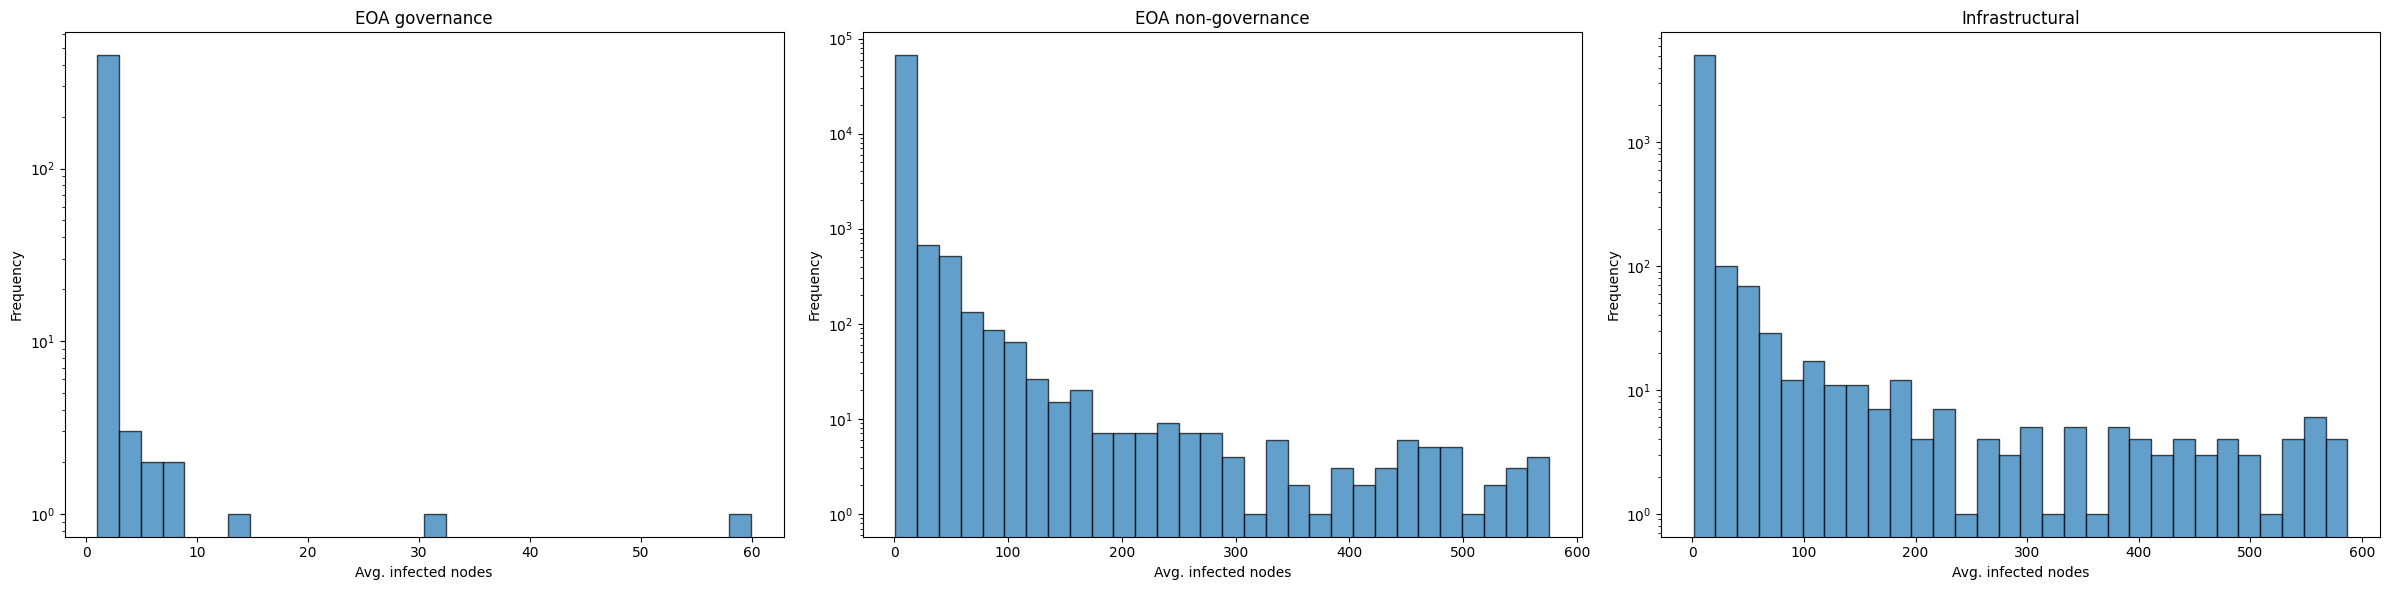

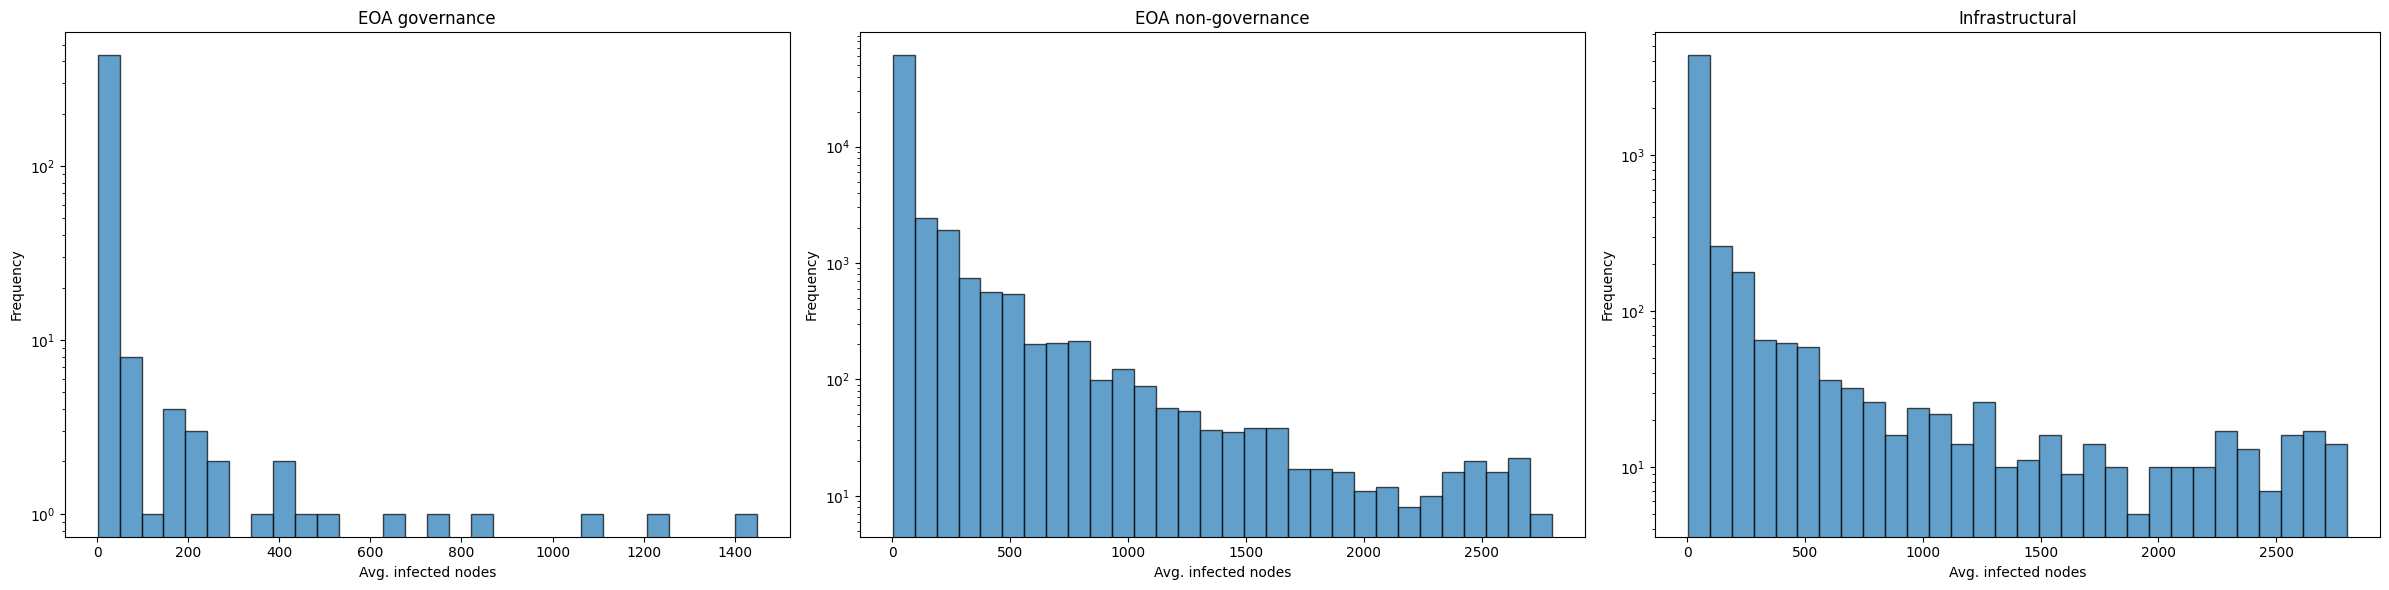

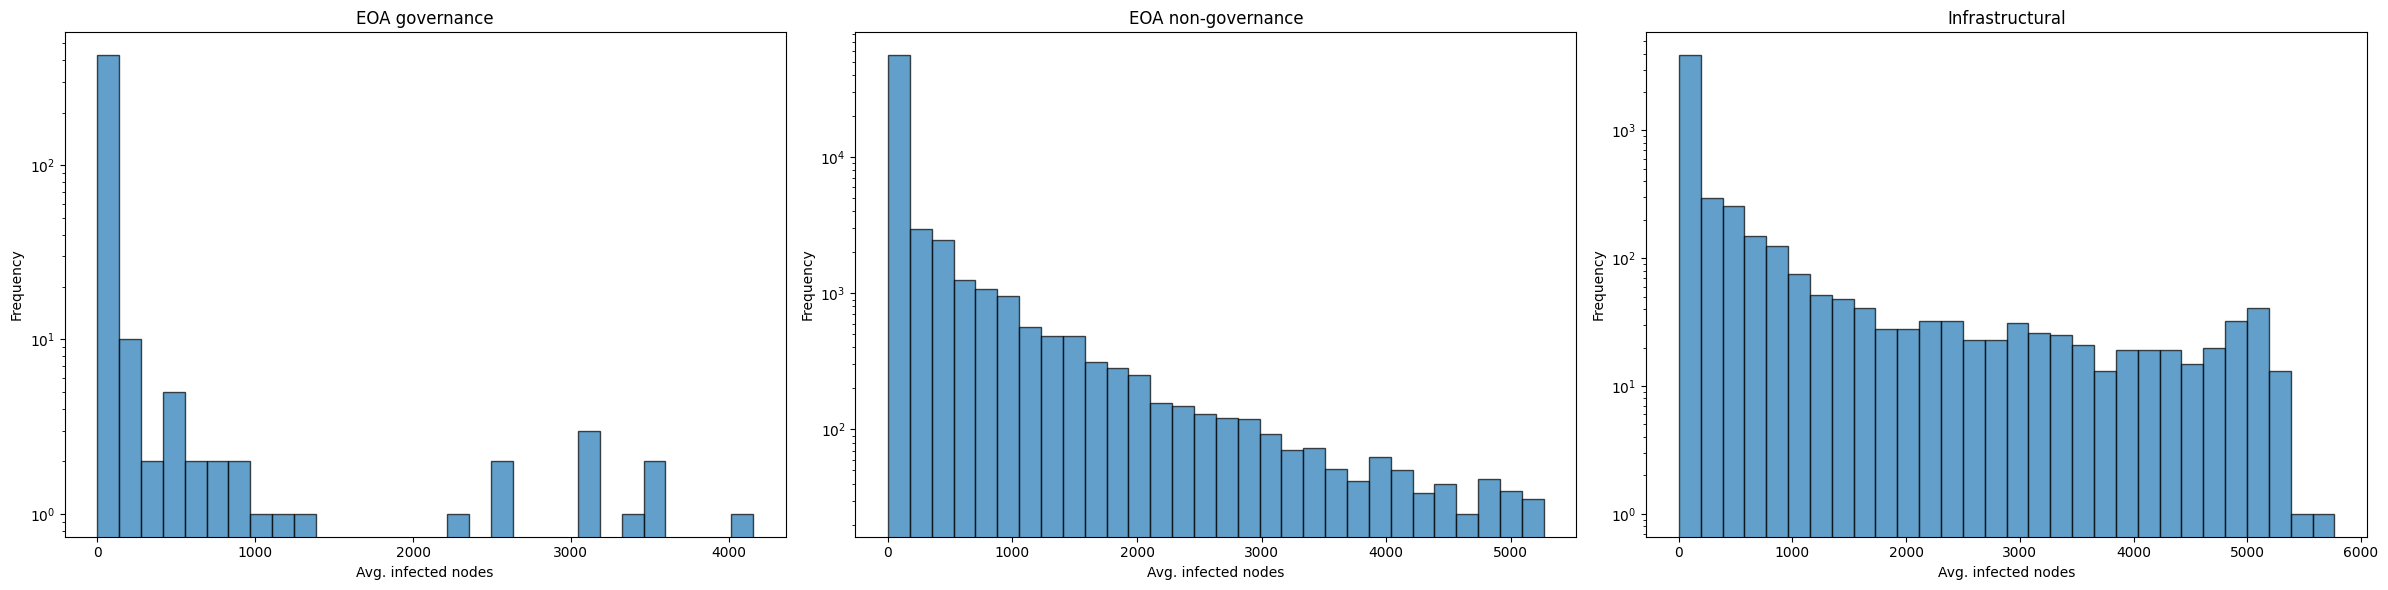

In [49]:
hist_comparison_per_config(datasets)

## Plots

### COMP

In [83]:
price_data = pd.read_csv('data/COMP_daily_USD.csv', parse_dates=['snapped_at'])

price_data['date'] = price_data['snapped_at'].dt.date

comp_df['date'] = pd.to_datetime(comp_df['timestamp'], unit='s')
comp_df['date'] = comp_df['date'].dt.date

merged_data_comp = comp_df.groupby('date').size().reset_index(name='num_entries')
merged_data_comp = comp_df.groupby('date').agg(num_entries=('value', 'count'), total_value=('value', 'sum')).reset_index()
merged_data_comp = merged_data_comp.merge(price_data[['date', 'price']], on='date', how='left')
merged_data_comp['total_traded_value'] = merged_data_comp['total_value'] * merged_data_comp['price']

C:\Users\Sam\AppData\Local\Temp\ipykernel_18036\2706193839.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df['date'] = pd.to_datetime(comp_df['timestamp'], unit='s')
C:\Users\Sam\AppData\Local\Temp\ipykernel_18036\2706193839.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df['date'] = comp_df['date'].dt.date


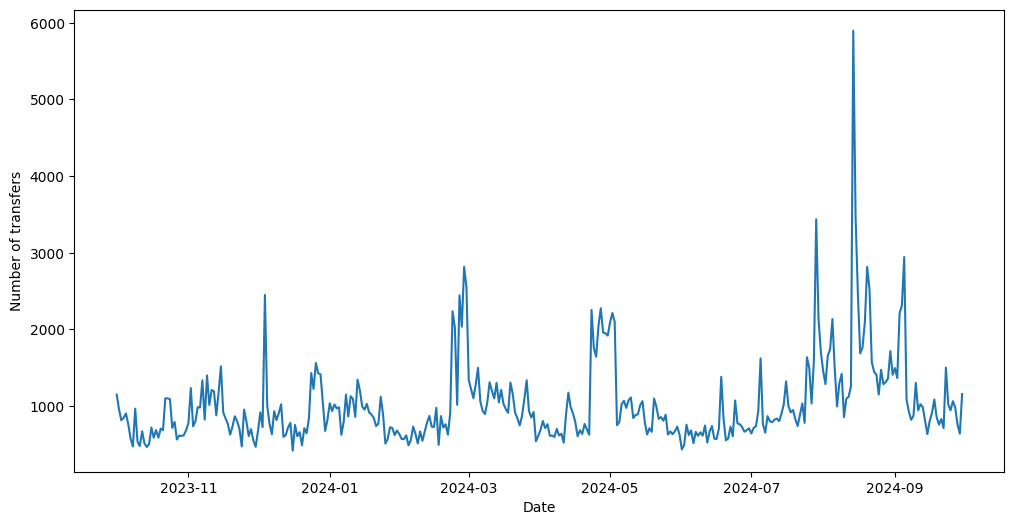

In [85]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(merged_data_comp['date'], merged_data_comp['num_entries'])
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of transfers')
ax1.tick_params(axis='y')

# ax2 = ax1.twinx()
# ax2.plot(merged_data_comp['date'], merged_data_comp['price'], color='red')
# ax2.set_ylabel('Price', color='red')
# ax2.tick_params(axis='y', labelcolor='red')

# plt.title('Number of COMP transfers per day')
plt.show()

# fig, ax1 = plt.subplots(figsize=(12, 6))

# ax1.plot(merged_data_comp['date'], merged_data_comp['total_value'])
# ax1.set_xlabel('Date')
# ax1.set_ylabel('Number of tokens')
# ax1.tick_params(axis='y')

# # ax2 = ax1.twinx()
# # ax2.plot(merged_data_comp['date'], merged_data_comp['price'], color='red')
# # ax2.set_ylabel('Price', color='red')
# # ax2.tick_params(axis='y', labelcolor='red')

# plt.title('Number of COMP tokens transferred per day and price over time')
# plt.show()

# plt.figure(figsize=(12, 6))
# plt.plot(merged_data_comp['date'], merged_data_comp['total_traded_value'])
# plt.xlabel('Date')
# plt.ylabel('Total traded value in USD')
# plt.title('Total COMP value traded per day')
# plt.show()

In [64]:
comp_addresses = pd.concat([comp_df['from'], comp_df['to']])
cToken_addresses = pd.concat([cToken_df['from'], cToken_df['to']])

comp_transaction_counts = comp_addresses.value_counts()
cToken_transaction_counts = cToken_addresses.value_counts()

voters_set = set(vote_counts.keys())

comp_voters_transaction_counts = comp_transaction_counts[comp_transaction_counts.index.isin(voters_set)]
comp_non_voters_transaction_counts = comp_transaction_counts[~comp_transaction_counts.index.isin(voters_set)]

cWETH_voters_transaction_counts = cToken_transaction_counts[cToken_transaction_counts.index.isin(voters_set)]
cWETH_non_voters_transaction_counts = cToken_transaction_counts[~cToken_transaction_counts.index.isin(voters_set)]

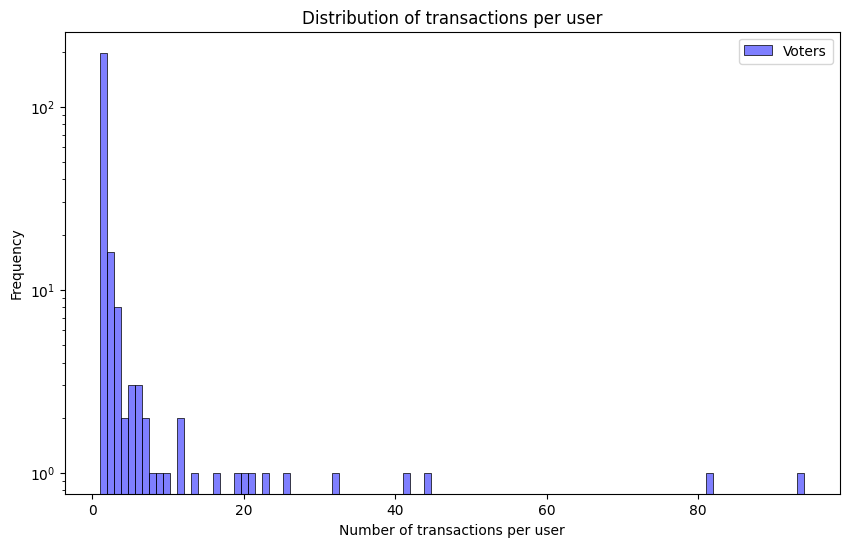

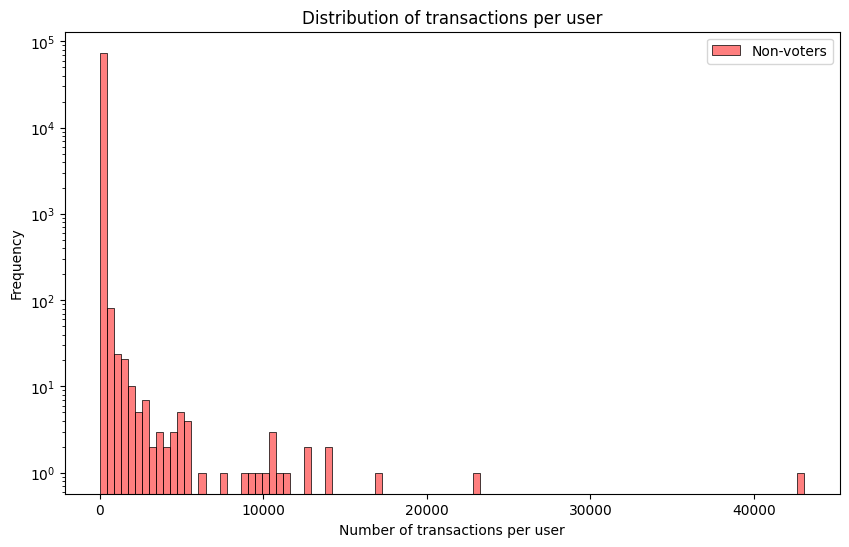

In [65]:
plt.figure(figsize=(10, 6))
sns.histplot(comp_voters_transaction_counts, bins=100, color='blue', label='Voters', alpha=0.5)
plt.yscale('log')
plt.xlabel("Number of transactions per user")
plt.ylabel("Frequency")
plt.title("Distribution of transactions per user")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(comp_non_voters_transaction_counts, bins=100, color='red', label='Non-voters', alpha=0.5)
plt.yscale('log')
plt.xlabel("Number of transactions per user")
plt.ylabel("Frequency")
plt.title("Distribution of transactions per user")
plt.legend()
plt.show()

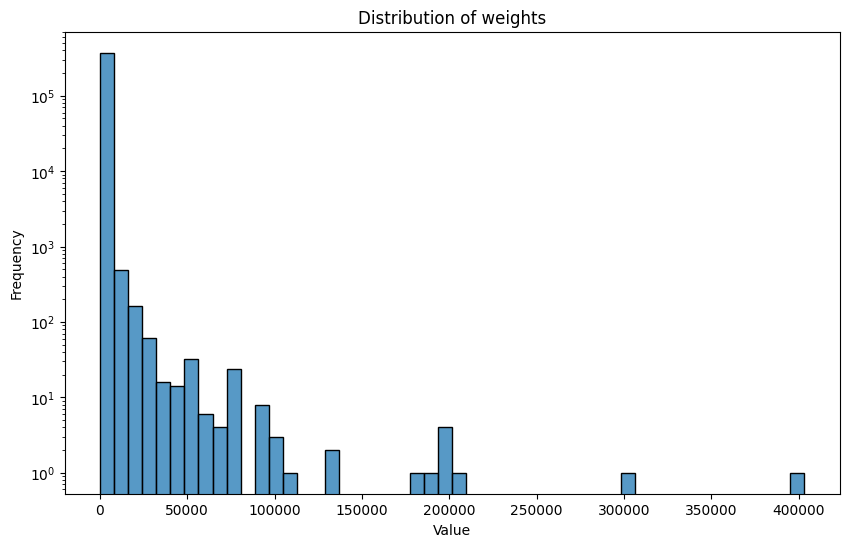

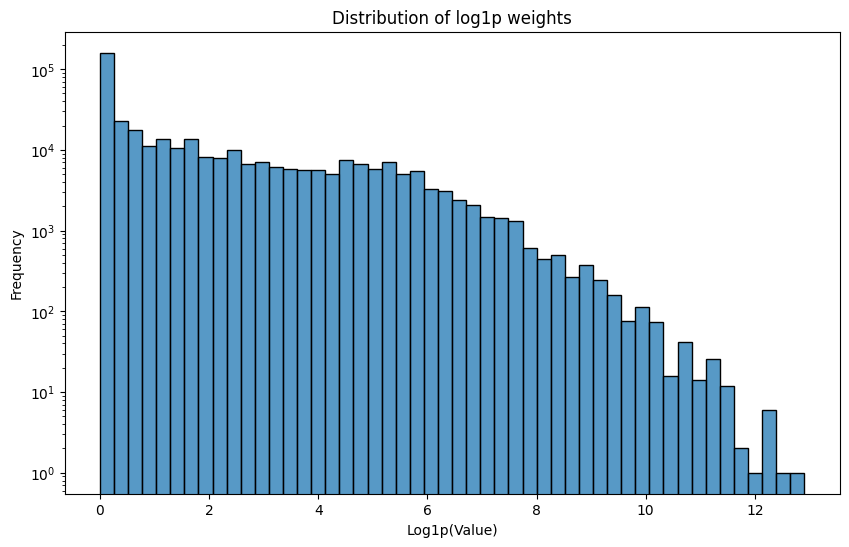

In [66]:
plt.figure(figsize=(10, 6))
sns.histplot(comp_df['value'], bins=50, edgecolor='black')
plt.yscale('log')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of weights')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(comp_df['value']), bins=50)
plt.yscale('log')
plt.xlabel('Log1p(Value)')
plt.ylabel('Frequency')
plt.title('Distribution of log1p weights')
plt.show()

### cWETH

### Governance

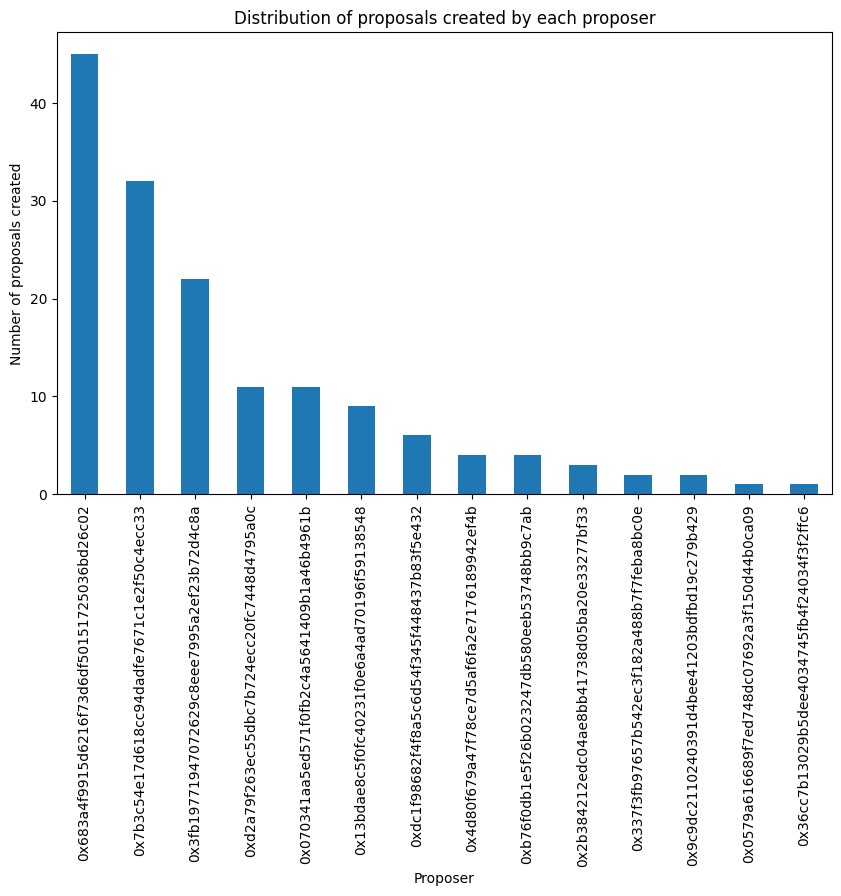

In [67]:
proposer_counts = pd.Series([proposal['proposer']['id'] for proposal in comp_proposals]).value_counts()

plt.figure(figsize=(10, 6))
proposer_counts.plot(kind='bar')
plt.xlabel('Proposer')
plt.ylabel('Number of proposals created')
plt.title('Distribution of proposals created by each proposer')
plt.show()

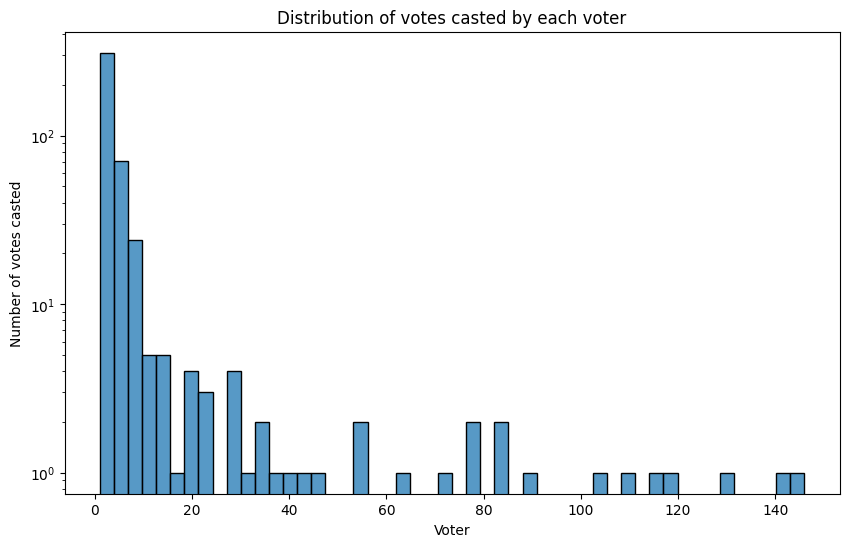

In [68]:
voter_counts = pd.Series([vote['voter']['id'].lower() for votes in comp_votes for vote in votes['votes']]).value_counts()

plt.figure(figsize=(10, 6))
sns.histplot(voter_counts, bins=50)
plt.yscale('log')
plt.xlabel('Voter')
plt.ylabel('Number of votes casted')
plt.title('Distribution of votes casted by each voter')
plt.show()

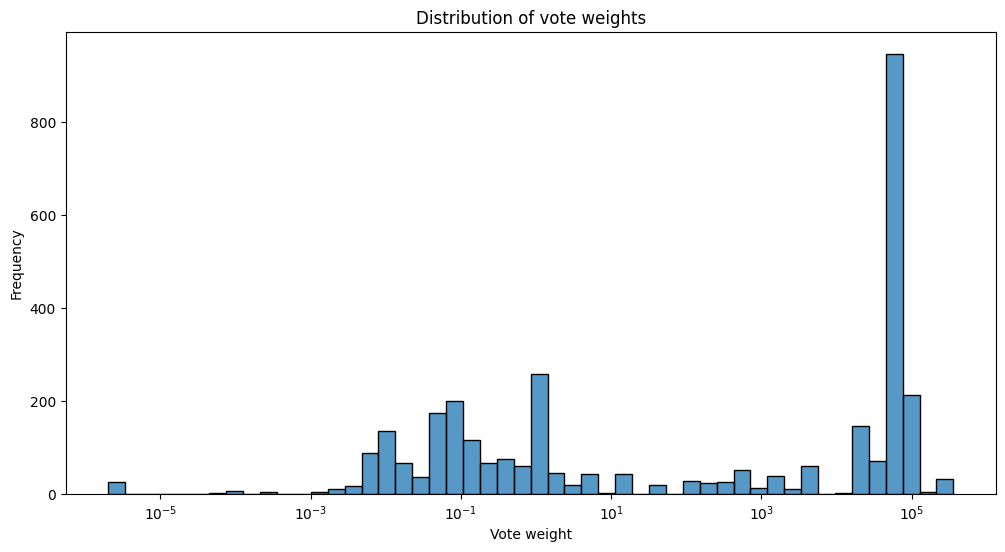

In [69]:
vote_weights = []

for votes in comp_votes:
    for vote in votes['votes']:
        vote_weights.append(float(vote['weight']))

plt.figure(figsize=(12, 6))
sns.histplot(vote_weights, bins=50, log_scale=(True, False))
plt.xlabel('Vote weight')
plt.ylabel('Frequency')
plt.title('Distribution of vote weights')
plt.show()

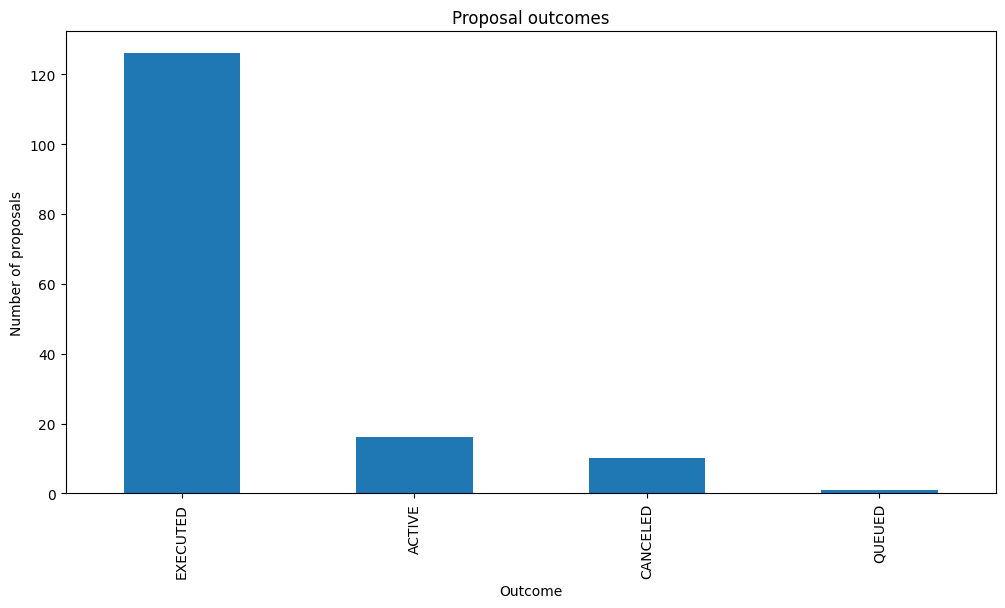

In [70]:
proposal_outcomes = pd.Series([proposal['state'] for proposal in comp_proposals])

plt.figure(figsize=(12, 6))
proposal_outcomes.value_counts().plot(kind='bar')
plt.xlabel('Outcome')
plt.ylabel('Number of proposals')
plt.title('Proposal outcomes')
plt.show()

C:\Users\Sam\AppData\Local\Temp\ipykernel_17980\1551493776.py:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  delegations_df['date'] = pd.to_datetime(delegations_df['blockTimestamp'], unit='s')


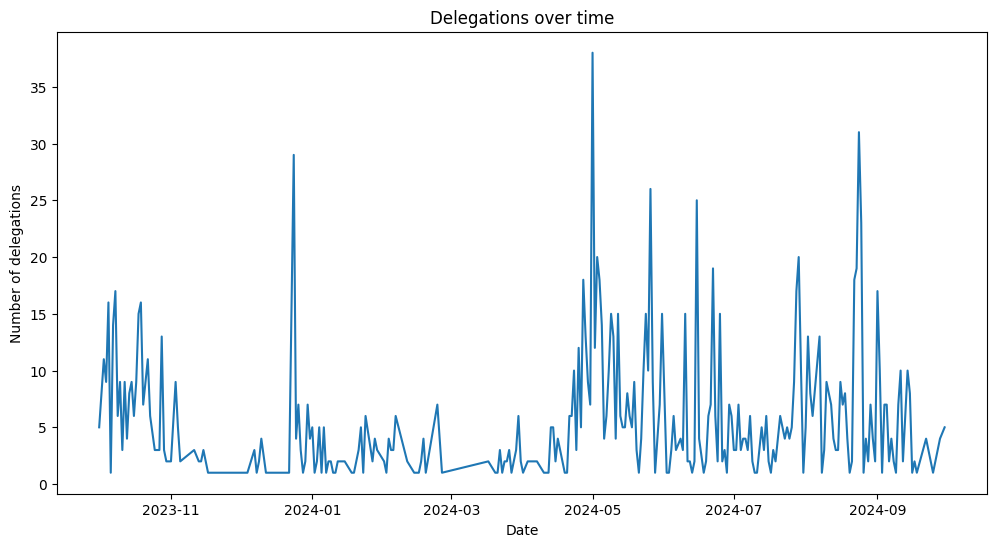

In [71]:
delegations_df = pd.DataFrame(delegations)
delegations_df['date'] = pd.to_datetime(delegations_df['blockTimestamp'], unit='s')
delegations_df['date'] = delegations_df['date'].dt.date
delegations_over_time = delegations_df.groupby('date').size()

plt.figure(figsize=(12, 6))
delegations_over_time.plot()
plt.xlabel('Date')
plt.ylabel('Number of delegations')
plt.title('Delegations over time')
plt.show()

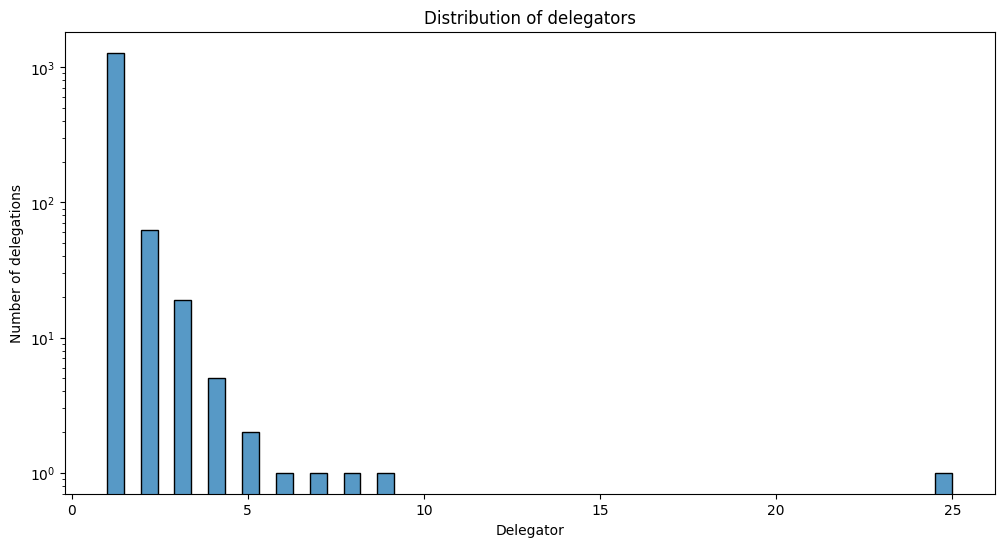

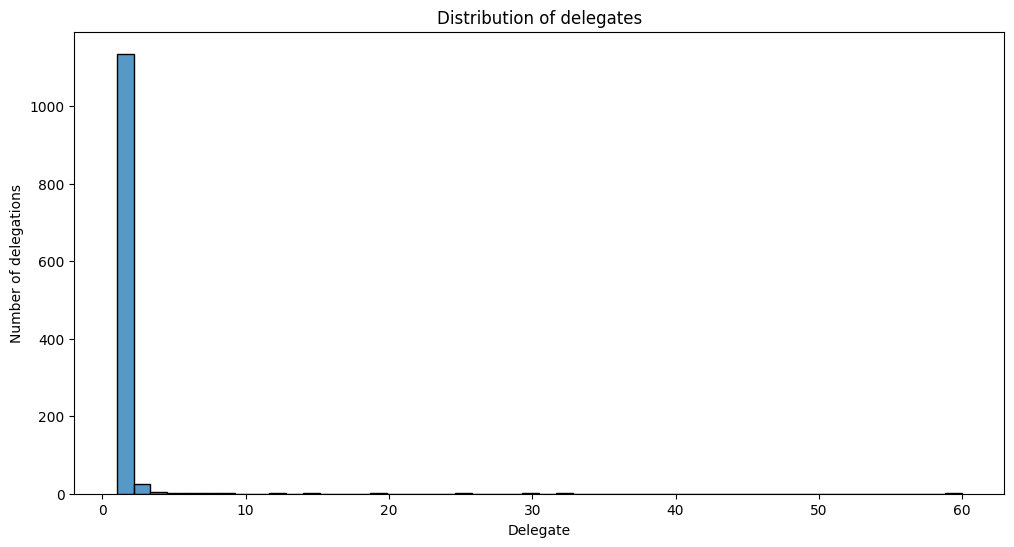

In [72]:
delegator_counts = delegations_df['delegator'].value_counts()
delegate_counts = delegations_df['delegate'].value_counts()

plt.figure(figsize=(12, 6))
sns.histplot(delegator_counts, bins=50)
plt.yscale('log')
plt.xlabel('Delegator')
plt.ylabel('Number of delegations')
plt.title('Distribution of delegators')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(delegate_counts, bins=50)#, log_scale=(True, False))
# plt.yscale('log')
# plt.xscale('log')
plt.xlabel('Delegate')
plt.ylabel('Number of delegations')
plt.title('Distribution of delegates')
plt.show()

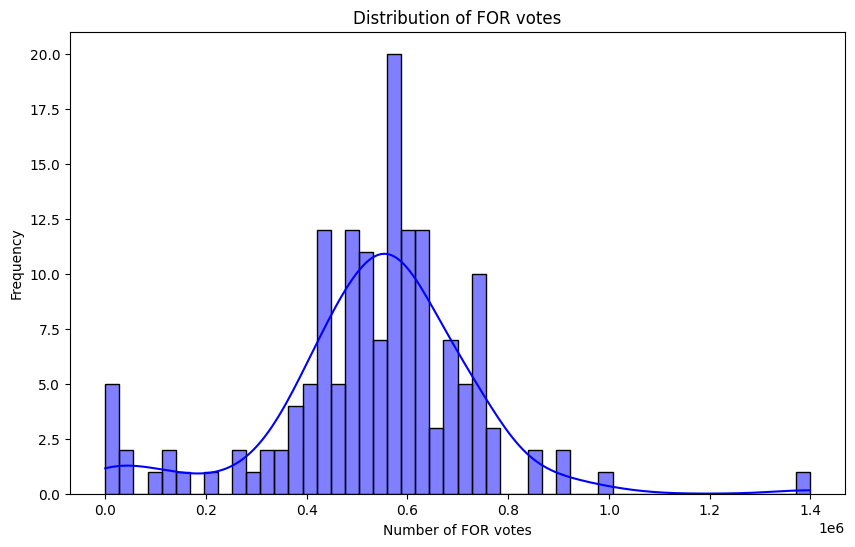

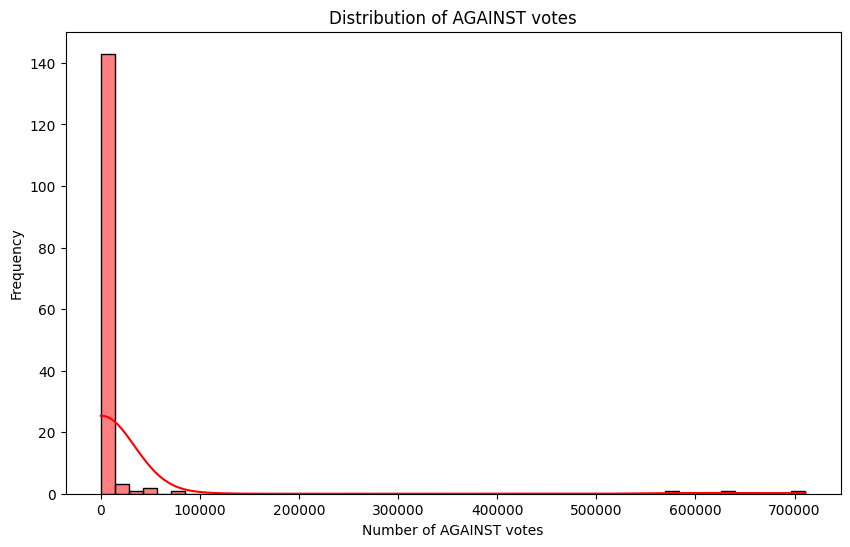

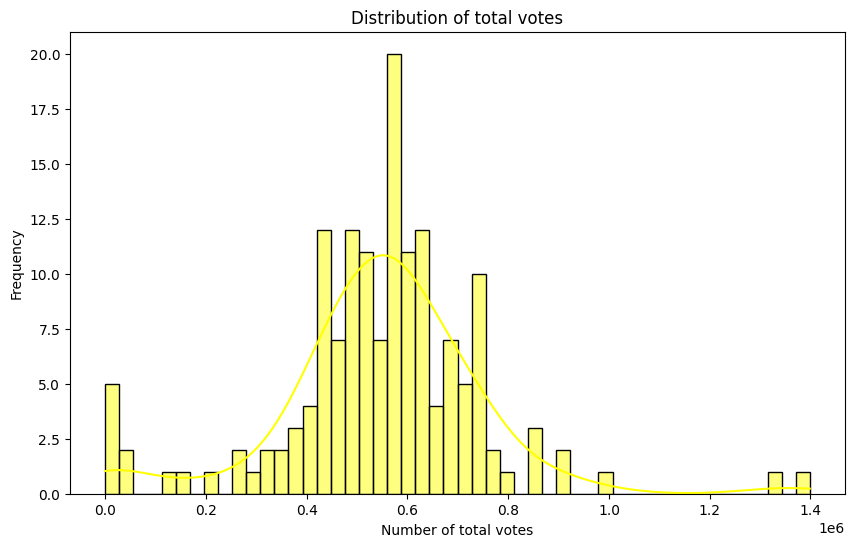

In [ ]:
for_votes = {proposal['id']: float(proposal['forWeightedVotes']) for proposal in comp_proposals}

against_votes = {proposal['id']: float(proposal['againstWeightedVotes']) for proposal in comp_proposals}
                
total_votes = {proposal['id']: float(proposal['forWeightedVotes']) + float(proposal['againstWeightedVotes']) for proposal in comp_proposals}

# num_voters = {proposal['id']: proposal['totalCurrentVoters'] for proposal in comp_proposals}

plt.figure(figsize=(10, 6))
sns.histplot(for_votes, bins=50, color='blue', kde=True)
plt.xlabel('Number of FOR votes')
plt.ylabel('Frequency')
plt.title('Distribution of FOR votes')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(against_votes, bins=50, color='red', kde=True)
plt.xlabel('Number of AGAINST votes')
plt.ylabel('Frequency')
plt.title('Distribution of AGAINST votes')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(total_votes, bins=50, color='yellow', kde=True)
plt.xlabel('Number of total votes')
plt.ylabel('Frequency')
plt.title('Distribution of total votes')
plt.show()

# plt.figure(figsize=(10, 6))
# sns.histplot(num_voters, bins=50, color='green', kde=True)
# plt.xlabel('Number of voters')
# plt.ylabel('Frequency')
# plt.title('Distribution of the number of voters')
# plt.show()

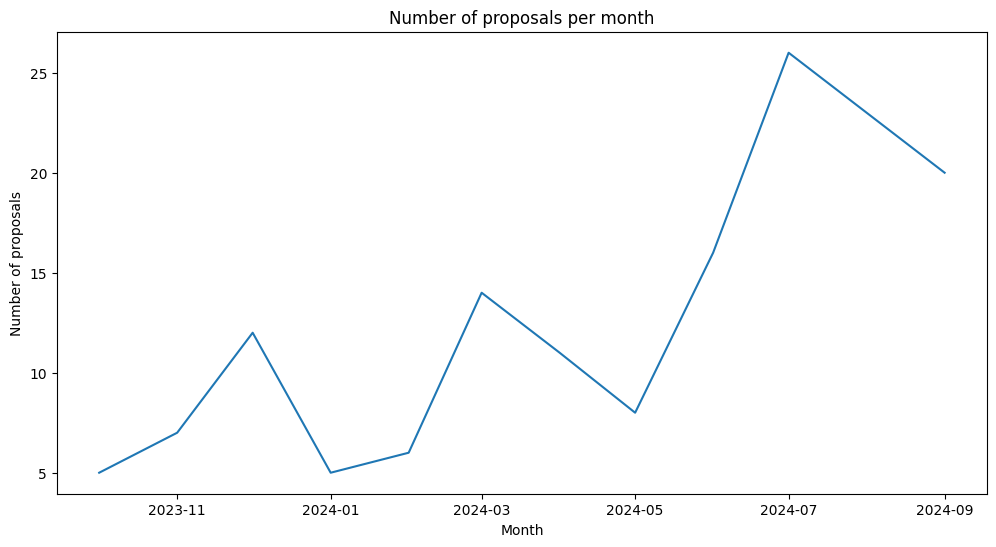

In [75]:
all_proposal_dates = [datetime.fromtimestamp(int(proposal['creationTime'])) for proposal in comp_proposals]

proposal_dates_df = pd.DataFrame({'date': all_proposal_dates})
proposal_dates_df['month'] = proposal_dates_df['date'].dt.to_period('M')

proposals_per_month = proposal_dates_df.groupby('month').size().reset_index(name='count')

proposals_per_month['month'] = proposals_per_month['month'].dt.to_timestamp()

plt.figure(figsize=(12, 6))
plt.plot(proposals_per_month['month'], proposals_per_month['count'])
plt.xlabel('Month')
plt.ylabel('Number of proposals')
plt.title('Number of proposals per month')
plt.show()